## Table of Contents
#### Preliminaries
- [adding abilities to strategies_dict](#adding_abilities)
- [Cleaning up the target feature (formats)](#cleaning_formats)
- [pokemon_types_summary](#pokemon_types_summary)

#### Feature Engineering: Shrinking Moves and Abilities!
- [Handling duplicate moves](#dup_moves)
- [Explaining the cindex feature to shrink moves and abilities](#explain_cindex)
- [Handling duplicate abilities](#dup_abilities)
- [Throwing the data into PCA](#pca_throw)
- [Creating the moves_cindex dataframe](#moves_cindex_df)
- [Creating the abilities_cindex dataframe](#abilities_cindex_df)
- [Investigating Roles for Features](#role_features)
    - [Utility: Entry Hazards](#utility_entry)
    - [Utility: Hazard Control](#hazard_control)
    - [Utility: Clerics and Wish](#utility_clerics)
    - [Utility: Other](#utility_other)
    - [Offensive: Setup](#offense_setup)
    - [Offensive: Priority](#offense_priority)
    - [Defensive: HP Drain and Recovery](#defense_drain)
    - [Weather](#weather)
    - [Indiscriminate Moves](#indiscriminate)
- [Investigating moves_cindex](#moves_cindex_invest)
- [Aggregate Feature: Physical Cutoff](#physical_cutoff)
- [Aggregate Feature: Physical Coverage](#physical_coverage)
- [Aggregate Feature: Special Cutoff](#special_cutoff)
- [Aggregate Feature: Special Coverage](#special_coverage)
- [Aggregate Feature: Miscellaneous Status](#misc_status)
- [Unique Powerful Moves Feature](#unique_powerful)
- [Investigating abilities_cindex](#abilities_invest)
- [Aggregate Feature: Ability Cutoff](#ability_cutoff)
- [Other Ability Features](#other_ability)

#### Feature Selection and Visualizations
- [Removing Obviously Unnecessary Features](#removing_unnecessary)
- [Principal Component Analysis](#pca)
- [Preparing the Data for OOTB Modeling](#data_prep)
- [Logistic Regression with L1 norm](#logistic_l1)
- [Random Forest Feature Importances](#random_forest)
- [Hierarchical Clustering](#hierarchical_clustering)
- [k-means clustering](#k_means)
- [DBSCAN: Density-Based Clustering](#DBSCAN)
- [Mean shift clustering](#MeanShift)
- [T-distributed Stochastic Neighbor Embedding](#tsne)
- [Heatmap of Feature Correlations](#heatmap)
- [Plotting features against the Target](#target_plots)


- [What To Test During Pre-Processing and Modeling](#what_test)

### imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import pandas_profiling
import requests
from bs4 import BeautifulSoup
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import precision_recall_fscore_support, log_loss, r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
pokemon_df = pd.read_csv('./data/pokemon_df.csv', index_col="name")
pokemon_types_df = pd.read_csv('./data/pokemon_types_df.csv', index_col="name")
pokemon_abilities_df = pd.read_csv('./data/pokemon_abilities_df.csv', index_col="name")
abilities_df = pd.read_csv('./data/abilities_df.csv', index_col="name")
moves_df = pd.read_csv('./data/moves_df.csv', index_col="name")
abilities_removed_df = pd.read_csv('./data/abilities_removed_df.csv')
abilities_removed_df = abilities_removed_df.iloc[:, 0]
abilities_removed_df.name = 'name'
pokemon_learnsets_df = pd.read_csv('./data/pokemon_learnsets_df.csv', index_col='name')

## Preliminaries

<a id='adding_abilities'></a>
### adding abilities to strategies_dict

When I made strategies_dict during data wrangling, I made it to hold the competitive movesets of each pokemon with the name of the role they played, so that it would be easier to sort and extract insight from these competitive movesets and roles later.  However, I made a crucial oversight: pokemon also have multiple abilities to chose from, and only some are used competitively.  Therefore, I should also put those abilities that pokemon choose over their other abilities in strategies_dict as well.  We can adapt our code from data wrangling to make this much easier (most of this was in data wrangling already where the heavy duty experimentation to clean up the strings took place):

In [3]:
with open("smogonpokemondata2021/smogonpokemondata2021/scraped_data/PokemonData2021.csv", encoding="utf8") as infile:
    strategydex_df = pd.read_csv(infile)

strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<p>.+?<\/p>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<section>.+?<\/section>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<h1>.+?<\/h1>', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('\\\\n', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace("\'", '\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('King\"s', "King\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Maki\"s', "Maki\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Land\"s', "Land\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Dragon\"s', "Dragon\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Sirfetch\"d', "Sirfetch\'d")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Farfetch\"d', "Farfetch\'d")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Nature\"s', "Nature\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Forest\"s', "Forest\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('drampa\"s', "drampa\'s")
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('False', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('True', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('None', '\"\"')
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('\"\"\"\s', '\"', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('<ul>.+?<\/ul', '', regex=True)
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Swipe', 'False Swipe') #newline
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].str.replace('Surrender', 'False Surrender') #newline
strategydex_df['pokemonData'] = strategydex_df['pokemonData'].apply(json.loads)

strategydex_df.head()

pokemonData pokemonName
0  {'languages': ['en', 'pt', 'es', 'fr', 'it'], ...   ninetales
1  {'languages': ['en'], 'learnset': ['Amnesia', ...   bulbasaur
2  {'languages': ['en'], 'learnset': ['Ally Switc...  wigglytuff
3  {'languages': ['en'], 'learnset': ['Amnesia', ...    nidorino
4  {'languages': ['en'], 'learnset': ['Ally Switc...  jigglypuff

There are a lot of formats we don't have any intention to consider (CAP, Monotype, National Dex, VGC20, etc.) with strategies that we scraped, so we should limit the formats of abilities and moves we pick up to only those within acceptable formats:

In [4]:
acceptable_formats = pokemon_df['formats'].unique().tolist()
acceptable_formats.append('ZU')
acceptable_formats

['LC',
 'NFE',
 'RUBL',
 'PU',
 'NU',
 'Untiered',
 'UU',
 'OU',
 'UUBL',
 'PUBL',
 'RU',
 'Uber',
 'NUBL',
 'ZU']

In [5]:
strategies_dict = {}
strategydexcopy = strategydex_df.copy()

for pokemon in pokemon_df.index:
    pokemon_access = pokemon.replace("'", "").replace(" ", "-").replace(".", "").replace("-10%", "").replace(":", "")
    dex_entry = strategydexcopy.loc[strategydexcopy['pokemonName'] == pokemon_access.lower(), 'pokemonData'].item()
    format_list = []
    for competitive_format in dex_entry['strategies']:
        format_dict = {}
        current_format = competitive_format['format']
        if current_format in acceptable_formats:
            moveset_list = []
            for moveset in competitive_format['movesets']:
                moveset_dict = {}
                moveset_name = moveset['name']
                move_list = []
                for move in moveset['moveslots']:
                    for entry in move:
                        move_list.append(entry['move'])
                moveset_dict[moveset_name] = move_list
                moveset_dict["abilities"] = moveset['abilities']
                moveset_list.append(moveset_dict)
            format_dict[current_format] = moveset_list
            format_list.append(format_dict)
    strategies_dict[pokemon] = format_list

By simply making minor additions and tweaks to our previous code, strategies_dict has been built again with more information than before!

<a id='cleaning_formats'></a>
### Cleaning up the target feature (formats)

In [6]:
pokemon_df['formats'].unique()

array(['LC', 'NFE', 'RUBL', 'PU', 'NU', 'Untiered', 'UU', 'OU', 'UUBL',
       'PUBL', 'RU', 'Uber', 'NUBL'], dtype=object)

Our formats column, which is what we are trying to predict, is still messy because for our project, some of these headings mean the same thing.  LC (Little Cup) and NFE (Not Fully Evolved) will simply be moved to the least competitive tier of pokemon, ZU, which is also not even technically present (it really is, but under the name 'Untiered'). Finally, all those with 'BL' in the name will be moved to one tier higher, since they are on the banlist for their current tier and thus the lowest tier they can actually be used in is one higher.

In [7]:
pokemon_df.loc[pokemon_df['formats'] == 'LC', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'NFE', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'Untiered', 'formats'] = 'ZU'
pokemon_df.loc[pokemon_df['formats'] == 'PUBL', 'formats'] = 'NU'
pokemon_df.loc[pokemon_df['formats'] == 'NUBL', 'formats'] = 'RU'
pokemon_df.loc[pokemon_df['formats'] == 'RUBL', 'formats'] = 'UU'
pokemon_df.loc[pokemon_df['formats'] == 'UUBL', 'formats'] = 'OU'
pokemon_df['formats'].unique()

array(['ZU', 'UU', 'PU', 'NU', 'OU', 'RU', 'Uber'], dtype=object)

Fixed.  Now let's examine the distribution of the actual tiers (classes) we'll be working with:

In [8]:
pokemon_df['formats'].value_counts()

ZU      474
RU       55
OU       49
NU       48
UU       41
Uber     37
PU       34
Name: formats, dtype: int64

This is a slight problem: some of my classes have under 40 examples, which can be very problematic to train a classifier on, especially with such an unbalanced class like ZU.  If I split into training and testing data (which I surely will), then those classes will have under 30 samples which usually is not even enough to approximate a normal distribution (30 samples).  We can do two things about this:

- (Two-Stage Model) One is that we'll probably want to do a multi-stage model, where we separate ZU from the rest of the classes, and then have a second model to classify the pokemon left standing (i.e. the one's that aren't ZU a.k.a. uncompetitive) into one of the 6 higher competitive tiers.

- (Class Padding) However, even that will be challenging when the other classes are so small.  One nice thing about this data is that the target variable is a bit arbitrary.  That doesn't mean it can just be anything, otherwise this project would be pointless. That said, because it's decided by humans (albeit experts), and because pokemon ARE able to be used in higher tiers (but not lower tiers), formats could arguably be measured in another way.  Instead of taking the direct format rank of the pokemon, we can rank by the rank of their HIGHEST competitive strategy (since pokemon used in a higher tier, even if it's not their main tier, are arguably better than pokemon not used in that higher tier who nonetheless share the same main tier).

Since class padding is another way to legitimately organize the data, we can have two versions of the data: one with padded tiers, and another with our original tiers, and we can test model performance on both and see which does better.  We still need to figure out precisely the best way to pad the classes though.

First of all, I'm going to need to have a list of formats ordered by how high the format is, so if the pokemon has a moveset for such a format, then I don't have to check the lower formats (and also I need a database to hold this information about tier changes):

In [9]:
ranked_formats = ['Uber', 'OU', 'UU', 'RU', 'NU', 'PU', 'ZU']

tierchange_df = pd.DataFrame(index=pokemon_df.index, columns=['Tier', 'Change'])
tierchange_df['Tier'] = pokemon_df['formats']
tierchange_df.head()

Tier Change
name                  
Bulbasaur    ZU    NaN
Ivysaur      ZU    NaN
Venusaur     UU    NaN
Charmander   ZU    NaN
Charmeleon   ZU    NaN

When I tried different methods of class padding in my experimentation notebook, I found that only choosing the highest competitive strategy did balance the classes somewhat, especially taking a lot of pokemon out of ZU, but it didn't quite balance them all to the threshold of 40 per class that I was looking for.  I experimented with various methods for restricting how far a pokemon could move up, which is arguably a sensible thing to do anyways (even if a ZU pokemon, the lowest tier, has an Uber strategy, the highest tier, it may be misleading to really consider them an "Uber", since they may not be successful in most higher tiers and just have a narrow niche in Ubers). The experiments we did can be found in the section "tierchange_df experiments" in the file [EDA_experiments](./EDA_experiments.ipynb#tierchange_df_experiments), but for our purposes I will just say what worked best:

Pokemon in the two lowest tiers (PU and ZU , the 6th and 7th) could rise as high as NU (the 5th tier out of 7), but no higher.  Pokemon in NU and RU (5th and 4th tiers) could rise as high as UU (the 3rd tier out of 7), but no higher.  And finally, only pokemon in UU and OU could rise as high as Ubers (the highest tier), and of course Ubers can't possibly rise anymore.  This lead to the following results:

In [10]:
for pokemon, formatlist in strategies_dict.items():
    possible_tiers = []
    for formatdict in formatlist:
        for key in formatdict.keys():
            possible_tiers.append(key)
    best_tier = tierchange_df.loc[pokemon, 'Tier']
    if best_tier == 'OU':
        if 'Uber' in possible_tiers:
            best_tier = 'Uber'
    elif best_tier == 'UU':
        if 'Uber' in possible_tiers:
            best_tier = 'Uber'
        elif 'OU' in possible_tiers:
            best_tier = 'OU'
    elif best_tier == 'RU':
        if 'UU' in possible_tiers:
            best_tier = 'UU'
    elif best_tier == 'NU':
        if 'UU' in possible_tiers:
            best_tier = 'UU'
        elif 'RU' in possible_tiers:
            best_tier = 'RU'
    elif best_tier == 'PU':
        if 'NU' in possible_tiers:
            best_tier = 'NU'
    elif best_tier == 'ZU':
        if 'NU' in possible_tiers:
            best_tier = 'NU'
        elif 'PU' in possible_tiers:
            best_tier = 'PU'
    tierchange_df.loc[pokemon, 'Change'] = best_tier

tierchange_df['Change'].value_counts()

ZU      335
PU      153
OU       57
Uber     56
RU       51
UU       45
NU       41
Name: Change, dtype: int64

This gives us the class sizes of at least 40 that we were looking for!

However, we need to inspect it to see if we are happy with the results.  Let's look at the reasonable sized higher tiers (NU through Ubers, since looking through hundreds of pokemon in ZU and PU is both infeasible and unnecessary since they are all so low anyways) to see what tier each pokemon in it originated from if it wasn't originally in the tier, and check it against the smogon viability rankings for the tier.  If the pokemon isn't in the viability rankings for the higher tier, then they don't deserve to move up even if they DO have a strategy, since that strategy is considered unviable by experts:

In [11]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None):
    print(tierchange_df.loc[(tierchange_df['Change'] == 'Uber') & (tierchange_df['Tier'] != 'Uber')].sort_values(by=['Tier']))

                 Tier Change
name                        
Clefable           OU   Uber
Corviknight        OU   Uber
Toxapex            OU   Uber
Landorus-Therian   OU   Uber
Ferrothorn         OU   Uber
Heatran            OU   Uber
Excadrill          OU   Uber
Blissey            OU   Uber
Skarmory           OU   Uber
Tyranitar          OU   Uber
Regieleki          OU   Uber
Tangrowth          UU   Uber
Grimmsnarl         UU   Uber
Amoonguss          UU   Uber
Tapu Bulu          UU   Uber
Zygarde-10%        UU   Uber
Mew                UU   Uber
Buzzwole           UU   Uber
Tentacruel         UU   Uber


According to the Ubers and OU viability rankings (compiled by appointed pokemon experts) at the point of time of writing this (keep in mind it may change later especially with major updates, because data in the real world changes unfortunately):
- https://www.smogon.com/forums/threads/crown-tundra-ss-ubers-viability-rankings.3675194/
- https://www.smogon.com/forums/threads/ss-ou-dlc2-viability-ranking-thread-see-post-1517-on-page-61.3674058/

**Changed Ubers that are too high:**
- Down to UU: Tentacruel, Zygarde-10%
- Down to OU: Tapu Bulu

In [12]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None):
    print(tierchange_df.loc[(tierchange_df['Change'] == 'OU') & (tierchange_df['Tier'] != 'OU')].sort_values(by=['Tier']))

                Tier Change
name                       
Venusaur          UU     OU
Slowbro-Galar     UU     OU
Kommo-o           UU     OU
Primarina         UU     OU
Ninetales-Alola   UU     OU
Aegislash         UU     OU
Keldeo            UU     OU
Conkeldurr        UU     OU
Moltres-Galar     UU     OU
Mamoswine         UU     OU
Rotom-Heat        UU     OU
Jirachi           UU     OU
Crawdaunt         UU     OU
Scizor            UU     OU
Quagsire          UU     OU
Azumarill         UU     OU
Moltres           UU     OU
Rotom-Wash        UU     OU
Hatterene         UU     OU


All of these are acceptable changes according to OU viability rankings which were already cited

In [13]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None):
    print(tierchange_df.loc[(tierchange_df['Change'] == 'UU') & (tierchange_df['Tier'] != 'UU')].sort_values(by=['Tier']))

            Tier Change
name                   
Starmie       NU     UU
Mantine       NU     UU
Kingdra       NU     UU
Diancie       NU     UU
Sylveon       NU     UU
Indeedee-F    NU     UU
Obstagoon     RU     UU
Polteageist   RU     UU
Toxtricity    RU     UU
Necrozma      RU     UU
Incineroar    RU     UU
Volcanion     RU     UU
Klefki        RU     UU
Slurpuff      RU     UU
Noivern       RU     UU
Tornadus      RU     UU
Mienshao      RU     UU
Reuniclus     RU     UU
Chandelure    RU     UU
Seismitoad    RU     UU
Rhyperior     RU     UU
Gastrodon     RU     UU
Togekiss      RU     UU
Gardevoir     RU     UU
Milotic       RU     UU
Umbreon       RU     UU
Suicune       RU     UU
Entei         RU     UU
Raikou        RU     UU
Cobalion      RU     UU
Zarude        RU     UU


With the same caveats as before, according to UU and RU viability rankings:
- https://www.smogon.com/forums/threads/ss-uu-crown-tundra-viability-ranking-thread.3674793/
- https://www.smogon.com/forums/threads/ss-ru-viability-rankings-crown-tundra.3676023/

**Changed UU that are too high:**
- Down to RU: Slurpuff

In [14]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None):
    print(tierchange_df.loc[(tierchange_df['Change'] == 'RU') & (tierchange_df['Tier'] != 'RU')].sort_values(by=['Tier']))

           Tier Change
name                  
Vileplume    NU     RU
Inteleon     NU     RU
Dhelmise     NU     RU
Salazzle     NU     RU
Mudsdale     NU     RU
Decidueye    NU     RU
Tyrantrum    NU     RU
Dragalge     NU     RU
Talonflame   NU     RU
Arctozolt    NU     RU
Golurk       NU     RU
Drapion      NU     RU
Bronzong     NU     RU
Ninjask      NU     RU
Flygon       NU     RU
Celebi       NU     RU
Aerodactyl   NU     RU
Omastar      NU     RU
Tauros       NU     RU
Zoroark      NU     RU
Glastrier    NU     RU


According to RU viability rankings already cited above:

**Changed RU that are too high:**
- Down to NU: Inteleon, Mudsdale, Drapion, Zoroark, Glastrier, Omastar

In [15]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None):
    print(tierchange_df.loc[(tierchange_df['Change'] == 'NU') & (tierchange_df['Tier'] != 'NU')].sort_values(by=['Tier']))

               Tier Change
name                      
Charizard        PU     NU
Hitmonlee        PU     NU
Weezing          PU     NU
Xatu             PU     NU
Toxicroak        PU     NU
Guzzlord         PU     NU
Gigalith         PU     NU
Scrafty          PU     NU
Silvally-Steel   PU     NU
Heliolisk        PU     NU
Passimian        PU     NU
Silvally-Fairy   PU     NU
Stunfisk-Galar   ZU     NU
Silvally-Ghost   ZU     NU
Garbodor         ZU     NU
Centiskorch      ZU     NU
Rotom            ZU     NU
Sneasel          ZU     NU
Vikavolt         ZU     NU
Pincurchin       ZU     NU


With the same caveats as before, according to UU and RU viability rankings:

**Changed NU that are too high:**
- Down to PU: Silvally-Fairy, Hitmonlee, Charizard, Sneasel, Rotom, Stunfisk-Galar, Centiskorch

**Also**:
- Silvally-Ground gets to move up to NU, since it has a presence in the viability rankings there

**For PU, I'm not going to bother looking at this because there are too many and if you have a PU strategy then you are almost certainly better than pure ZU pokemon which have no ranked strategy at all**

Now we just need to make the changes we observed needed to be made, and place them as the new formats in pokemon_df (I will still have access to the old formats, if I desire them, by simply loading the data as we did in the beginning of this project):

In [16]:
tierchange_df.loc['Tentacruel', 'Change'] = 'UU'
tierchange_df.loc['Zygarde-10%', 'Change'] = 'UU'
tierchange_df.loc['Tapu Bulu', 'Change'] = 'OU'
tierchange_df.loc['Slurpuff', 'Change'] = 'RU'
tierchange_df.loc['Inteleon', 'Change'] = 'NU'
tierchange_df.loc['Mudsdale', 'Change'] = 'NU'
tierchange_df.loc['Drapion', 'Change'] = 'NU'
tierchange_df.loc['Zoroark', 'Change'] = 'NU'
tierchange_df.loc['Glastrier', 'Change'] = 'NU'
tierchange_df.loc['Omastar', 'Change'] = 'NU'
tierchange_df.loc['Silvally-Ground', 'Change'] = 'NU'
tierchange_df.loc['Silvally-Fairy', 'Change'] = 'PU'
tierchange_df.loc['Hitmonlee', 'Change'] = 'PU'
tierchange_df.loc['Charizard', 'Change'] = 'PU'
tierchange_df.loc['Sneasel', 'Change'] = 'PU'
tierchange_df.loc['Rotom', 'Change'] = 'PU'
tierchange_df.loc['Stunfisk-Galar', 'Change'] = 'PU'
tierchange_df.loc['Centiskorch', 'Change'] = 'PU'

pokemon_df['formats'] = tierchange_df['Change']
pokemon_df['formats'].value_counts()

ZU      335
PU      159
OU       58
Uber     53
UU       46
RU       46
NU       41
Name: formats, dtype: int64

And our final counts are still acceptable even though the data is more robust than ever, so we can go to the next step:

## Feature Engineering

Feature engineering is by far the most important part of this EDA, because our data is extremely wide (well over 700 columns) for a dataset that only has 738 rows. If kept as is, our model won't have any degrees of freedom.  A general rule of thumb is that there should be about 10 times fewer columns than rows (at a maximum), and for multi-class classication (which is what we're doing), it's really expected that there are even fewer columns than that.  That means we need to shrink nearly 1000 columns into fewer than 70, ideally a lot fewer than 70, while still preserving the essential information enough that the model can perform well. That's no trivial challenge.

<a id='pokemon_types_summary'></a>
### pokemon_types_summary

Let's begin with types, because it's the easiest of my 4 categories to work with (besides stats, which only has 6 very important features so nothing significant needs to be done with it).  The other 2 are abilities and moves, and they will be a much more severe challenge.  Types have 17 columns, representing the type of each pokemon, which should be more manageable to reduce in dimensionality:

- Instead of type columns, let's transform type data into type charts which tell how strong pokemon overall are against each type. I will also aggregate the weaknesses and resistances into a single number (resistance index being amount of resistance minus amount of weakness, so that the higher the resistance index is, the better the pokemon's type performs defensively)
- I should also include a column that would give some idea of the pokemon’s stab moves (this just indicates whether they have one or two types, because two typed pokemon have a slight offensive advantage due to having more STAB moves).  I doubt this will be as important as the resistance index, but it's easy to do so I might as well.

I will aggregate type information into 5 numbers at first (not including the STAB column):
- Number of standard weaknesses (2x)
- Number of severe weaknesses (4x)
- Number of standard resistances (0.5x)
- Number of strong resistances (0.25x)
- Number of total resistances (0x)

The best strategy is probably using requests and beautiful soup to get the type resistances I need from a page like this that lists each type relationship as a number: https://bulbapedia.bulbagarden.net/wiki/Type

In [17]:
r = requests.get('https://bulbapedia.bulbagarden.net/wiki/Type')
html_doc = r.text
soup = BeautifulSoup(html_doc)
type_table = soup.find_all('table')[1]
type_rows = type_table.find_all('tr')
type_list = []
for th in type_rows[1].find_all('th'):
    type_prep = th.a.get('href')
    type_list.append(type_prep.replace('/wiki/', '').replace('_(type)', ''))

type_list

['Normal',
 'Fighting',
 'Flying',
 'Poison',
 'Ground',
 'Rock',
 'Bug',
 'Ghost',
 'Steel',
 'Fire',
 'Water',
 'Grass',
 'Electric',
 'Psychic',
 'Ice',
 'Dragon',
 'Dark',
 'Fairy']

So here is the type matchups table from Bulbapedia (generation 8 of pokemon) rendered as a dataframe:

In [18]:
type_matchups = pd.DataFrame(index=type_list, columns=type_list)

for i1, tr in enumerate(type_rows[2:20]):
    for i2, td in enumerate(tr.find_all('td')):
        type_matchups.iloc[i1, i2] = float(td.contents[0][0].replace('½', '0.5'))
        
type_matchups.index.rename('Attacking', inplace=True)
type_matchups.columns.rename('Defending', inplace=True)
        
type_matchups

Defending Normal Fighting Flying Poison Ground Rock  Bug Ghost Steel Fire  \
Attacking                                                                   
Normal       1.0      1.0    1.0    1.0    1.0  0.5  1.0   0.0   0.5  1.0   
Fighting     2.0      1.0    0.5    0.5    1.0  2.0  0.5   0.0   2.0  1.0   
Flying       1.0      2.0    1.0    1.0    1.0  0.5  2.0   1.0   0.5  1.0   
Poison       1.0      1.0    1.0    0.5    0.5  0.5  1.0   0.5   0.0  1.0   
Ground       1.0      1.0    0.0    2.0    1.0  2.0  0.5   1.0   2.0  2.0   
Rock         1.0      0.5    2.0    1.0    0.5  1.0  2.0   1.0   0.5  2.0   
Bug          1.0      0.5    0.5    0.5    1.0  1.0  1.0   0.5   0.5  0.5   
Ghost        0.0      1.0    1.0    1.0    1.0  1.0  1.0   2.0   1.0  1.0   
Steel        1.0      1.0    1.0    1.0    1.0  2.0  1.0   1.0   0.5  0.5   
Fire         1.0      1.0    1.0    1.0    1.0  0.5  2.0   1.0   2.0  0.5   
Water        1.0      1.0    1.0    1.0    2.0  2.0  1.0   1.0   1.0  2.0   
Grass        1.0      1.0    0.5    0.5    2.0  2.0  0.5   1.0   0.5  0.5   
Electric     1.0      1.0    2.0    1.0    0.0  1.0  1.0   1.0   1.0  1.0   
Psychic      1.0      2.0    1.0    2.0    1.0  1.0  1.0   1.0   0.5  1.0   
Ice          1.0      1.0    2.0    1.0    2.0  1.0  1.0   1.0   0.5  0.5   
Dragon       1.0      1.0    1.0    1.0    1.0  1.0  1.0   1.0   0.5  1.0   
Dark         1.0      0.5    1.0    1.0    1.0  1.0  1.0   2.0   1.0  1.0   
Fairy        1.0      2.0    1.0    0.5    1.0  1.0  1.0   1.0   0.5  0.5   

Defending Water Grass Electric Psychic  Ice Dragon Dark Fairy  
Attacking                                                      
Normal      1.0   1.0      1.0     1.0  1.0    1.0  1.0   1.0  
Fighting    1.0   1.0      1.0     0.5  2.0    1.0  2.0   0.5  
Flying      1.0   2.0      0.5     1.0  1.0    1.0  1.0   1.0  
Poison      1.0   2.0      1.0     1.0  1.0    1.0  1.0   2.0  
Ground      1.0   0.5      2.0     1.0  1.0    1.0  1.0   1.0  
Rock        1.0   1.0      1.0     1.0  2.0    1.0  1.0   1.0  
Bug         1.0   2.0      1.0     2.0  1.0    1.0  2.0   0.5  
Ghost       1.0   1.0      1.0     2.0  1.0    1.0  0.5   1.0  
Steel       0.5   1.0      0.5     1.0  2.0    1.0  1.0   2.0  
Fire        0.5   2.0      1.0     1.0  2.0    0.5  1.0   1.0  
Water       0.5   0.5      1.0     1.0  1.0    0.5  1.0   1.0  
Grass       2.0   0.5      1.0     1.0  1.0    0.5  1.0   1.0  
Electric    2.0   0.5      0.5     1.0  1.0    0.5  1.0   1.0  
Psychic     1.0   1.0      1.0     0.5  1.0    1.0  0.0   1.0  
Ice         0.5   2.0      1.0     1.0  0.5    2.0  1.0   1.0  
Dragon      1.0   1.0      1.0     1.0  1.0    2.0  1.0   0.0  
Dark        1.0   1.0      1.0     2.0  1.0    1.0  0.5   0.5  
Fairy       1.0   1.0      1.0     1.0  1.0    2.0  2.0   1.0

From this, we can apply each row of type_matchups to pokemon_types_df, which lists the types each pokemon has, multiplying each row of type_matchups with each pokemon that has that type (starting from a base value of 1 for the standard resistance against each type), which will give the overall effectiveness of each pokemon against each type.  And from that, we can make the summary variables to contain the type information in a fraction of the previous number of columns:

In [19]:
pokemon_types_matchups = pd.DataFrame(1, index=pokemon_types_df.index, columns=type_matchups.columns.rename(''))
for column in pokemon_types_df.columns:
    type_matchup = type_matchups[column]
    type_filter = pokemon_types_df[column] == 1
    pokemon_types_matchups[type_filter] = pokemon_types_matchups[type_filter] * type_matchup

pokemon_types_matchups.head()

Normal Fighting Flying Poison Ground Rock  Bug Ghost Steel Fire  \
name                                                                         
Bulbasaur     1.0      0.5    2.0    1.0    1.0  1.0  1.0   1.0   1.0  2.0   
Ivysaur       1.0      0.5    2.0    1.0    1.0  1.0  1.0   1.0   1.0  2.0   
Venusaur      1.0      0.5    2.0    1.0    1.0  1.0  1.0   1.0   1.0  2.0   
Charmander    1.0      1.0    1.0    1.0    2.0  2.0  0.5   1.0   0.5  0.5   
Charmeleon    1.0      1.0    1.0    1.0    2.0  2.0  0.5   1.0   0.5  0.5   

           Water Grass Electric Psychic  Ice Dragon Dark Fairy  
name                                                            
Bulbasaur    0.5  0.25      0.5     2.0  2.0    1.0  1.0   0.5  
Ivysaur      0.5  0.25      0.5     2.0  2.0    1.0  1.0   0.5  
Venusaur     0.5  0.25      0.5     2.0  2.0    1.0  1.0   0.5  
Charmander   2.0   0.5      1.0     1.0  0.5    1.0  1.0   0.5  
Charmeleon   2.0   0.5      1.0     1.0  0.5    1.0  1.0   0.5

That worked perfectly!  Now I can go through all of these columns, and easily produce the five summary variable features:
- Number of standard weaknesses (2x), Weaknesses
- Number of severe weaknesses (4x), Strong Weaknesses
- Number of standard resistances (0.5x), Resists
- Number of strong resistances (0.25x), Strong Resists
- Number of total resistances (0x), Immune
- Plus another column for number of STAB moves, essentially number of types the pokemon has which is very easy to figure out

If we want to condense even further, we can create a single resistance index for each pokemon which would be something like the following:
- Resistance Index = Resists + 2(Strong Resists) + 4(Immune) - Weaknesses - 2(Strong Weaknesses)

And with something like that, we can reduce how powerful a pokemon's type is to a single number (imperfectly of course).

In [20]:
pokemon_types_summary = pd.DataFrame(index=pokemon_types_matchups.index, columns=['2', '4', '0.5', '0.25', '0'])
for column in pokemon_types_summary.columns:
    pokemon_types_summary[column] = (pokemon_types_matchups == float(column)).sum(axis=1)
    
pokemon_types_summary.columns = ['Weaknesses', 'Strong Weaknesses', 'Resists', 'Strong Resists', 'Immune']
pokemon_types_summary['STAB'] = pokemon_types_df.sum(axis=1)
pokemon_types_summary['Resistance Index'] = pokemon_types_summary['Resists'] + 2*pokemon_types_summary['Strong Resists'] + 4*pokemon_types_summary['Immune'] - pokemon_types_summary['Weaknesses'] - 2*pokemon_types_summary['Strong Weaknesses']

pokemon_types_summary.head()

Weaknesses  Strong Weaknesses  Resists  Strong Resists  Immune  \
name                                                                         
Bulbasaur            4                  0        4               1       0   
Ivysaur              4                  0        4               1       0   
Venusaur             4                  0        4               1       0   
Charmander           3                  0        6               0       0   
Charmeleon           3                  0        6               0       0   

            STAB  Resistance Index  
name                                
Bulbasaur      2                 2  
Ivysaur        2                 2  
Venusaur       2                 2  
Charmander     1                 3  
Charmeleon     1                 3

## Feature Engineering: Shrinking Moves and Abilities!

In [21]:
pokemon_learnsets_df.shape

(738, 644)

<a id="dup_moves"></a>
### Handling duplicate moves

In our dataset we currently have 644 moves! This is the feature that requires the most dimensionality reduction because it is eliminating all degrees of freedom in our model, but first there is something misleading: some of these moves are exactly the same!  That is to say, the only thing different about the moves is their name, but their effects are identical. This is most often the case for status moves, since physical and special attacking moves have different types and thus can have quite different effects when used on or by different pokemon, even if they have the same power, accuracy, secondary effect (e.g. Flinch, % chance for a status condition, etc.), etc.  Type can occasionally be relevant for status moves, but isn't relevant anywhere near as often as it is for physical and special moves so we can ignore it. Grouping moves that are the same in nearly all relevant respects together is important not to mislead any model we build, since if kept separate, not only are we giving the model unnecessary information, we're having it count the same move (or virtually the same move) differently, which makes no sense.

It was easy to use this research to determine which moves are identical (it's not everything on that list, just a significant portion of the status moves): https://bulbapedia.bulbagarden.net/wiki/Move_variations

- Acid Armor, Iron Defense
- Rock Polish, Agility
- Charm, Feather Dance
- Smokescreen, Sand Attack
- Heal Pulse, Floral Healing
- Leer, Tail Whip
- Lock-On, Mind Reader
- Mean Look, Block
- Healing Wish, Lunar Dance
- Moonlight, Morning Sun, Synthesis
- Recover, Soft-Boiled, Milk Drink, Slack Off
- Trick, Switcheroo

In [22]:
pokemon_learnsets_df['Acid Armor'] = pokemon_learnsets_df['Acid Armor'] + pokemon_learnsets_df['Iron Defense']
pokemon_learnsets_df.drop('Iron Defense', inplace=True, axis=1)
pokemon_learnsets_df['Agility'] = pokemon_learnsets_df['Agility'] + pokemon_learnsets_df['Rock Polish']
pokemon_learnsets_df.drop('Rock Polish', inplace=True, axis=1)
pokemon_learnsets_df['Charm'] = pokemon_learnsets_df['Charm'] + pokemon_learnsets_df['Feather Dance']
pokemon_learnsets_df.drop('Feather Dance', inplace=True, axis=1)
pokemon_learnsets_df['Smokescreen'] = pokemon_learnsets_df['Smokescreen'] + pokemon_learnsets_df['Sand Attack']
pokemon_learnsets_df.drop('Sand Attack', inplace=True, axis=1)
pokemon_learnsets_df['Heal Pulse'] = pokemon_learnsets_df['Heal Pulse'] + pokemon_learnsets_df['Floral Healing']
pokemon_learnsets_df.drop('Floral Healing', inplace=True, axis=1)
pokemon_learnsets_df['Leer'] = pokemon_learnsets_df['Leer'] + pokemon_learnsets_df['Tail Whip']
pokemon_learnsets_df.drop('Tail Whip', inplace=True, axis=1)
pokemon_learnsets_df['Lock-On'] = pokemon_learnsets_df['Lock-On'] + pokemon_learnsets_df['Mind Reader']
pokemon_learnsets_df.drop('Mind Reader', inplace=True, axis=1)
pokemon_learnsets_df['Block'] = pokemon_learnsets_df['Block'] + pokemon_learnsets_df['Mean Look']
pokemon_learnsets_df.drop('Mean Look', inplace=True, axis=1)
pokemon_learnsets_df['Lunar Dance'] = pokemon_learnsets_df['Lunar Dance'] + pokemon_learnsets_df['Healing Wish']
pokemon_learnsets_df.drop('Healing Wish', inplace=True, axis=1)
pokemon_learnsets_df['Moonlight'] = pokemon_learnsets_df['Moonlight'] + pokemon_learnsets_df['Morning Sun'] + pokemon_learnsets_df['Synthesis']
pokemon_learnsets_df.drop(['Morning Sun', 'Synthesis'], inplace=True, axis=1)
pokemon_learnsets_df['Recover'] = pokemon_learnsets_df['Recover'] + pokemon_learnsets_df['Soft-Boiled'] + pokemon_learnsets_df['Milk Drink'] + pokemon_learnsets_df['Slack Off']
pokemon_learnsets_df.drop(['Soft-Boiled', 'Milk Drink', 'Slack Off'], inplace=True, axis=1)
pokemon_learnsets_df['Trick'] = pokemon_learnsets_df['Trick'] + pokemon_learnsets_df['Switcheroo']
pokemon_learnsets_df.drop('Switcheroo', inplace=True, axis=1)

pokemon_learnsets_df.shape

(738, 629)

We've shrunk it down to 629, but that's not even close to the decrease down to less than 100 columns we are looking for, so we will need a far more clever method.

Also, since we just added together one-hot encoded columns, some of them might have values that aren't 1 or 0 anymore if a pokemon has more than one of the duplicate moves in its moveset. We need to check if that is the case, and then fix it if it is.

In [23]:
overcounted_moves = pokemon_learnsets_df[pokemon_learnsets_df > 1].sum()
overcounted_moves.value_counts()

0.0     623
18.0      1
16.0      1
20.0      1
32.0      1
10.0      1
12.0      1
dtype: int64

In [24]:
overcounted_moves[overcounted_moves > 1].index

Index(['Acid Armor', 'Agility', 'Leer', 'Moonlight', 'Block', 'Trick'], dtype='object')

Some of our duplicate moves were indeed double counted. This is easy to fix:

In [25]:
pokemon_learnsets_df.where(pokemon_learnsets_df <= 1, 1, inplace=True)
overcounted_moves = pokemon_learnsets_df[pokemon_learnsets_df > 1].sum()
overcounted_moves.value_counts()

0.0    629
dtype: int64

<a id="explain_cindex"></a>
### Explaining the cindex feature to shrink moves and abilities

There are several requirements that have to be met by any feature we engineer for moves:
- it should be able to be visualized and investigated for purposes of this idea, ideally numerically
- it should be able to be aggregated in such a way that I can dramatically lower the amount of move features

Furthermore, we have two main pieces of data containing move information from which to work from:
- pokemon_learnsets_df, which we just cleaned, which contains one-hot encoded features for all the moves (columns) in the learnset of each pokemon (rows)
- strategies_dict, which is a json that contains all the competitively used strategies for each pokemon (and pokemon many don't have a competitive strategy since they aren't good enough to be used competitively) in addition to which moves and abilities are used in those strategies, since pokemon have many moves in their learnset but can only select 4 moves at a time (and they can select only 1 ability at a time out of the several ability choices they usually have)

This leads to a pretty natural idea for a feature: for each move, we can create a "**competitiveness index**", or "**cindex**", which is the number of pokemon who use each move competitively (since each only gets to choose 4 moves at time, that's a quite selective decision) divided by the number of pokemon who have that move available in their learnset. The more a move is used as a percentage of how much it is available, the more likely that move is to be competitively effective and to have predictive power on the competitive viability of a pokemon. Since the "cindex" is a number, it also meets the two requirements we set out: it can be visualized, numerically investigated and aggregated.

What's even better about this cindex feature is that it works for abilities based on the same principles and because we have analogous data available for abilities (pokemon_abilities_df contains one-hot encoded abilities available for each pokemon and strategies_dict also contains the abilities used for competitive strategies in addition to the moves) and need to dramatically shrink them in a similar way to moves, that makes our task so much easier. We'll start with moves for the sake of continuity.

There is a small, easily fixable issue with combining the information from our pokemon_learnsets_df with strategies_dict to create the new cindex feature: strategies_dict has not had its duplicate moves removed the way that pokemon_learnsets_df has, and since strategies_dict is a complicated json structure, it's probably not that practical to bother fixing in every instance. The solution is just to make a dataframe containing the duplicate moves, and then when one of these moves shows up when looping through strategies_dict, use some code to consider it the same move that the duplicate move was aggregated under (we'll name "collapse" the column that contains the move to aggregate each duplicate move under)

In [26]:
dup_moves = ['Acid Armor', 'Iron Defense', 'Rock Polish', 'Agility', 'Charm', 'Feather Dance', 'Smokescreen', 'Sand Attack', 'Heal Pulse', 'Floral Healing', 'Leer', 'Tail Whip', 'Lock-On', 'Mind Reader', 'Mean Look', 'Block', 'Healing Wish', 'Lunar Dance', 'Moonlight', 'Morning Sun', 'Synthesis', 'Recover', 'Soft-Boiled', 'Milk Drink', 'Slack Off', 'Trick', 'Switcheroo']

dup_moves_df = pd.DataFrame(index=dup_moves, columns=['collapse'])
dup_moves_df.loc[['Acid Armor', 'Iron Defense'], 'collapse'] = 'Acid Armor'
dup_moves_df.loc[['Rock Polish', 'Agility'], 'collapse'] = 'Agility'
dup_moves_df.loc[['Charm', 'Feather Dance'], 'collapse'] = 'Charm'
dup_moves_df.loc[['Smokescreen', 'Sand Attack'], 'collapse'] = 'Smokescreen'
dup_moves_df.loc[['Heal Pulse', 'Floral Healing'], 'collapse'] = 'Heal Pulse'
dup_moves_df.loc[['Leer', 'Tail Whip'], 'collapse'] = 'Leer'
dup_moves_df.loc[['Lock-On', 'Mind Reader'], 'collapse'] = 'Lock-On'
dup_moves_df.loc[['Mean Look', 'Block'], 'collapse'] = 'Block'
dup_moves_df.loc[['Healing Wish', 'Lunar Dance'], 'collapse'] = 'Lunar Dance'
dup_moves_df.loc[['Moonlight', 'Morning Sun', 'Synthesis'], 'collapse'] = 'Moonlight'
dup_moves_df.loc[['Recover', 'Soft-Boiled', 'Milk Drink', 'Slack Off'], 'collapse'] = 'Recover'
dup_moves_df.loc[['Trick', 'Switcheroo'], 'collapse'] = 'Trick'

dup_moves_df

collapse
Acid Armor       Acid Armor
Iron Defense     Acid Armor
Rock Polish         Agility
Agility             Agility
Charm                 Charm
Feather Dance         Charm
Smokescreen     Smokescreen
Sand Attack     Smokescreen
Heal Pulse       Heal Pulse
Floral Healing   Heal Pulse
Leer                   Leer
Tail Whip              Leer
Lock-On             Lock-On
Mind Reader         Lock-On
Mean Look             Block
Block                 Block
Healing Wish    Lunar Dance
Lunar Dance     Lunar Dance
Moonlight         Moonlight
Morning Sun       Moonlight
Synthesis         Moonlight
Recover             Recover
Soft-Boiled         Recover
Milk Drink          Recover
Slack Off           Recover
Trick                 Trick
Switcheroo            Trick

<a id="dup_abilities"></a>
### Handling duplicate abilities

Now, before we forget, let's find all of the duplicate abilities and give them the same treatment that we did the duplicate moves, using this resource: https://bulbapedia.bulbagarden.net/wiki/Ability_variations

Identical Ability List:
- Air Lock, Cloud Nine
- Battle Armor, Shell Armor
- Clear Body, White Smoke, Full Metal Body
- Filter, Solid Rock, Prism Armor
- Gooey, Tangling Hair
- Insomnia, Vital Spirit
- Mold Breaker, Teravolt, Turboblaze
- Moxie, Chilling Neigh
- Multiscale, Shadow Shield
- Propeller Tail, Stalwart
- Rough Skin, Iron Barbs
- Wimp Out, Emergency Exit
- Arena Trap, Magnet Pull, Shadow Tag (i.e. trapper abilities)
- Natural Cure, Shed Skin (i.e. status absorber abilities)

In [27]:
pokemon_abilities_df.shape

(738, 242)

In [28]:
pokemon_abilities_df['Air Lock'] = pokemon_abilities_df['Air Lock'] + pokemon_abilities_df['Cloud Nine']
pokemon_abilities_df.drop('Cloud Nine', inplace=True, axis=1)
pokemon_abilities_df['Shell Armor'] = pokemon_abilities_df['Battle Armor'] + pokemon_abilities_df['Shell Armor']
pokemon_abilities_df.drop('Battle Armor', inplace=True, axis=1)
pokemon_abilities_df['Clear Body'] = pokemon_abilities_df['Clear Body'] + pokemon_abilities_df['White Smoke'] + pokemon_abilities_df['Full Metal Body']
pokemon_abilities_df.drop(['White Smoke', 'Full Metal Body'], inplace=True, axis=1)
pokemon_abilities_df['Filter'] = pokemon_abilities_df['Filter'] + pokemon_abilities_df['Solid Rock'] + pokemon_abilities_df['Prism Armor']
pokemon_abilities_df.drop(['Solid Rock', 'Prism Armor'], inplace=True, axis=1)
pokemon_abilities_df['Gooey'] = pokemon_abilities_df['Gooey'] + pokemon_abilities_df['Tangling Hair']
pokemon_abilities_df.drop('Tangling Hair', inplace=True, axis=1)
pokemon_abilities_df['Insomnia'] = pokemon_abilities_df['Insomnia'] + pokemon_abilities_df['Vital Spirit']
pokemon_abilities_df.drop('Vital Spirit', inplace=True, axis=1)
pokemon_abilities_df['Teravolt'] = pokemon_abilities_df['Mold Breaker'] + pokemon_abilities_df['Teravolt'] + pokemon_abilities_df['Turboblaze']
pokemon_abilities_df.drop(['Mold Breaker', 'Turboblaze'], inplace=True, axis=1)
pokemon_abilities_df['Moxie'] = pokemon_abilities_df['Moxie'] + pokemon_abilities_df['Chilling Neigh']
pokemon_abilities_df.drop('Chilling Neigh', inplace=True, axis=1)
pokemon_abilities_df['Multiscale'] = pokemon_abilities_df['Multiscale'] + pokemon_abilities_df['Shadow Shield']
pokemon_abilities_df.drop('Shadow Shield', inplace=True, axis=1)
pokemon_abilities_df['Stalwart'] = pokemon_abilities_df['Propeller Tail'] + pokemon_abilities_df['Stalwart']
pokemon_abilities_df.drop('Propeller Tail', inplace=True, axis=1)
pokemon_abilities_df['Rough Skin'] = pokemon_abilities_df['Rough Skin'] + pokemon_abilities_df['Iron Barbs']
pokemon_abilities_df.drop('Iron Barbs', inplace=True, axis=1)
pokemon_abilities_df['Wimp Out'] = pokemon_abilities_df['Wimp Out'] + pokemon_abilities_df['Emergency Exit']
pokemon_abilities_df.drop('Emergency Exit', inplace=True, axis=1)
#Trapper abilities: Arena Trap, Magnet Pull, Shadow Tag
pokemon_abilities_df['Trapper'] = pokemon_abilities_df['Arena Trap'] + pokemon_abilities_df['Magnet Pull'] + pokemon_abilities_df['Shadow Tag']
pokemon_abilities_df.drop(['Arena Trap', 'Magnet Pull', 'Shadow Tag'], inplace=True, axis=1)
#Status Absorber abilities: Natural Cure, Shed Skin
pokemon_abilities_df['Status Absorber'] = pokemon_abilities_df['Natural Cure'] + pokemon_abilities_df['Shed Skin']
pokemon_abilities_df.drop(['Natural Cure', 'Shed Skin'], inplace=True, axis=1)

pokemon_abilities_df.shape

(738, 224)

As with moves, it gives a minor shrinkage in the columns, which is a sign that it worked properly.

Just like with moves, to take care of any pokemon who may be double counting these abilities due to having more than one of the same duplicate abilities, we can just do this:

In [29]:
pokemon_abilities_df.where(pokemon_abilities_df <= 1, 1, inplace=True)
overcounted_abilities = pokemon_abilities_df[pokemon_abilities_df > 1].sum()
overcounted_abilities.value_counts()

0.0    224
dtype: int64

And as with moves, we need to make a dataframe of our duplicate abilities with a column containing the heading each was collapsed under, so that we can recognize duplicate abilities in strategies_dict when using it to make the cindex feature for abilities:

In [30]:
dup_abilities= ['Air Lock', 'Cloud Nine', 'Battle Armor', 'Shell Armor', 'Clear Body', 'White Smoke', 'Full Metal Body', 'Filter', 'Solid Rock', 'Prism Armor', 'Gooey', 'Tangling Hair', 'Insomnia', 'Vital Spirit', 'Mold Breaker', 'Teravolt', 'Turboblaze', 'Moxie', 'Chilling Neigh', 'Multiscale', 'Shadow Shield', 'Propeller Tail', 'Stalwart', 'Rough Skin', 'Iron Barbs', 'Wimp Out', 'Emergency Exit', 'Arena Trap', 'Magnet Pull', 'Shadow Tag', 'Natural Cure', 'Shed Skin']

dup_abilities_df = pd.DataFrame(index=dup_abilities, columns=['collapse'])
dup_abilities_df.loc[['Air Lock', 'Cloud Nine'], 'collapse'] = 'Air Lock'
dup_abilities_df.loc[['Battle Armor', 'Shell Armor'], 'collapse'] = 'Shell Armor'
dup_abilities_df.loc[['Clear Body', 'White Smoke', 'Full Metal Body'], 'collapse'] = 'Clear Body'
dup_abilities_df.loc[['Filter', 'Solid Rock', 'Prism Armor'], 'collapse'] = 'Filter'
dup_abilities_df.loc[['Gooey', 'Tangling Hair'], 'collapse'] = 'Gooey'
dup_abilities_df.loc[['Insomnia', 'Vital Spirit'], 'collapse'] = 'Insomnia'
dup_abilities_df.loc[['Mold Breaker', 'Teravolt', 'Turboblaze'], 'collapse'] = 'Teravolt'
dup_abilities_df.loc[['Moxie', 'Chilling Neigh'], 'collapse'] = 'Moxie'
dup_abilities_df.loc[['Multiscale', 'Shadow Shield'], 'collapse'] = 'Multiscale'
dup_abilities_df.loc[['Propeller Tail', 'Stalwart'], 'collapse'] = 'Stalwart'
dup_abilities_df.loc[['Rough Skin', 'Iron Barbs'], 'collapse'] = 'Rough Skin'
dup_abilities_df.loc[['Wimp Out', 'Emergency Exit'], 'collapse'] = 'Wimp Out'
#Trapper abilities: Arena Trap, Magnet Pull, Shadow Tag
dup_abilities_df.loc[['Arena Trap', 'Magnet Pull', 'Shadow Tag'], 'collapse'] = 'Trapper'
#Status Absorber abilities: Natural Cure, Shed Skin
dup_abilities_df.loc[['Natural Cure', 'Shed Skin'], 'collapse'] = 'Status Absorber'

dup_abilities_df

collapse
Air Lock                Air Lock
Cloud Nine              Air Lock
Battle Armor         Shell Armor
Shell Armor          Shell Armor
Clear Body            Clear Body
White Smoke           Clear Body
Full Metal Body       Clear Body
Filter                    Filter
Solid Rock                Filter
Prism Armor               Filter
Gooey                      Gooey
Tangling Hair              Gooey
Insomnia                Insomnia
Vital Spirit            Insomnia
Mold Breaker            Teravolt
Teravolt                Teravolt
Turboblaze              Teravolt
Moxie                      Moxie
Chilling Neigh             Moxie
Multiscale            Multiscale
Shadow Shield         Multiscale
Propeller Tail          Stalwart
Stalwart                Stalwart
Rough Skin            Rough Skin
Iron Barbs            Rough Skin
Wimp Out                Wimp Out
Emergency Exit          Wimp Out
Arena Trap               Trapper
Magnet Pull              Trapper
Shadow Tag               Trapper
Natural Cure     Status Absorber
Shed Skin        Status Absorber

<a id="pca_throw"></a>
### Throwing the data into PCA

Before we get started creating this new complicated cindex feature, it's probably a good idea to throw all of our data into PCA just once, in order to see if any major patterns are noticed. I have an intuition from this article that using PCA on what is primarily hundreds of one-hot encoded features isn't going to be very useful: https://towardsdatascience.com/pca-is-not-feature-selection-3344fb764ae6

But since it's easy and quick, there's little reason not to give it a try.  First we need to merge together all of our data so far:

In [31]:
PCAattempt1_df = pokemon_df.merge(pokemon_types_summary, on='name')
PCAattempt1_df = PCAattempt1_df.merge(pokemon_abilities_df, on='name')
PCAattempt1_df = PCAattempt1_df.merge(pokemon_learnsets_df, on='name')
PCAattempt1_df.shape

(738, 870)

That's a total of 870 columns, which is still more than the number of pokemon we have so our model has literally 0 degrees of freedom.

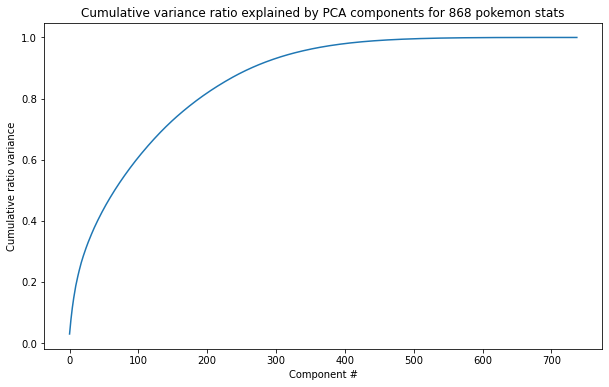

In [32]:
PCAattempt1_nonnumeric = PCAattempt1_df.select_dtypes(include='object', exclude='number')
PCAattempt1_numeric = PCAattempt1_df.select_dtypes(include='number')
PCAattempt1_columns = PCAattempt1_numeric.columns
PCAattempt1_scaled = scale(PCAattempt1_numeric)
PCAattempt1_df_scaled = pd.DataFrame(PCAattempt1_scaled, index=pokemon_df.index, columns=PCAattempt1_columns)
PCAattempt1_fit = PCA().fit(PCAattempt1_df_scaled)

plt.subplots(figsize=(10, 6))
plt.plot(PCAattempt1_fit.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for 868 pokemon stats');

Considering that about 100 components are necessary to explain 60% of the variance, PCA will certainly not be useful given the current state of the data, confirming my intuition and setting us on our way to creating the more clever cindex feature:

<a id="moves_cindex_df"></a>
### Creating the moves_cindex dataframe

To start, we need to make a new json/dictionary to look through, derived from strategies_dict but which has pokemon that don't have any competitive strategies removed.

The "cindex" value for the moves will be calculated as the number of pokemon who use the move competitively (out of the only 4 moves they can use at a time), divided by the number of pokemon who have the move in their learnset. The only way this will work though is if we only consider pokemon who have at least one competitive learnset, because if we divide by the total number of pokemon who have the move in their learnset (including one's who don't have competitive strategies at all, which may be for other reasons than the moves available to them, such as their low stats), then we will be dividing by a larger number than the pokemon we really considered competitive movesets from, which will lead to artificially low numbers for the cindex. Thus, we also need to aggregate the pokemon without competitive strategies and remove them from the calculation (though they can still be considered for cindex features later since they have learnsets of moves, thus we can still evaluate the quality of their moves based on what we find).

In [33]:
cindex_dict = strategies_dict.copy()
pokemon_noncompetitive = []

for pokemon, formatlist in strategies_dict.items():
    if formatlist == []:
        pokemon_noncompetitive.append(pokemon)
        cindex_dict.pop(pokemon)
    else:
        current_pokemon_formats = []
        for formatdict in formatlist:
            formatkey = next(iter(formatdict))
            if formatkey in ranked_formats:
                current_pokemon_formats.append(formatkey)
        if current_pokemon_formats == []:
            pokemon_noncompetitive.append(pokemon)
            cindex_dict.pop(pokemon)

Also, a quick reminder: if you want to better understand the structure of json and thus why I made the code decision I did above, then I recommend putting the contents of the strategies_dict json file into http://jsonviewer.stack.hu/.  Then it will be more obvious why I executed loops, lists, etc. in the way that I chose to, and the code will be less esoteric.

Now we will create the moves_cindex dataframe! The index will be the names of all the moves (contained in the columns of pokemon_learnsets_df), and three columns we want for certain are:
- n_learnset (the number of times each move is in the learnset of pokemon with competitive strategies)
- n_competitive (the number of times each move is actually used competitively by pokemon with competitive strategies)
- cindex (the main purpose of this dataframe, (n_competitive/n_learnset) x 100 to make it a percent value

Let's look at moves_df to see if there any other features that might be useful to include in this dataframe:

In [34]:
moves_df.head()

category  power  accuracy  priority  pp  \
name                                                       
Acid              Special     40       100         0  30   
Amnesia      Non-Damaging      0         0         0  20   
Aurora Beam       Special     65       100         0  20   
Bind             Physical     15        85         0  20   
Bite             Physical     60       100         0  25   

                                               description     type  
name                                                                 
Acid          10% chance to lower the foe(s) Sp. Def by 1.   Poison  
Amnesia                    Raises the user's Sp. Def by 2.  Psychic  
Aurora Beam  10% chance to lower the target's Attack by 1.      Ice  
Bind           Traps and damages the target for 4-5 turns.   Normal  
Bite                 30% chance to make the target flinch.     Dark

- Power is very important to how strong a move is, so will also be a useful numerical feature to work with when understanding how strong the learnset of a pokemon is
- Type is also important to understand the range of "type coverage" each pokemon (the number of types they have available good moves for)
- Category is important (either physical, special, or non-damaging), since we may want to investigate moves separately based on those categories

I can't imagine using the other categories very much, because even though things like accuracy and pp are important in pokemon, they hardly make a move good or bad by themselves (maybe more bad than good)

In [35]:
moves_cindex = pd.DataFrame(0, index=pokemon_learnsets_df.columns, columns=['n_learnset', 'n_competitive', 'cindex'])

for pokemon, formatlist in cindex_dict.items():
    already_checked = []
    for formatdict in formatlist:
        formatkey = next(iter(formatdict))
        if formatkey not in ranked_formats:
            continue
        for movesetlist in formatdict.values():
            for moveset in movesetlist:
                moveset_name = [name for name in moveset.keys() if name != 'abilities'][0]
                for move in moveset[moveset_name]:
                    if move in dup_moves:
                        move = dup_moves_df.loc[move, 'collapse']
                    if move not in already_checked:
                        moves_cindex.loc[move, 'n_competitive'] += 1
                        already_checked.append(move)
                        
for move in pokemon_learnsets_df.columns:
    moves_cindex.loc[move, 'n_learnset'] = pokemon_learnsets_df.drop(index=pokemon_noncompetitive)[move].sum()
    
for move in moves_cindex.index:
    moves_cindex.loc[move, 'power'] = moves_df.loc[move, 'power']
    moves_cindex.loc[move, 'type'] = moves_df.loc[move, 'type']
    moves_cindex.loc[move, 'category'] = moves_df.loc[move, 'category']
    
moves_cindex.head()

n_learnset  n_competitive  cindex  power     type      category
Acid                 15              0       0   40.0   Poison       Special
Amnesia              64              1       0    0.0  Psychic  Non-Damaging
Aurora Beam          17              0       0   65.0      Ice       Special
Bind                 35              0       0   15.0   Normal      Physical
Bite                 96              0       0   60.0     Dark      Physical

Upon futher investigation in [EDA_experiments](./EDA_experiments.ipynb#Unique_Shield) (the Unique Shield section in the table of contents if the link doesn't take you there directly), I found 4 moves (King's Shield, Spiky Shield, Obstruct, Baneful Bunker), all uniquely more powerful versions of the move "Protect" due to their additional effects, to have a more understandable cindex as a single move, since these moves are all only contained by one pokemon, so their cindex alone is unrealistically dramatic (either 100 or 0), but together it is 75 which is more realistic and interpretable due to the increased n_learnset size of 4 (essentially increasing the sample size).

In [36]:
#Unique Shield moves: King's Shield, Spiky Shield, Obstruct, Baneful Bunker
moves_cindex.loc['Unique Shield', ['n_learnset', 'n_competitive']] = moves_cindex.loc[['King\'s Shield', 'Spiky Shield', 'Obstruct', 'Baneful Bunker'], ['n_learnset', 'n_competitive']].sum()
moves_cindex.loc['Unique Shield', 'power'] = 0.0
moves_cindex.loc['Unique Shield', 'type'] = 'Normal' #similar to protect
moves_cindex.loc['Unique Shield', 'category'] = 'Non-Damaging'
moves_cindex.drop(index=['King\'s Shield', 'Spiky Shield', 'Obstruct', 'Baneful Bunker'], inplace=True)
    
moves_cindex.loc['Unique Shield', :]

n_learnset                4.0
n_competitive             3.0
cindex                    NaN
power                     0.0
type                   Normal
category         Non-Damaging
Name: Unique Shield, dtype: object

Now we can populate the dataframe with calculations of the cindex using the n_learnset and n_competitive features:

In [37]:
moves_cindex['cindex'] = 100*(moves_cindex['n_competitive'] / moves_cindex['n_learnset'])

moves_cindex.head(10)

n_learnset  n_competitive      cindex  power      type  \
Acid               15.0            0.0    0.000000   40.0    Poison   
Amnesia            64.0            1.0    1.562500    0.0   Psychic   
Aurora Beam        17.0            0.0    0.000000   65.0       Ice   
Bind               35.0            0.0    0.000000   15.0    Normal   
Bite               96.0            0.0    0.000000   60.0      Dark   
Blizzard          113.0            4.0    3.539823  110.0       Ice   
Bubble Beam        50.0            0.0    0.000000   65.0     Water   
Conversion          2.0            0.0    0.000000    0.0    Normal   
Counter            94.0            1.0    1.063830    0.0  Fighting   
Crabhammer          1.0            1.0  100.000000  100.0     Water   

                 category  
Acid              Special  
Amnesia      Non-Damaging  
Aurora Beam       Special  
Bind             Physical  
Bite             Physical  
Blizzard          Special  
Bubble Beam       Special  
Conversion   Non-Damaging  
Counter          Physical  
Crabhammer       Physical

<a id="abilities_cindex_df"></a>
### Creating the abilities_cindex dataframe

Fortunately this will be even easier than creating moves_cindex, because cindex_dict and pokemon_noncompetitive are already created for us.  Furthermore:

In [38]:
abilities_df.head()

description
name                                                           
Cute Charm    30% chance of infatuating Pokemon of the oppos...
Effect Spore  30% chance of poison/paralysis/sleep on others...
Flame Body    30% chance a Pokemon making contact with this ...
Flash Fire    This Pokemon's Fire attacks do 1.5x damage if ...
Intimidate    On switch-in, this Pokemon lowers the Attack o...

abilities_df doesn't have any other interesting features about abilities that we need to save, like power, type or category, so we really only have the 3 core columns (n_abilityset, the equivalent of n_learnset last time, and n_competitive and cindex, which serve exactly the same purposes as last time)

In [39]:
abilities_cindex = pd.DataFrame(0, index=pokemon_abilities_df.columns, columns=['n_abilityset', 'n_competitive', 'cindex'])

for pokemon, formatlist in cindex_dict.items():
    already_checked = []
    for formatdict in formatlist:
        formatkey = next(iter(formatdict))
        if formatkey not in ranked_formats:
            continue
        for movesetlist in formatdict.values():
            for moveset in movesetlist:
                for ability in moveset['abilities']:
                    if ability in dup_abilities:
                        ability = dup_abilities_df.loc[ability, 'collapse']
                    if ability not in already_checked:
                        abilities_cindex.loc[ability, 'n_competitive'] += 1
                        already_checked.append(ability)
                        
for ability in pokemon_abilities_df.columns:
    abilities_cindex.loc[ability, 'n_abilityset'] = pokemon_abilities_df.drop(index=pokemon_noncompetitive)[ability].sum()

abilities_cindex.head()

n_abilityset  n_competitive  cindex
Cute Charm               6              1       0
Effect Spore             3              2       0
Flame Body               9              6       0
Flash Fire               9              7       0
Intimidate              13              8       0

And we need to add the cindex feature to replace all the 0's:

In [40]:
abilities_cindex['cindex'] = 100*(abilities_cindex['n_competitive'] / abilities_cindex['n_abilityset'])
abilities_cindex.head()

n_abilityset  n_competitive     cindex
Cute Charm               6              1  16.666667
Effect Spore             3              2  66.666667
Flame Body               9              6  66.666667
Flash Fire               9              7  77.777778
Intimidate              13              8  61.538462

As with moves_cindex, there was at least one slight bug I encountered:

In [41]:
abilities_cindex[abilities_cindex['cindex'] > 100]

n_abilityset  n_competitive  cindex
Power Construct             1              2   200.0

We have an ability with above 100 cindex! That's technically impossible, so it must have just proceeded from a mistake or something we overlooked, and it did:

Zygarde-10% (a UU tiered pokemon) technically has the Power Construct ability along with Zygarde (an Uber pokemon which is closely related). The reason I removed it from Zygarde-10% is because the ability is only allowed to be used in Ubers, where Zygarde is used instead of Zygarde-10%. But in strategies_dict, I didn't go through and change that minor detail, and Zygarde-10% does have an Uber moveset even though it isn't really viable there so it's really a UU pokemon which was manually kept at that level when I created tierchange_df. So, I just need to manually change this ability to its appropriate n_competitive (which comes from strategies_dict), namely changing it back to 1 instead of 2, then re-do the calculations and everything should be fixed.

In [42]:
abilities_cindex.loc['Power Construct', 'n_competitive'] = 1
abilities_cindex['cindex'] = 100*(abilities_cindex['n_competitive'] / abilities_cindex['n_abilityset'])
abilities_cindex.head()

n_abilityset  n_competitive     cindex
Cute Charm               6              1  16.666667
Effect Spore             3              2  66.666667
Flame Body               9              6  66.666667
Flash Fire               9              7  77.777778
Intimidate              13              8  61.538462

<a id="role_features"></a>
### Investigating Roles for Features

Before, we start investigating moves_cindex and using it for aggregate features, it's best to see if there are any more distinctive features I want to create first, and there are a lot I want to try. Since many of these moves will be distinct features, they don't need to be treated as moves in moves_cindex which have to be aggregated, so that way we can take out very important things to be sure they get noticed and not lost in the aggregation, while also making our aggregation more focused.

To see which roles are typically used competitively in pokemon, I looked at these resources (the role compendiums for each tier in competitive pokemon and which pokemon typically play those roles) which gave great information:

- https://www.smogon.com/forums/threads/ss-ou-role-compendium.3657644/
- https://www.smogon.com/forums/threads/ss-uu-role-compendium-20-07-2021-update-see-post-50.3659197/
- https://www.smogon.com/forums/threads/ss-ru-role-compendium.3660895/
- https://www.smogon.com/forums/threads/ss-nu-role-compendium-updated-09-2021.3664555/
- https://www.smogon.com/forums/threads/ss-pu-resources-thread-sample-submissions-open.3662279/#post-8421304
- https://www.smogon.com/forums/threads/ss-zu-resources-hub.3665776/#post-8502699

The 4 broader roles are Utility, Offensive, Defensive and Weather.

Within each of those there are a lot of specific roles that we can learn about in such a way that we could turn them into features!

**Utility breaks down into:**
- Entry Hazards
- Hazard Control
- Clerics and Wish
- Other

Utility: Entry Hazards
- Spikes
- Stealth Rock
- Sticky Web
- Toxic Spikes
- Suicide Lead

Utility: Hazard Control
- Defog
- Magic Bounce
- Rapid Spin
- Spinblocker
- Defog Deterrant

Utility: Clerics and Wish
- Heal Bell/Aromatherapy/Jungle Healing
- Healing Wish/Lunar Dance
- Wish

Utility: Other
- Knock Off/Corrosive Gas
- Switcheroo/Trick
- Screen Setter
- Aurora Veil (may be something like screen setter, or weather abuse)
- Status Absorber (Natural Cure, Shed Skin, etc.)
- Unaware
- VoltTurn (Flip Turn, U-turn, or Volt Switch)
- Teleport
- Parting Shot (may fit "defensive pivot" with teleport, but VoltTurn also can be, I might even put all 5 of those together though some are obviously better so not sure)
- Trapper (Anchor Shot, Spirit Shackle, Magnet Pull)
- Taunt (may relate to things like Suicide Lead and Stallbreaker)
- Substitute
- Phazer (Roar, Dragon Tail, Whirlwind, Circle Throw)
- Memento (could arguably go with Healing Wish, as a sacrifice move)
- Toxic
- Will-o-wisp
- Paralysis/Thunder Wave
- Sleep
- Encore
- Tailwind
- Haze/Clear Smog

Offensive:
- Physical Wallbreaker
- Special Wallbreaker (mixed is not necessary since it's represented by any pokemon high on both)
- Choice items (these may not be necessary as roles, because items are to be inferred rather than directly used, and otherwise these pokemon are usually just sweepers, except maybe the scarf, maybe split into choice attacker vs doing something else with the choice [usually scarf])
- Setup Sweepers (need to space out these moves, some may be defensive)
- Priority users (may need to split this up, including some maybe in weather, and considering abilities like Technician)
- Stallbreaker (not sure what this will have: usually taunt and setup it seems, and setup may be a separate thing so Taunt may already capture this, maybe perish song as well and other phazing moves, though those are also stalling tactics so not sure, definitely taunt though)

Defensive:
- Physical Wall/Tank
- Special Wall/Tank

Weather:
- Weather/Terrain Setters
- Weather/Terrain Speedsters
- Weather Advantage? (Sand Veil, other abusers?, maybe make this into a stat that makes speeders a 2 and pokemon with weather advantage moves/type as a 1, or maybe even up to 3 taking into account type, moveset and speed gain and maybe other advantages as well)
- Trick Room

One other thing that would be useful is a dictionary of the competitive roles and a list of their names from strategies_dict. Although it is not as well organized and split neatly into the roles we're actually going to use above, it still may offer some insight.

In [43]:
roles_dict = {}
for pokemon, formatlist in strategies_dict.items():
    for formatdict in formatlist:
        formatkey = next(iter(formatdict))
        if formatkey not in ranked_formats:
            continue
        for movesetlist in formatdict.values():
            for moveset in movesetlist:
                role_dict = {}
                role_dict['name'] = pokemon
                role_dict['format'] = formatkey
                role_dict['abilities'] = moveset['abilities']
                role = [name for name in moveset.keys() if name != 'abilities'][0]
                role_dict['moveset'] = moveset[role]
                if role not in roles_dict.keys():
                    roles_dict[role] = [role_dict]
                else:
                    roles_dict[role].append(role_dict)
                    
roles_list = sorted(list(roles_dict.keys()))
roles_list

['3 Attacks + Roost',
 '3 Attacks Roost',
 'Agility',
 'All Out Attacker',
 'All-Out Attacker',
 'All-Out-Attacker',
 'All-out Attacker',
 'Assault Vest',
 'Aurora Veil',
 'Autotomize',
 'Autotomize Sweeper',
 'Belly Drum',
 'Breaker',
 'Bulk Up',
 'Bulky Booster',
 'Bulky Calm Mind',
 'Bulky Pivot',
 'Bulky Quiver Dance',
 'Bulky Setup Sweeper',
 'Bulky Swords Dance',
 'Bulky Utility',
 'Calm Mind',
 'Chlorophyll Sweeper',
 'Choice',
 'Choice Attacker',
 'Choice Band',
 'Choice Scarf',
 'Choice Scarf Cleaner',
 'Choice Scarf Trapper',
 'Choice Specs',
 'Choiced Attacker',
 'Clangorous Soul',
 'Cleric',
 'Cosmic Power',
 'Cosmic Power + Stored Power',
 'Cotton Guard',
 'CritDra',
 'Crocune',
 'Curselax',
 'DAT LOUD',
 'Defensive',
 'Defensive Calm Mind',
 'Defensive Calm Mind + Recover',
 'Defensive Dragon Dance',
 'Defensive Pivot',
 'Defensive Spikes',
 'Defensive Spinner',
 'Defensive Stealth Rock',
 'Defensive Strength Sap',
 'Defensive Support',
 'Defensive Utility',
 'Defog',
 'D

And finally, we need a dataframe to hold the new features we're going to make out of these roles. Fittingly, we'll call it shrinkfeatures_df. We'll also check out the percentiles of the "cindex" column of moves_cindex so that we can recognize a good (and not-so-good) move when we see one (and the same for abilities_cindex).

In [44]:
shrinkfeatures_df = pd.DataFrame(index=pokemon_df.index)

moves_cindex['cindex'].describe(percentiles = [n/20 for n in range(1, 20)])

count    620.000000
mean      18.326995
std       30.865630
min        0.000000
5%         0.000000
10%        0.000000
15%        0.000000
20%        0.000000
25%        0.000000
30%        0.000000
35%        0.000000
40%        0.000000
45%        0.000000
50%        1.223253
55%        3.023897
60%        5.736264
65%       10.229529
70%       15.076271
75%       21.428571
80%       33.333333
85%       48.000000
90%       77.155844
95%      100.000000
max      100.000000
Name: cindex, dtype: float64

In [45]:
abilities_cindex['cindex'].describe(percentiles = [n/20 for n in range(1, 20)])

count    215.000000
mean      55.873363
std       42.280529
min        0.000000
5%         0.000000
10%        0.000000
15%        0.000000
20%        0.000000
25%        0.000000
30%       14.761905
35%       33.333333
40%       50.000000
45%       50.000000
50%       64.285714
55%       75.000000
60%       85.714286
65%      100.000000
70%      100.000000
75%      100.000000
80%      100.000000
85%      100.000000
90%      100.000000
95%      100.000000
max      100.000000
Name: cindex, dtype: float64

<a id="utility_entry"></a>
### Utility: Entry Hazards

- Spikes
- Stealth Rock
- Sticky Web
- Toxic Spikes
- Suicide Lead

Entry Hazards are mostly moves, so I have the choice to represent each move as a separate feature, to combine them into a single one-hot encoded feature, or to combine them into a single feature with values 0-4 (based on how many entry hazards a pokemon has or ranked based on how good their best hazard is).

Suicide Lead is trickier since it's not a move, and I should probably investigate it to see what it implies.

So first I'll look at what the role list has to say about these moves, then examine them in moves_cindex and the role_dict. The only Entry Hazard without a uniquely listed role in roles_list is Toxic Spikes.  But first let's look at them in moves_cindex:

In [46]:
moves_cindex.loc[['Spikes', 'Toxic Spikes', 'Stealth Rock', 'Sticky Web'], :]

n_learnset  n_competitive      cindex  power    type  \
Spikes              22.0           20.0   90.909091    0.0  Ground   
Toxic Spikes        24.0           12.0   50.000000    0.0  Poison   
Stealth Rock        91.0           71.0   78.021978    0.0    Rock   
Sticky Web           6.0            6.0  100.000000    0.0     Bug   

                  category  
Spikes        Non-Damaging  
Toxic Spikes  Non-Damaging  
Stealth Rock  Non-Damaging  
Sticky Web    Non-Damaging

These are all pretty great moves, above 85 percentile for all and some far above that. I originally planned on making the entry hazard hazard based on how many of those 4 moves the pokemon has, but the slight problem is that Stealth Rock has a strong correlation with the rock type, so the feature ended up being largely dominated by that since Stealth Rock is in so many more learnsets than the other entry hazards (and while Stealth Rock is very good, it isn't the best on there by far). To restrict Stealth Rock's rock correlation from dominating the feature, I found it better to make the feature into a hierarchy where 0 means having none of the moves, 1 means having toxic spikes, 2 means having Stealth Rock, 3 means having Spikes and 4 means having Sticky Web (and having played against Sticky Web in Pokemon Showdown personally, I can see why it's the highest one on here, it can easily win games if not checked).

The score for each pokemon on this feature will just be the highest one they have, so we'll input the lower values first so that the higher values replace the lower one's if the pokemon has both.

In [47]:
#Utility: Entry Hazards
shrinkfeatures_df['Entry Hazards'] = 0
shrinkfeatures_df.loc[pokemon_learnsets_df['Toxic Spikes'] == 1, 'Entry Hazards'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Stealth Rock'] == 1, 'Entry Hazards'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Spikes'] == 1, 'Entry Hazards'] = 3
shrinkfeatures_df.loc[pokemon_learnsets_df['Sticky Web'] == 1, 'Entry Hazards'] = 4
moves_cindex.drop(index=['Spikes', 'Toxic Spikes', 'Stealth Rock', 'Sticky Web'], inplace=True)

shrinkfeatures_df['Entry Hazards'].value_counts()

0    537
2    128
3     38
1     21
4     14
Name: Entry Hazards, dtype: int64

Now let's use roles_dict to investigate Suicide Lead:

In [48]:
roles_dict['Suicide Lead']

[{'name': 'Mew',
  'format': 'UU',
  'abilities': ['Synchronize'],
  'moveset': ['Spikes', 'Stealth Rock', 'Taunt', 'Explosion']},
 {'name': 'Mew',
  'format': 'OU',
  'abilities': ['Synchronize'],
  'moveset': ['Stealth Rock', 'Spikes', 'Taunt', 'Flare Blitz']},
 {'name': 'Froslass',
  'format': 'ZU',
  'abilities': ['Cursed Body'],
  'moveset': ['Spikes', 'Ice Beam', 'Taunt', 'Destiny Bond']},
 {'name': 'Archeops',
  'format': 'PU',
  'abilities': ['Defeatist'],
  'moveset': ['Head Smash', 'Earthquake', 'Taunt', 'Stealth Rock']},
 {'name': 'Accelgor',
  'format': 'ZU',
  'abilities': ['Unburden'],
  'moveset': ['Spikes', 'Final Gambit', 'Encore', 'Yawn', 'Infestation']}]

What's notable here is that all of these pokemon have other entry hazard moves, so "Suicide Lead" probably doesn't need to have its own separate feature.  

There are some moves like Explosion, high recoil moves (e.g. Flare Blitz, Head Smash), Final Gambit and Destiny Bond which are used with high frequency, but they don't seem very common so it's hard to consider them as a feature for entry hazard even though they might be individually good in these cases.  Encore, Yawn and Infestation are something different.

There is one more notable fact though: almost all of these pokemon have Taunt.  So we have to consider whether including that as a feature or as part of  the Entry Hazard kit.

Let's investigate these moves in the cindex:

In [49]:
moves_cindex.loc[['Explosion', 'Flare Blitz', 'Destiny Bond', 'Head Smash', 'Final Gambit', 'Taunt'], :]

n_learnset  n_competitive     cindex  power      type  \
Explosion           61.0           11.0  18.032787  250.0    Normal   
Flare Blitz         27.0           13.0  48.148148  120.0      Fire   
Destiny Bond        29.0            4.0  13.793103    0.0     Ghost   
Head Smash          15.0            4.0  26.666667  150.0      Rock   
Final Gambit        10.0            2.0  20.000000    0.0  Fighting   
Taunt              134.0           29.0  21.641791    0.0      Dark   

                  category  
Explosion         Physical  
Flare Blitz       Physical  
Destiny Bond  Non-Damaging  
Head Smash        Physical  
Final Gambit       Special  
Taunt         Non-Damaging

None of these moves seem important to make special features. Flare Blitz is a generally quite strong attack so no wonder Mew uses it. Explosion, Head Smash, Final Gambit and Destiny Bond are competitive but only decent moves, certainly nothing that could justify their own feature. Overall those moves can all be ignored as separate roles for now.

Taunt is used with particularly high frequency though, which is the notable thing about it, in spite of only being only in the 25% of moves (keep in mind that about half of moves are complete garbage competitively), which makes it a middling competitive move.  Since we want to investigate Hazard Lead anyways, it would be interesting to see if Taunt shows up there to so we can see how unique it is to Suicide Lead:

In [50]:
roles_dict['Hazard Lead']

[{'name': 'Froslass',
  'format': 'Uber',
  'abilities': ['Cursed Body'],
  'moveset': ['Icy Wind', 'Shadow Ball', 'Spikes', 'Taunt', 'Destiny Bond']},
 {'name': 'Excadrill',
  'format': 'Uber',
  'abilities': ['Mold Breaker'],
  'moveset': ['Stealth Rock',
   'Rapid Spin',
   'Rock Tomb',
   'Earthquake',
   'Toxic']}]

We again see Froslass with Taunt, using Destiny Bond to boot, but Destiny Bond seems uniquely useful to that pokemon so doesn't seem justifiable to do anything special with. Excadrill has no Taunt though. Maybe we should look at some other entry hazard roles and see how much Taunt they have:

In [51]:
roles_dict['Spikes']

[{'name': 'Qwilfish',
  'format': 'PU',
  'abilities': ['Intimidate'],
  'moveset': ['Spikes',
   'Taunt',
   'Waterfall',
   'Thunder Wave',
   'Poison Jab',
   'Destiny Bond']},
 {'name': 'Roserade',
  'format': 'RU',
  'abilities': ['Natural Cure'],
  'moveset': ['Spikes',
   'Giga Drain',
   'Leaf Storm',
   'Sludge Bomb',
   'Synthesis',
   'Sleep Powder']},
 {'name': 'Froslass',
  'format': 'PU',
  'abilities': ['Cursed Body'],
  'moveset': ['Spikes', 'Taunt', 'Ice Beam', 'Shadow Ball']},
 {'name': 'Klefki',
  'format': 'RU',
  'abilities': ['Prankster'],
  'moveset': ['Spikes', 'Dazzling Gleam', 'Thunder Wave', 'Toxic']},
 {'name': 'Klefki',
  'format': 'UU',
  'abilities': ['Prankster'],
  'moveset': ['Play Rough', 'Spikes', 'Thunder Wave', 'Foul Play', 'Toxic']}]

In [52]:
roles_dict['Stallbreaker']

[{'name': 'Skuntank',
  'format': 'ZU',
  'abilities': ['Aftermath'],
  'moveset': ['Nasty Plot',
   'Sludge Bomb',
   'Dark Pulse',
   'Taunt',
   'Fire Blast']}]

I also looked at Utility and Stealth Rocks, which you can view in [EDA_experiments](./EDA_experiments.ipynb#utility_stealth_rocks) in the "utility and stealth rocks in roles_dict" section if you want since they were unnecessarily lengthy for this more polished notebook. Overall, it's used a lot in these entry hazard roles, but about half the time or even less.

There are some problems with Taunt as a separate role though, namely a not super high cindex (though not low of course), high correlation with the dark type, plus only sometimes being used in these utility roles. It wasn't significant enough as a feature, so I later decided to include in the aggregation of miscellaneous status moves.

<a id="hazard_control"></a>
### Utility: Hazard Control

- Defog
- Magic Bounce
- Rapid Spin
- Spinblocker
- Defog Deterrant

Defog and Rapid Spin are moves, Magic Bounce is an ability and Defog Deterrant generally comes down to specific abilities (Defiant/Contrary/Competitive), and Spinblocker is a side effect of being Ghost type.

In [53]:
moves_cindex.loc[['Defog', 'Rapid Spin'], :]

n_learnset  n_competitive     cindex  power    type      category
Defog             90.0           53.0  58.888889    0.0  Flying  Non-Damaging
Rapid Spin        24.0           21.0  87.500000   50.0  Normal      Physical

In [54]:
abilities_cindex.loc[['Magic Bounce', 'Defiant', 'Contrary', 'Competitive'], :]

n_abilityset  n_competitive      cindex
Magic Bounce             4              4  100.000000
Defiant                  9              8   88.888889
Contrary                 2              1   50.000000
Competitive              6              5   83.333333

I think I'm going to make two features here.

- The 1st is "Hazard Removal", which will include Rapid Spin, Defog and Magic Bounce. Although Magic Bounce doesn't technically remove hazards, it makes setting them impossible and even throws them back at the opponent on a switch in, and it's a passive ability which is always active as opposed to Defog and Rapid Spin which you have to waste a turn using.  Magic Bounce is a very rare and powerful ability so it deserves to be a "2" on this feature, whereas having Defog or Rapid Spin will be a "1"

- The 2nd is "Removal Deterrent", which are the 3 other abilities which deter people from removing hazards that have ALREADY been set, rather than removing or deterring the new setting of hazards. Any pokemon with those abilities will have a 2 in the feature, whereas any pokemon with a ghost type will have a 1 since they can block Rapid Spin (since Rapid Spin is rarer than Defog, being ghost type isn't as good as those abilities, plus if I set ghost on an equal level to the abilities, then this feature just ends up correlating with ghost type which makes it less useful)

In [55]:
#Utility: Hazard Control (pd.where is being used to one-hot encode here)
shrinkfeatures_df['Hazard Removal'] = pokemon_learnsets_df.loc[:, ['Rapid Spin', 'Defog']].sum(axis=1)
shrinkfeatures_df.loc[:, 'Hazard Removal'].where(shrinkfeatures_df['Hazard Removal'] <= 1, 1, inplace=True)
moves_cindex.drop(index=['Rapid Spin', 'Defog'], inplace=True)
shrinkfeatures_df.loc[pokemon_abilities_df['Magic Bounce'] == 1, 'Hazard Removal'] = 2

shrinkfeatures_df['Hazard Removal'].value_counts()

0    558
1    174
2      6
Name: Hazard Removal, dtype: int64

In [56]:
shrinkfeatures_df['Removal Deterrent'] = 0
shrinkfeatures_df.loc[pokemon_types_df['Ghost'] == 1, 'Removal Deterrent'] = 1
shrinkfeatures_df.loc[pokemon_abilities_df['Defiant'] == 1, 'Removal Deterrent'] = 2
shrinkfeatures_df.loc[pokemon_abilities_df['Contrary'] == 1, 'Removal Deterrent'] = 2
shrinkfeatures_df.loc[pokemon_abilities_df['Competitive'] == 1, 'Removal Deterrent'] = 2

shrinkfeatures_df['Removal Deterrent'].value_counts()

0    654
1     59
2     25
Name: Removal Deterrent, dtype: int64

<a id="utility_clerics"></a>
### Utility: Clerics and Wish

- Heal Bell/Aromatherapy/Jungle Healing
- Healing Wish/Lunar Dance/Memento
- Wish

I realize now that I may have made a slight mistake in collapsing Lunar Dance and Healing Wish together as they are VERY similar, but Lunar Dance also heals PP.  While they may relate together in a feature, since I respected the subtle difference in Heal Bell/Aromatherapy, it only seems natural to do the same for Healing Wish and Lunar Dance.  The only problem is that I may have to redo some things.  Not sure though, since changing a single move is unlikely to affect my choices in the analysis above, even though it affects them slightly.  I was going to examine the distros again briefly anyways to find the exact final cutoffs), so it's probably worth fixing this before I do that (for now I'll just leave it)

In [57]:
moves_cindex.loc[['Heal Bell', 'Aromatherapy', 'Jungle Healing', 'Lunar Dance', 'Memento', 'Wish'], :]

n_learnset  n_competitive      cindex  power     type  \
Heal Bell             39.0           15.0   38.461538    0.0   Normal   
Aromatherapy          27.0            6.0   22.222222    0.0    Grass   
Jungle Healing         1.0            1.0  100.000000    0.0    Grass   
Lunar Dance           19.0           10.0   52.631579    0.0  Psychic   
Memento               23.0            4.0   17.391304    0.0     Dark   
Wish                  34.0           15.0   44.117647    0.0   Normal   

                    category  
Heal Bell       Non-Damaging  
Aromatherapy    Non-Damaging  
Jungle Healing  Non-Damaging  
Lunar Dance     Non-Damaging  
Memento         Non-Damaging  
Wish            Non-Damaging

In [58]:
roles_dict['Cleric']

[{'name': 'Umbreon',
  'format': 'RU',
  'abilities': ['Synchronize'],
  'moveset': ['Wish', 'Protect', 'Heal Bell', 'Foul Play']},
 {'name': 'Glaceon',
  'format': 'PU',
  'abilities': ['Snow Cloak'],
  'moveset': ['Wish', 'Protect', 'Heal Bell', 'Freeze-Dry']},
 {'name': 'Sylveon',
  'format': 'UU',
  'abilities': ['Pixilate'],
  'moveset': ['Hyper Voice', 'Wish', 'Protect', 'Heal Bell', 'Mystical Fire']},
 {'name': 'Sylveon',
  'format': 'RU',
  'abilities': ['Pixilate'],
  'moveset': ['Hyper Voice', 'Wish', 'Protect', 'Heal Bell']}]

This is a trickier decision because these moves aren't generally as good as what we've encountered previously.

Lunar Dance/Healing Wish seems like a powerful tactic, and Wish also seems like a common and useful kit.  Heal Bell/Aromatherapy are borderline and often seem to be used alongside Wish (and thus in many cases don't contain much information), either that or it's only an option alongside other moves. Jungle Healing is another rather unique move in that it doesn't heal as much as the normal recovery options like Recover or Roost, but acts as Heal Bell or Aromatherapy (so I may include it in that feature, but as a "2" instead of a "1"), since it acts in a similar way to wish and is just superior to heal bell/aromatherapy

There is another option for Heal Bell/Aromatherapy, which is having a one one-hot encoded feature for having at least one of those, another for having wish, and another for having healing wish/lunar dance, and then combine the one-hot encoded features into a single cleric feature from 0 to 3 (and if I aggregate in this way, there's no need to go back and fix Lunar Dance and Healing Wish since they'll be aggregated anyways). These are different moves so having more than one of these cleric moves can make a significant difference in one's ability to play a cleric. Plus, the individual moves probably don't mean a lot alone since they are overall focused on something narrow and not very informative, so it's better to aggregate to get something more meaningful at scale.

Memento is a lot more situational and not as related to the main cleric moves, so it won't be included here, but I will aggregate it into miscellaneous status moves later.

In [59]:
shrinkfeatures_df['Party Heal'] = pokemon_learnsets_df.loc[:, ['Heal Bell', 'Aromatherapy']].sum(axis=1)
shrinkfeatures_df.loc[:, 'Party Heal'].where(shrinkfeatures_df['Party Heal'] <= 1, 1, inplace=True)
shrinkfeatures_df.loc[pokemon_learnsets_df['Jungle Healing'] == 1, 'Party Heal'] = 2
moves_cindex.drop(index=['Heal Bell', 'Aromatherapy', 'Jungle Healing'], inplace=True)

shrinkfeatures_df['Party Heal'].value_counts()

0    648
1     89
2      1
Name: Party Heal, dtype: int64

In [60]:
shrinkfeatures_df['Setup Support'] = pokemon_learnsets_df['Lunar Dance']
moves_cindex.drop(index='Lunar Dance', inplace=True)

shrinkfeatures_df['Setup Support'].value_counts()

0    709
1     29
Name: Setup Support, dtype: int64

In [61]:
shrinkfeatures_df['Wish'] = pokemon_learnsets_df['Wish']
moves_cindex.drop(index='Wish', inplace=True)

shrinkfeatures_df['Wish'].value_counts()

0    684
1     54
Name: Wish, dtype: int64

In [62]:
#Utility: Clerics and Wish
shrinkfeatures_df['Cleric'] = shrinkfeatures_df.loc[:, ['Party Heal', 'Setup Support', 'Wish']].sum(axis=1)
shrinkfeatures_df.drop(columns=['Party Heal', 'Setup Support', 'Wish'], inplace=True)

shrinkfeatures_df['Cleric'].value_counts()

0    616
1     76
2     40
3      6
Name: Cleric, dtype: int64

<a id="utility_other"></a>
### Utility: Other

- Knock Off/Corrosive Gas
- Switcheroo/Trick
- Screen Setter
- Aurora Veil (may be something like screen setter, or weather abuse)
- Status Absorber (Natural Cure, Shed Skin, etc.)
- Unaware
- VoltTurn (Flip Turn, U-turn, or Volt Switch)
- Teleport
- Parting Shot (may fit "defensive pivot" with teleport, but VoltTurn also can be, I might even put all 5 of those together though some are obviously better so not sure)
- Trapper (Anchor Shot, Spirit Shackle, Magnet Pull)
- Substitute
- Phazer (Roar, Dragon Tail, Whirlwind, Circle Throw)
- Toxic
- Will-o-wisp
- Paralysis/Thunder Wave
- Sleep
- Encore
- Tailwind
- Haze/Clear Smog

In [63]:
moves_cindex.loc[['Knock Off', 'Corrosive Gas', 'Trick', 'Reflect', 'Light Screen', 'Aurora Veil', 'Flip Turn', 'U-turn', 'Volt Switch', 'Teleport', 'Parting Shot', 'Anchor Shot', 'Spirit Shackle', 'Substitute', 'Roar', 'Dragon Tail', 'Whirlwind', 'Circle Throw', 'Toxic', 'Will-O-Wisp', 'Thunder Wave', 'Stun Spore', 'Glare', 'Spore', 'Sing', 'Lovely Kiss', 'Hypnosis', 'Sleep Powder', 'Encore', 'Tailwind', 'Haze', 'Clear Smog', 'Yawn', 'Perish Song'], :].sort_values(by='cindex')

n_learnset  n_competitive      cindex  power      type  \
Sing                  28.0            0.0    0.000000    0.0    Normal   
Anchor Shot            1.0            0.0    0.000000   80.0     Steel   
Tailwind              68.0            2.0    2.941176    0.0    Flying   
Reflect              164.0            6.0    3.658537    0.0   Psychic   
Light Screen         153.0            6.0    3.921569    0.0   Psychic   
Roar                 106.0            7.0    6.603774    0.0    Normal   
Perish Song           14.0            1.0    7.142857    0.0    Normal   
Hypnosis              34.0            3.0    8.823529    0.0   Psychic   
Dragon Tail           53.0            6.0   11.320755   60.0    Dragon   
Substitute           414.0           50.0   12.077295    0.0    Normal   
Clear Smog            14.0            2.0   14.285714   50.0    Poison   
Corrosive Gas         13.0            2.0   15.384615    0.0    Poison   
Encore                65.0           10.0   15.384615    0.0    Normal   
Whirlwind             22.0            4.0   18.181818    0.0    Normal   
Haze                  42.0            8.0   19.047619    0.0       Ice   
Yawn                  42.0            9.0   21.428571    0.0    Normal   
Aurora Veil           14.0            3.0   21.428571    0.0       Ice   
Thunder Wave         144.0           36.0   25.000000    0.0  Electric   
Stun Spore            15.0            4.0   26.666667    0.0     Grass   
Circle Throw           7.0            2.0   28.571429   60.0  Fighting   
Toxic                350.0          124.0   35.428571    0.0    Poison   
Trick                 98.0           37.0   37.755102    0.0   Psychic   
Will-O-Wisp           68.0           26.0   38.235294    0.0      Fire   
Teleport              32.0           14.0   43.750000    0.0   Psychic   
Parting Shot          18.0            8.0   44.444444    0.0      Dark   
Glare                  5.0            3.0   60.000000    0.0    Normal   
Sleep Powder          13.0            8.0   61.538462    0.0     Grass   
Flip Turn             17.0           12.0   70.588235   60.0     Water   
Knock Off            119.0           87.0   73.109244   65.0      Dark   
Volt Switch           35.0           27.0   77.142857   70.0  Electric   
U-turn                89.0           70.0   78.651685   70.0       Bug   
Lovely Kiss            1.0            1.0  100.000000    0.0    Normal   
Spirit Shackle         1.0            1.0  100.000000   80.0     Ghost   
Spore                  2.0            2.0  100.000000    0.0     Grass   

                    category  
Sing            Non-Damaging  
Anchor Shot         Physical  
Tailwind        Non-Damaging  
Reflect         Non-Damaging  
Light Screen    Non-Damaging  
Roar            Non-Damaging  
Perish Song     Non-Damaging  
Hypnosis        Non-Damaging  
Dragon Tail         Physical  
Substitute      Non-Damaging  
Clear Smog           Special  
Corrosive Gas   Non-Damaging  
Encore          Non-Damaging  
Whirlwind       Non-Damaging  
Haze            Non-Damaging  
Yawn            Non-Damaging  
Aurora Veil     Non-Damaging  
Thunder Wave    Non-Damaging  
Stun Spore      Non-Damaging  
Circle Throw        Physical  
Toxic           Non-Damaging  
Trick           Non-Damaging  
Will-O-Wisp     Non-Damaging  
Teleport        Non-Damaging  
Parting Shot    Non-Damaging  
Glare           Non-Damaging  
Sleep Powder    Non-Damaging  
Flip Turn           Physical  
Knock Off           Physical  
Volt Switch          Special  
U-turn              Physical  
Lovely Kiss     Non-Damaging  
Spirit Shackle      Physical  
Spore           Non-Damaging

There's a lot going on here so let's analyze it one at a time. We can start with a pivot feature, which I saw a lot when I actually tried playing Pokemon Showdown.

U-Turn, Volt Switch and Flip Turn are all very powerful pivot moves (and all on a pretty similar playing field). Parting Shot is a less powerful pivot move which lowers stats instead of doing damage, but it's still a quality move so deserves to be included in a lower tier of this feature. And Teleport is another pivot move which has no effect on the opponent and purely switches, but it also isn't terrible perhaps since it can offer safe switch-in's when desired. So, as with before we'll have a hierarchy where Teleport is 1, Parting Shot is 2, and the others are 3.

In [64]:
#Utility: Pivot
shrinkfeatures_df['Pivot'] = 0
shrinkfeatures_df.loc[pokemon_learnsets_df['Teleport'] == 1, 'Pivot'] = 1
moves_cindex.drop(index='Teleport', inplace=True)
shrinkfeatures_df.loc[pokemon_learnsets_df['Parting Shot'] == 1, 'Pivot'] = 2
moves_cindex.drop(index='Parting Shot', inplace=True)
shrinkfeatures_df.loc[pokemon_learnsets_df['U-turn'] == 1, 'Pivot'] = 3
shrinkfeatures_df.loc[pokemon_learnsets_df['Volt Switch'] == 1, 'Pivot'] = 3
shrinkfeatures_df.loc[pokemon_learnsets_df['Flip Turn'] == 1, 'Pivot'] = 3
moves_cindex.drop(index=['U-turn', 'Volt Switch', 'Flip Turn'], inplace=True)

shrinkfeatures_df['Pivot'].value_counts()

0    487
3    209
1     37
2      5
Name: Pivot, dtype: int64

Next, we have an idea for an item removal feature, which contains Knock Off and Corrosive Gas.  Knock off is a very strong, while Corrosive Gas is only barely competitive (which makes sense since it doesn't do damage, while Knock Off is also a damaging attack with basically the same effect). So Knock Off will be 2 and Corrosive Gas will be 1.

In [65]:
#Utility: Item Removal
shrinkfeatures_df['Item Removal'] = 0
shrinkfeatures_df.loc[pokemon_learnsets_df['Corrosive Gas'] == 1, 'Item Removal'] = 1
moves_cindex.drop(index='Corrosive Gas', inplace=True)
shrinkfeatures_df.loc[pokemon_learnsets_df['Knock Off'] == 1, 'Item Removal'] = 2
moves_cindex.drop(index='Knock Off', inplace=True)

shrinkfeatures_df['Item Removal'].value_counts()

0    548
2    182
1      8
Name: Item Removal, dtype: int64

Besides those pretty straightforward features, others are far more questionable.

You could make features around Sleep moves, Burn moves, Poison moves and Paralysis moves, but I tried in the experiments to create a feature for each status condition move a pokemon could use and it didn't go well; the features were very unimportant.

Likewise, other moves like Trick, Light Screen, Reflect, Substitute, Roar, Dragon Tail, Whirlwind, Circle Throw, Encore, Tailwind, Haze, Smog, etc. may occasionally be nice, but they just aren't good enough to be their own feature and have any feature importance in the models (I tested this), but that doesn't mean they should be thrown away entirely.

Some of these moves are problematic for another reason: they are so common (ergo, their n_learnset is so high) that most pokemon have access to the move. And no matter how good or bad such moves are, they give the model nearly no information if most pokemon have access to them, since the model can only work with their static stats like their learnset (it doesn't know anything about which pokemon actually use the move since we can't use this model predictively if we require more than the static stats of the pokemon, since new pokemon will have had no competitive use no matter how good they are). We should get rid of these moves from moves_cindex, and some of those moves are listed above (such as Toxic and Substitute), but we will deal with that later.

Aurora Veil is useful in niche situations, but it's a weather related feature so we will deal with it in that category.

Unaware is a rare and quite middling ability in terms of cindex, so making it a separate feature would be absurd

In [66]:
#binding moves
moves_cindex.loc[['Bind', 'Sand Tomb', 'Snap Trap', 'Wrap', 'Fire Spin', 'Infestation', 'Magma Storm', 'Thunder Cage', 'Whirlpool'], :].sort_values(by='cindex')

n_learnset  n_competitive      cindex  power      type  category
Bind                35.0            0.0    0.000000   15.0    Normal  Physical
Snap Trap            1.0            0.0    0.000000   35.0     Grass  Physical
Wrap                13.0            0.0    0.000000   15.0    Normal  Physical
Thunder Cage         1.0            0.0    0.000000   80.0  Electric   Special
Whirlpool           76.0            0.0    0.000000   35.0     Water   Special
Infestation         46.0            1.0    2.173913   20.0       Bug   Special
Sand Tomb           40.0            1.0    2.500000   35.0    Ground  Physical
Fire Spin           35.0            2.0    5.714286   35.0      Fire   Special
Magma Storm          1.0            1.0  100.000000  100.0      Fire   Special

In [67]:
#trapping moves
moves_cindex.loc[['Anchor Shot', 'Jaw Lock', 'Spirit Shackle', 'Thousand Waves', 'Block', 'Fairy Lock', 'No Retreat', 'Octolock'], :].sort_values(by='cindex')

n_learnset  n_competitive      cindex  power      type  \
Anchor Shot            1.0            0.0    0.000000   80.0     Steel   
Jaw Lock               1.0            0.0    0.000000   80.0      Dark   
Fairy Lock             1.0            0.0    0.000000    0.0     Fairy   
Octolock               1.0            0.0    0.000000    0.0  Fighting   
Block                 95.0            1.0    1.052632    0.0    Normal   
Spirit Shackle         1.0            1.0  100.000000   80.0     Ghost   
Thousand Waves         2.0            2.0  100.000000   90.0    Ground   
No Retreat             1.0            1.0  100.000000    0.0  Fighting   

                    category  
Anchor Shot         Physical  
Jaw Lock            Physical  
Fairy Lock      Non-Damaging  
Octolock        Non-Damaging  
Block           Non-Damaging  
Spirit Shackle      Physical  
Thousand Waves      Physical  
No Retreat      Non-Damaging

The only binding and trapping moves that are good are uniquely powerful moves (moves with perfect cindex but very low n_learnset), so they will get their due in the feature for unique powerful moves. The others are garbage and not even close to worth being made into a feature.

Status Absorber and Trapper abilities were already collapsed together in dup_abilities, since they do give some good information together, but they are too niche and rare to make for individual features which have any consistent feature importance in models.

<a id="offense_setup"></a>
### Offensive: Setup

- Physical Wallbreaker
- Special Wallbreaker (mixed is not necessary since it's represented by any pokemon high on both)
- Choice items (these may not be necessary as roles, because items are to be inferred rather than directly used, and otherwise these pokemon are usually just sweepers, except maybe the scarf, maybe split into choice attacker vs doing something else with the choice [usually scarf])
- Setup Sweepers (need to space out these moves, some may be defensive)
- Priority users (may need to split this up, including some maybe in weather, and considering abilities like Technician)
- Stallbreaker (not sure what this will have: usually taunt and setup it seems, and setup may be a separate thing so Taunt may already capture this, maybe perish song as well and other phazing moves, though those are also stalling tactics so not sure, definitely taunt though)

Most of these we can just ignore. Physical and special moves are by and large something we will deal with when we are done investigating roles for features, and we move to creating aggregate features out of our cindex dataframes.

Items are outside the clearly defined scope of this project.

Stallbreaking mainly has to do with setup moves (which is another thing we have to look at anyways) and Taunt (which we already decided will be in our miscellaneous status feature later on).

So, we need to worry about Setup moves and Priority moves

In [68]:
moves_cindex.loc[['Acid Armor', 'Agility', 'Amnesia', 'Autotomize', 'Belly Drum', 'Bulk Up', 'Calm Mind', 'Clangorous Soul', 'Coil', 'Cosmic Power', 'Cotton Guard', 'Curse', 'Dragon Dance', 'Flame Charge', 'Focus Energy', 'Geomancy', 'Growth', 'Hone Claws', 'Howl', 'Meteor Beam', 'Nasty Plot', 'No Retreat', 'Power-Up Punch', 'Quiver Dance', 'Shell Smash', 'Shift Gear', 'Swords Dance', 'Work Up'], :].sort_values(by='cindex')

n_learnset  n_competitive      cindex  power      type  \
Power-Up Punch         88.0            1.0    1.136364   40.0  Fighting   
Curse                 163.0            2.0    1.226994    0.0     Ghost   
Hone Claws             81.0            1.0    1.234568    0.0      Dark   
Focus Energy           71.0            1.0    1.408451    0.0    Normal   
Amnesia                64.0            1.0    1.562500    0.0   Psychic   
Work Up               115.0            3.0    2.608696    0.0    Normal   
Acid Armor            148.0            8.0    5.405405    0.0    Poison   
Howl                   18.0            1.0    5.555556    0.0    Normal   
Agility               153.0            9.0    5.882353    0.0   Psychic   
Growth                 25.0            3.0   12.000000    0.0    Normal   
Cosmic Power           20.0            3.0   15.000000    0.0   Psychic   
Meteor Beam            50.0            8.0   16.000000  120.0      Rock   
Cotton Guard            5.0            1.0   20.000000    0.0     Grass   
Bulk Up                65.0           13.0   20.000000    0.0  Fighting   
Calm Mind             118.0           25.0   21.186441    0.0   Psychic   
Autotomize             14.0            3.0   21.428571    0.0     Steel   
Belly Drum             22.0            5.0   22.727273    0.0    Normal   
Flame Charge           46.0           11.0   23.913043   50.0      Fire   
Dragon Dance           40.0           17.0   42.500000    0.0    Dragon   
Shift Gear              4.0            2.0   50.000000    0.0     Steel   
Nasty Plot             75.0           39.0   52.000000    0.0      Dark   
Coil                    5.0            3.0   60.000000    0.0    Poison   
Swords Dance          116.0           70.0   60.344828    0.0    Normal   
Shell Smash            10.0            8.0   80.000000    0.0    Normal   
Quiver Dance            7.0            6.0   85.714286    0.0       Bug   
No Retreat              1.0            1.0  100.000000    0.0  Fighting   
Geomancy                1.0            1.0  100.000000    0.0     Fairy   
Clangorous Soul         1.0            1.0  100.000000    0.0    Dragon   

                     category  
Power-Up Punch       Physical  
Curse            Non-Damaging  
Hone Claws       Non-Damaging  
Focus Energy     Non-Damaging  
Amnesia          Non-Damaging  
Work Up          Non-Damaging  
Acid Armor       Non-Damaging  
Howl             Non-Damaging  
Agility          Non-Damaging  
Growth           Non-Damaging  
Cosmic Power     Non-Damaging  
Meteor Beam           Special  
Cotton Guard     Non-Damaging  
Bulk Up          Non-Damaging  
Calm Mind        Non-Damaging  
Autotomize       Non-Damaging  
Belly Drum       Non-Damaging  
Flame Charge         Physical  
Dragon Dance     Non-Damaging  
Shift Gear       Non-Damaging  
Nasty Plot       Non-Damaging  
Coil             Non-Damaging  
Swords Dance     Non-Damaging  
Shell Smash      Non-Damaging  
Quiver Dance     Non-Damaging  
No Retreat       Non-Damaging  
Geomancy         Non-Damaging  
Clangorous Soul  Non-Damaging

In [69]:
abilities_cindex.loc[['Speed Boost', 'Sniper', 'Guts', 'Unburden', 'Weak Armor'], :].sort_values(by='cindex')

n_abilityset  n_competitive      cindex
Weak Armor             10              4   40.000000
Sniper                  4              2   50.000000
Unburden                7              6   85.714286
Speed Boost             4              4  100.000000
Guts                    8              8  100.000000

**A possible hierarchy for setup moves:**

1st Level: Shell Smash, Quiver Dance, No Retreat, Geomancy, Clangorous Soul, *Guts*, *Speed Boost*

2nd Level: Swords Dance, Coil, Nasty Plot, Shift Gear, Dragon Dance, *Unburden*

3rd Level: Flame Charge, Belly Drum, Autotomize, Calm Mind, Bulk Up, Cotton Guard, Meteor Beam, Cosmic Power, Growth, Agility, *Sniper*, *Weak Armor*

4th Level: Acid Armor, Work Up, Amnesia, Hone Claws, Curse, Power-Up Punch

5th Level: Howl

*italics: abilities rather than moves*

Most of this is pretty straightforward from the relative tiers of cindexes of moves and abilities. We're not including focus energy because the only pokemon that uses it is Kingdra, and that's because of its ability Sniper which is much better and is already included even higher up in the setup hierarchy. Howl is the lowest since all it does is raise attack one stage; it's cindex is slightly higher than some 4th level moves but it's not actually a better move.

In [70]:
#Offensive: Setup
shrinkfeatures_df['Setup'] = 0
shrinkfeatures_df.loc[pokemon_learnsets_df['Howl'] == 1, 'Setup'] = 1
moves_cindex.drop(index=['Howl'], inplace=True)
shrinkfeatures_df.loc[pokemon_learnsets_df['Acid Armor'] == 1, 'Setup'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Work Up'] == 1, 'Setup'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Amnesia'] == 1, 'Setup'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Hone Claws'] == 1, 'Setup'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Curse'] == 1, 'Setup'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Power-Up Punch'] == 1, 'Setup'] = 2
moves_cindex.drop(index=['Acid Armor', 'Work Up', 'Amnesia', 'Hone Claws', 'Curse', 'Power-Up Punch'], inplace=True)
shrinkfeatures_df.loc[pokemon_learnsets_df['Flame Charge'] == 1, 'Setup'] = 3
shrinkfeatures_df.loc[pokemon_learnsets_df['Belly Drum'] == 1, 'Setup'] = 3
shrinkfeatures_df.loc[pokemon_learnsets_df['Autotomize'] == 1, 'Setup'] = 3
shrinkfeatures_df.loc[pokemon_learnsets_df['Calm Mind'] == 1, 'Setup'] = 3
shrinkfeatures_df.loc[pokemon_learnsets_df['Bulk Up'] == 1, 'Setup'] = 3
shrinkfeatures_df.loc[pokemon_learnsets_df['Cotton Guard'] == 1, 'Setup'] = 3
shrinkfeatures_df.loc[pokemon_learnsets_df['Meteor Beam'] == 1, 'Setup'] = 3
shrinkfeatures_df.loc[pokemon_learnsets_df['Cosmic Power'] == 1, 'Setup'] = 3
shrinkfeatures_df.loc[pokemon_learnsets_df['Growth'] == 1, 'Setup'] = 3
shrinkfeatures_df.loc[pokemon_learnsets_df['Agility'] == 1, 'Setup'] = 3
shrinkfeatures_df.loc[pokemon_abilities_df['Sniper'] == 1, 'Setup'] = 3
shrinkfeatures_df.loc[pokemon_abilities_df['Weak Armor'] == 1, 'Setup'] = 3
moves_cindex.drop(index=['Flame Charge', 'Belly Drum', 'Autotomize', 'Calm Mind', 'Bulk Up', 'Cotton Guard', 'Meteor Beam', 'Cosmic Power', 'Agility'], inplace=True) #can't remove growth because I'll need it for weather
shrinkfeatures_df.loc[pokemon_learnsets_df['Swords Dance'] == 1, 'Setup'] = 4
shrinkfeatures_df.loc[pokemon_learnsets_df['Coil'] == 1, 'Setup'] = 4
shrinkfeatures_df.loc[pokemon_learnsets_df['Nasty Plot'] == 1, 'Setup'] = 4
shrinkfeatures_df.loc[pokemon_learnsets_df['Shift Gear'] == 1, 'Setup'] = 4
shrinkfeatures_df.loc[pokemon_learnsets_df['Dragon Dance'] == 1, 'Setup'] = 4
shrinkfeatures_df.loc[pokemon_abilities_df['Unburden'] == 1, 'Setup'] = 4
moves_cindex.drop(index=['Swords Dance', 'Coil', 'Nasty Plot', 'Shift Gear', 'Dragon Dance'], inplace=True)
shrinkfeatures_df.loc[pokemon_learnsets_df['Shell Smash'] == 1, 'Setup'] = 5
shrinkfeatures_df.loc[pokemon_learnsets_df['Quiver Dance'] == 1, 'Setup'] = 5
shrinkfeatures_df.loc[pokemon_learnsets_df['No Retreat'] == 1, 'Setup'] = 5
shrinkfeatures_df.loc[pokemon_learnsets_df['Geomancy'] == 1, 'Setup'] = 5
shrinkfeatures_df.loc[pokemon_learnsets_df['Clangorous Soul'] == 1, 'Setup'] = 5
shrinkfeatures_df.loc[pokemon_abilities_df['Guts'] == 1, 'Setup'] = 5
shrinkfeatures_df.loc[pokemon_abilities_df['Speed Boost'] == 1, 'Setup'] = 5
moves_cindex.drop(index=['Shell Smash', 'Quiver Dance', 'No Retreat', 'Geomancy', 'Clangorous Soul'], inplace=True)

shrinkfeatures_df['Setup'].value_counts()

4    332
3    235
2     94
5     53
0     24
Name: Setup, dtype: int64

<a id="offense_priority"></a>
### Offensive: Priority

In [71]:
moves_cindex.loc[['Accelerock', 'Aqua Jet', 'Baby-Doll Eyes', 'Bullet Punch', 'Crafty Shield', 'Detect', 'Endure', 'Extreme Speed', 'Fake Out', 'First Impression', 'Grassy Glide', 'Ice Shard', 'Mach Punch', 'Magic Coat', 'Quick Attack', 'Quick Guard', 'Protect', 'Shadow Sneak', 'Sucker Punch', 'Vacuum Wave', 'Water Shuriken', 'Wide Guard'], :].sort_values(by='cindex')

n_learnset  n_competitive      cindex  power      type  \
Wide Guard              34.0            0.0    0.000000    0.0      Rock   
Baby-Doll Eyes          21.0            0.0    0.000000    0.0     Fairy   
Crafty Shield            4.0            0.0    0.000000    0.0     Fairy   
Detect                  71.0            0.0    0.000000    0.0  Fighting   
Quick Guard             35.0            0.0    0.000000    0.0  Fighting   
Water Shuriken           1.0            0.0    0.000000   15.0     Water   
Endure                 414.0            1.0    0.241546    0.0    Normal   
Magic Coat              91.0            2.0    2.197802    0.0   Psychic   
Quick Attack            57.0            3.0    5.263158   40.0    Normal   
Protect                414.0           42.0   10.144928    0.0    Normal   
Fake Out                38.0            4.0   10.526316   40.0    Normal   
Vacuum Wave             14.0            2.0   14.285714   40.0  Fighting   
Grassy Glide            34.0            5.0   14.705882   70.0     Grass   
Sucker Punch            63.0           18.0   28.571429   70.0      Dark   
Extreme Speed           16.0            6.0   37.500000   80.0    Normal   
Ice Shard               15.0            7.0   46.666667   40.0       Ice   
Bullet Punch            10.0            5.0   50.000000   40.0     Steel   
Aqua Jet                17.0           10.0   58.823529   40.0     Water   
Mach Punch               6.0            4.0   66.666667   40.0  Fighting   
First Impression         7.0            5.0   71.428571   90.0       Bug   
Shadow Sneak            16.0           12.0   75.000000   40.0     Ghost   
Accelerock               2.0            2.0  100.000000   40.0      Rock   

                      category  
Wide Guard        Non-Damaging  
Baby-Doll Eyes    Non-Damaging  
Crafty Shield     Non-Damaging  
Detect            Non-Damaging  
Quick Guard       Non-Damaging  
Water Shuriken         Special  
Endure            Non-Damaging  
Magic Coat        Non-Damaging  
Quick Attack          Physical  
Protect           Non-Damaging  
Fake Out              Physical  
Vacuum Wave            Special  
Grassy Glide          Physical  
Sucker Punch          Physical  
Extreme Speed         Physical  
Ice Shard             Physical  
Bullet Punch          Physical  
Aqua Jet              Physical  
Mach Punch            Physical  
First Impression      Physical  
Shadow Sneak          Physical  
Accelerock            Physical

In [72]:
abilities_cindex.loc[['Gale Wings', 'Prankster', 'Triage', 'Technician'], :].sort_values(by='cindex')

n_abilityset  n_competitive      cindex
Triage                 1              0    0.000000
Technician            11              6   54.545455
Prankster              8              7   87.500000
Gale Wings             1              1  100.000000

Although there are a range of cindexes here, some of it is misleading. I think Fake Out and Quick Attack are the least impactful since they are low cindex and normal type, so they will be "1" for this feature.

Then we have the classic 40 powered priority moves: Accelerock, Shadow Sneak, Mach Punch, Aqua Jet, Bullet Punch, Ice Shard and Vacuum Wave. Although they have significant cindex range, they really do very similar things so I can't really justify including them in a separate tier, so they will all be two.

Then we have extreme speed, first impression, and sucker punch. They are more powerful than the other moves but don't have clearly higher cindex and they have limitations as well: extreme speed is the normal type which can never be supereffective, first impression can only be used on the first turn a pokemon is sent out, and sucker punch only works if the opponent attacks with a damaging move, giving the opponent some control over it. So I will also consider these moves as a "2" for this feature.

The abilities are not priority moves themselves, but they take priority moves to another level of effectiveness, thus enabling an entire style around them. They also have heightened average cindex, inevitably come as a package deal with priority moves lower mentioned previously to be lower in the hierarchy, or make moves into priority moves which otherwise weren't (otherwise the pokemon would not have the ability), and the low cindex of Triage is misleading since only one pokemon, Comfey, has it, for some reason its moveset with Triage was not included in the data but I have seen it used very effectively (it just also has Natural Cure, so it is usually used in a Status Absorber role instead, but Triage is a good ability when used, so even if it's worse than natural cure does not actually make it "0" cindex level). Because of all of this, the abilities will be a "3".

The other abilities are either:
- garbage
- defensively oriented and close to garbage and thus unrelated to what is meant with this feature (we aren't  talking about shield moves even though they have priority and most are terrible anyways)
- in so many learnsets that they give no info (e.g. endure, protect).

Grassy Slide is more of a weather oriented feature than a priority move, since it is dependent on terrain.

In [73]:
#Offensive: Priority
shrinkfeatures_df['Priority'] = 0
shrinkfeatures_df.loc[pokemon_learnsets_df['Fake Out'] == 1, 'Priority'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Quick Attack'] == 1, 'Priority'] = 1
moves_cindex.drop(index=['Fake Out', 'Quick Attack'], inplace=True)
shrinkfeatures_df.loc[pokemon_learnsets_df['Accelerock'] == 1, 'Priority'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Shadow Sneak'] == 1, 'Priority'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['First Impression'] == 1, 'Priority'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Mach Punch'] == 1, 'Priority'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Aqua Jet'] == 1, 'Priority'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Bullet Punch'] == 1, 'Priority'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Ice Shard'] == 1, 'Priority'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Extreme Speed'] == 1, 'Priority'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Sucker Punch'] == 1, 'Priority'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Vacuum Wave'] == 1, 'Priority'] = 2
moves_cindex.drop(index=['Accelerock', 'Shadow Sneak', 'First Impression', 'Mach Punch', 'Aqua Jet', 'Bullet Punch', 'Ice Shard', 'Extreme Speed', 'Sucker Punch', 'Vacuum Wave'], inplace=True)
shrinkfeatures_df.loc[pokemon_abilities_df['Gale Wings'] == 1, 'Priority'] = 3
shrinkfeatures_df.loc[pokemon_abilities_df['Prankster'] == 1, 'Priority'] = 3
shrinkfeatures_df.loc[pokemon_abilities_df['Triage'] == 1, 'Priority'] = 3
shrinkfeatures_df.loc[pokemon_abilities_df['Technician'] == 1, 'Priority'] = 3

shrinkfeatures_df['Priority'].value_counts()

0    408
2    212
1     85
3     33
Name: Priority, dtype: int64

<a id="defense_drain"></a>
### Defensive: HP Drain and Recovery

While I won't make a feature specific to defensive pokemon like Tanks or Walls (which is mostly based on stats and/or type), I want to try making a feature based on recovery. This could be split between moves which heal hp directly like Recover, Roost and Strength Sap (even better really), and moves which drain hp like drain punch, giga drain, leech seed, etc. I should probably investigate this recovery feature in more detail (https://bulbapedia.bulbagarden.net/wiki/Category:Moves_that_restore_HP):

In [74]:
moves_cindex.loc[['Aqua Ring', 'Drain Punch', 'Draining Kiss', 'Dream Eater', 'Giga Drain', 'Horn Leech', 'Ingrain', 'Leech Life', 'Leech Seed', 'Life Dew', 'Moonlight', 'Oblivion Wing', 'Parabolic Charge', 'Purify', 'Recover', 'Rest', 'Roost', 'Shore Up', 'Strength Sap'], :].sort_values(by='cindex')

n_learnset  n_competitive      cindex  power      type  \
Aqua Ring               22.0            0.0    0.000000    0.0     Water   
Purify                   1.0            0.0    0.000000    0.0    Poison   
Parabolic Charge         1.0            0.0    0.000000   65.0  Electric   
Ingrain                 21.0            0.0    0.000000    0.0     Grass   
Life Dew                28.0            0.0    0.000000    0.0     Water   
Dream Eater             96.0            0.0    0.000000  100.0   Psychic   
Rest                   414.0           40.0    9.661836    0.0   Psychic   
Draining Kiss           44.0            5.0   11.363636   50.0     Fairy   
Leech Life              26.0            3.0   11.538462   80.0       Bug   
Drain Punch             72.0           15.0   20.833333   75.0  Fighting   
Leech Seed              34.0            9.0   26.470588    0.0     Grass   
Giga Drain              75.0           26.0   34.666667   75.0     Grass   
Moonlight               56.0           20.0   35.714286    0.0     Fairy   
Horn Leech               3.0            2.0   66.666667   75.0     Grass   
Recover                 42.0           32.0   76.190476    0.0    Normal   
Roost                   52.0           45.0   86.538462    0.0    Flying   
Strength Sap             8.0            7.0   87.500000    0.0     Grass   
Shore Up                 1.0            1.0  100.000000    0.0    Ground   
Oblivion Wing            1.0            1.0  100.000000   80.0    Flying   

                      category  
Aqua Ring         Non-Damaging  
Purify            Non-Damaging  
Parabolic Charge       Special  
Ingrain           Non-Damaging  
Life Dew          Non-Damaging  
Dream Eater            Special  
Rest              Non-Damaging  
Draining Kiss          Special  
Leech Life            Physical  
Drain Punch           Physical  
Leech Seed        Non-Damaging  
Giga Drain             Special  
Moonlight         Non-Damaging  
Horn Leech            Physical  
Recover           Non-Damaging  
Roost             Non-Damaging  
Strength Sap      Non-Damaging  
Shore Up          Non-Damaging  
Oblivion Wing          Special

In [75]:
abilities_cindex.loc[['Regenerator'], :].sort_values(by='cindex')

n_abilityset  n_competitive  cindex
Regenerator            13             13   100.0

Draining Move Hierarchy based on cindexes:
- Top: Oblivion Wing
- Second: Horn Leech
- Third: Giga Drain, Leech Seed, Drain Punch
- Fourth: Leech Life, Draining Kiss

In [76]:
shrinkfeatures_df['HP Drain'] = 0
shrinkfeatures_df.loc[pokemon_learnsets_df['Leech Life'] == 1, 'HP Drain'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Draining Kiss'] == 1, 'HP Drain'] = 1
moves_cindex.drop(index=['Leech Life', 'Draining Kiss'], inplace=True)
shrinkfeatures_df.loc[pokemon_learnsets_df['Giga Drain'] == 1, 'HP Drain'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Leech Seed'] == 1, 'HP Drain'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Drain Punch'] == 1, 'HP Drain'] = 2
moves_cindex.drop(index=['Giga Drain', 'Leech Seed', 'Drain Punch'], inplace=True)
shrinkfeatures_df.loc[pokemon_learnsets_df['Horn Leech'] == 1, 'HP Drain'] = 3
moves_cindex.drop(index=['Horn Leech'], inplace=True)
shrinkfeatures_df.loc[pokemon_learnsets_df['Oblivion Wing'] == 1, 'HP Drain'] = 4
moves_cindex.drop(index=['Oblivion Wing'], inplace=True)

shrinkfeatures_df['HP Drain'].value_counts()

0    482
2    202
1     49
3      4
4      1
Name: HP Drain, dtype: int64

Recovery Move Hierarchy:
- Top: Shore Up, Strength Sap, *Regenerator*
- Second: Roost, Recover, Moonlight (Moonlight has better recovery in certain weather but lower PP so it balances out)

In [77]:
#Defensive: HP Recovery
shrinkfeatures_df['HP Recovery'] = 0
shrinkfeatures_df.loc[pokemon_learnsets_df['Roost'] == 1, 'HP Recovery'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Recover'] == 1, 'HP Recovery'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Moonlight'] == 1, 'HP Recovery'] = 1
moves_cindex.drop(index=['Roost', 'Recover', 'Moonlight'], inplace=True)
shrinkfeatures_df.loc[pokemon_learnsets_df['Shore Up'] == 1, 'HP Recovery'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Strength Sap'] == 1, 'HP Recovery'] = 2
shrinkfeatures_df.loc[pokemon_abilities_df['Regenerator'] == 1, 'HP Recovery'] = 2
moves_cindex.drop(index=['Shore Up', 'Strength Sap'], inplace=True)

shrinkfeatures_df['HP Recovery'].value_counts()

0    517
1    184
2     37
Name: HP Recovery, dtype: int64

<a id="weather"></a>
### Weather

- Weather/Terrain Setters
- Weather/Terrain Speedsters
- Weather Advantage? (Sand Veil, Aurora Veil even though its a move, SolarBeam/Thunder, other abusers?, maybe make this into a stat that makes speeders a 2 and pokemon with weather advantage moves/type as a 1, or maybe even up to 3 taking into account type, moveset and speed gain and maybe other advantages as well, maybe a tiered weather abuse feature), moves and abilities
- Trick Room

In [78]:
abilities_cindex.loc[['Drought', 'Drizzle', 'Sand Stream', 'Snow Warning', 'Grassy Surge', 'Misty Surge', 'Psychic Surge', 'Electric Surge'], :].sort_values(by='cindex')

n_abilityset  n_competitive  cindex
Drought                    3              3   100.0
Drizzle                    3              3   100.0
Sand Stream                3              3   100.0
Snow Warning               3              3   100.0
Grassy Surge               3              3   100.0
Misty Surge                2              2   100.0
Psychic Surge              3              3   100.0
Electric Surge             2              2   100.0

These are all fantastic and very important features and all have 100 cindex so they can just be one-hot encoded into a "weather set" feature.

There are a few kinds of abilities and moves which benefit from weather and terrain, but the one's that stand out in competitive are abilities which double speed in certain weather or terrain, so those should probably be made something separate from the others as they are the most important to including (especially on weather teams)

In [79]:
abilities_cindex.loc[['Chlorophyll', 'Swift Swim', 'Sand Rush', 'Slush Rush', 'Surge Surfer'], :].sort_values(by='cindex')

n_abilityset  n_competitive      cindex
Chlorophyll             11              7   63.636364
Swift Swim              15             10   66.666667
Sand Rush                6              4   66.666667
Slush Rush               2              2  100.000000
Surge Surfer             1              1  100.000000

Slush Rush/Surge Surfer only seem to have higher cindex due to the lower access to the ability, but all of them are very good and deserve to be at or near the top of a weather gimmick feature, and if anything the 100 cindex one's are used less in competitive strategies since their version of weather is rarer

Now we need to consider other abilities which take advantage of weather or terrain and consider whether they are worthwhile to include in a feature (as well as moves):

In [80]:
abilities_cindex.loc[['Dry Skin', 'Flower Gift', 'Leaf Guard', 'Solar Power', 'Hydration', 'Rain Dish', 'Sand Veil', 'Sand Force', 'Ice Body', 'Snow Cloak', 'Ice Face', 'Mimicry'], :].sort_values(by='cindex')

n_abilityset  n_competitive      cindex
Hydration               4              0    0.000000
Rain Dish               5              0    0.000000
Sand Veil               8              0    0.000000
Ice Body                8              0    0.000000
Leaf Guard              8              1   12.500000
Sand Force              7              1   14.285714
Snow Cloak              6              1   16.666667
Solar Power             2              1   50.000000
Dry Skin                3              3  100.000000
Ice Face                1              1  100.000000
Mimicry                 1              1  100.000000
Flower Gift             0              0         NaN

In [81]:
moves_cindex.loc[['Thunder', 'Hurricane', 'Blizzard', 'Solar Beam', 'Solar Blade', 'Growth', 'Aurora Veil', 'Expanding Force', 'Grassy Glide', 'Misty Explosion', 'Rising Voltage', 'Terrain Pulse', 'Weather Ball', 'Nature Power'], :].sort_values(by='cindex')

n_learnset  n_competitive     cindex  power      type  \
Terrain Pulse          29.0            0.0   0.000000   50.0    Normal   
Nature Power           54.0            1.0   1.851852    0.0    Normal   
Solar Beam            128.0            4.0   3.125000  120.0     Grass   
Blizzard              113.0            4.0   3.539823  110.0       Ice   
Expanding Force        55.0            2.0   3.636364   80.0   Psychic   
Solar Blade            24.0            2.0   8.333333  125.0     Grass   
Rising Voltage         35.0            3.0   8.571429   70.0  Electric   
Thunder               114.0           11.0   9.649123  110.0  Electric   
Weather Ball           69.0            7.0  10.144928   50.0    Normal   
Growth                 25.0            3.0  12.000000    0.0    Normal   
Grassy Glide           34.0            5.0  14.705882   70.0     Grass   
Misty Explosion        18.0            3.0  16.666667  100.0     Fairy   
Aurora Veil            14.0            3.0  21.428571    0.0       Ice   
Hurricane              37.0           16.0  43.243243  110.0    Flying   

                     category  
Terrain Pulse         Special  
Nature Power     Non-Damaging  
Solar Beam            Special  
Blizzard              Special  
Expanding Force       Special  
Solar Blade          Physical  
Rising Voltage        Special  
Thunder               Special  
Weather Ball          Special  
Growth           Non-Damaging  
Grassy Glide         Physical  
Misty Explosion       Special  
Aurora Veil      Non-Damaging  
Hurricane             Special

Some like Hurricane seem pretty good, but in general these moves aren't very good so I feel like it's hard to justify making a feature here, it seems like it would be misleading or not predictive to make a feature (for taking advantage of weather) including something like Thunder that very few pokemon use but many have access to. I will include it into the aggregate weather gimmick feature if it's good.

I had one more feature, which was Trick Room.  I should probably investigate it more to make sure there isn't anything to the strategy besides using the move and using naturally slow pokemon

In [82]:
roles_dict['Trick Room']

[{'name': 'Exeggutor-Alola',
  'format': 'PU',
  'abilities': ['Frisk'],
  'moveset': ['Trick Room',
   'Draco Meteor',
   'Giga Drain',
   'Energy Ball',
   'Flamethrower']},
 {'name': 'Calyrex-Ice',
  'format': 'Uber',
  'abilities': ['As One (Glastrier)'],
  'moveset': ['Glacial Lance',
   'High Horsepower',
   'Swords Dance',
   'Trick Room']}]

In [83]:
moves_cindex.loc[['Trick Room'], :].sort_values(by='cindex')

n_learnset  n_competitive    cindex  power     type      category
Trick Room        75.0            5.0  6.666667    0.0  Psychic  Non-Damaging

It's a subpar move and doesn't seem to have any other systematic moves or abilities used with it, plus in every pokemon that uses it, better strategies are almost always listed. I may aggregate it into misc status later but it doesn't deserve to be included as a strong weather feature and it isn't really weather or terrain so fits in a rather questionable way with it.

Hierarchy of these Weather/Terrain abilities:
- Top: the weather speed moves
- Second: Mimicry, Ice Face, Dry Skin
- Third: Solar Power, Hurricane
- Fourth: Snow Cloak, Sand Force, Leaf Guard, Aurora Veil, Misty Explosion, Grassy Slide, Growth, Weather Ball, Thunder, Rising Voltage, Solar Blade
- Fifth: Ice Body, Sand Veil, Rain Dish, Hydration, Flower Gift, Expanding Force, Blizzard, Solar Beam, Nature Power, Terrain Pulse

In [84]:
#Weather Set
shrinkfeatures_df['Weather Set'] = pokemon_abilities_df.loc[:, ['Drought', 'Drizzle', 'Sand Stream', 'Snow Warning', 'Grassy Surge', 'Misty Surge', 'Psychic Surge', 'Electric Surge']].sum(axis=1)

shrinkfeatures_df['Weather Set'].value_counts()

0    709
1     29
Name: Weather Set, dtype: int64

In [85]:
#Weather Gimmick (only remove moves if you'd only use them in weather)
shrinkfeatures_df['Weather Speed'] = pokemon_abilities_df.loc[:, ['Chlorophyll', 'Swift Swim', 'Sand Rush', 'Slush Rush', 'Surge Surfer']].sum(axis=1)
shrinkfeatures_df.loc[:, 'Weather Speed'].where(shrinkfeatures_df['Weather Speed'] <= 1, 1, inplace=True)
shrinkfeatures_df['Weather Gimmick'] = 0
shrinkfeatures_df.loc[pokemon_abilities_df['Ice Body'] == 1, 'Weather Gimmick'] = 1
shrinkfeatures_df.loc[pokemon_abilities_df['Sand Veil'] == 1, 'Weather Gimmick'] = 1
shrinkfeatures_df.loc[pokemon_abilities_df['Rain Dish'] == 1, 'Weather Gimmick'] = 1
shrinkfeatures_df.loc[pokemon_abilities_df['Hydration'] == 1, 'Weather Gimmick'] = 1
shrinkfeatures_df.loc[pokemon_abilities_df['Flower Gift'] == 1, 'Weather Gimmick'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Expanding Force'] == 1, 'Weather Gimmick'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Blizzard'] == 1, 'Weather Gimmick'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Solar Beam'] == 1, 'Weather Gimmick'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Nature Power'] == 1, 'Weather Gimmick'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Terrain Pulse'] == 1, 'Weather Gimmick'] = 1
moves_cindex.drop(index=['Expanding Force', 'Solar Beam', 'Nature Power', 'Terrain Pulse'], inplace=True) #won't remove Blizzard
shrinkfeatures_df.loc[pokemon_abilities_df['Snow Cloak'] == 1, 'Weather Gimmick'] = 2
shrinkfeatures_df.loc[pokemon_abilities_df['Sand Force'] == 1, 'Weather Gimmick'] = 2
shrinkfeatures_df.loc[pokemon_abilities_df['Leaf Guard'] == 1, 'Weather Gimmick'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Aurora Veil'] == 1, 'Weather Gimmick'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Misty Explosion'] == 1, 'Weather Gimmick'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Grassy Glide'] == 1, 'Weather Gimmick'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Growth'] == 1, 'Weather Gimmick'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Weather Ball'] == 1, 'Weather Gimmick'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Thunder'] == 1, 'Weather Gimmick'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Rising Voltage'] == 1, 'Weather Gimmick'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Solar Blade'] == 1, 'Weather Gimmick'] = 2
moves_cindex.drop(index=['Aurora Veil', 'Misty Explosion', 'Grassy Glide', 'Growth', 'Weather Ball', 'Rising Voltage', 'Solar Blade'], inplace=True) #won't remove Thunder
shrinkfeatures_df.loc[pokemon_abilities_df['Solar Power'] == 1, 'Weather Gimmick'] = 3
shrinkfeatures_df.loc[pokemon_learnsets_df['Hurricane'] == 1, 'Weather Gimmick'] = 3 #won't remove Hurricane
shrinkfeatures_df.loc[pokemon_abilities_df['Mimicry'] == 1, 'Weather Gimmick'] = 4
shrinkfeatures_df.loc[pokemon_abilities_df['Ice Face'] == 1, 'Weather Gimmick'] = 4
shrinkfeatures_df.loc[pokemon_abilities_df['Dry Skin'] == 1, 'Weather Gimmick'] = 4
#add weather speed to weather gimmick and drop weather speed
shrinkfeatures_df.loc[shrinkfeatures_df['Weather Speed'] == 1, 'Weather Gimmick'] = 5
shrinkfeatures_df.drop(columns='Weather Speed', inplace=True)

shrinkfeatures_df['Weather Gimmick'].value_counts()

2    289
1    171
0    161
5     70
3     40
4      7
Name: Weather Gimmick, dtype: int64

<a id="indiscriminate"></a>
### Indiscriminate Moves

In [86]:
moves_cindex.loc[moves_cindex['category'] == 'Non-Damaging'].sort_values(by='n_learnset', ascending=False).head(15)

n_learnset  n_competitive     cindex  power     type  \
Substitute         414.0           50.0  12.077295    0.0   Normal   
Protect            414.0           42.0  10.144928    0.0   Normal   
Endure             414.0            1.0   0.241546    0.0   Normal   
Rest               414.0           40.0   9.661836    0.0  Psychic   
Sleep Talk         413.0           18.0   4.358354    0.0   Normal   
Swagger            352.0            0.0   0.000000    0.0   Normal   
Toxic              350.0          124.0  35.428571    0.0   Poison   
Double Team        348.0            0.0   0.000000    0.0   Normal   
Confide            347.0            2.0   0.576369    0.0   Normal   
Attract            299.0            1.0   0.334448    0.0   Normal   
Rain Dance         265.0            3.0   1.132075    0.0    Water   
Sunny Day          253.0            3.0   1.185771    0.0     Fire   
Reflect            164.0            6.0   3.658537    0.0  Psychic   
Light Screen       153.0            6.0   3.921569    0.0  Psychic   
Mimic              153.0            0.0   0.000000    0.0   Normal   

                  category  
Substitute    Non-Damaging  
Protect       Non-Damaging  
Endure        Non-Damaging  
Rest          Non-Damaging  
Sleep Talk    Non-Damaging  
Swagger       Non-Damaging  
Toxic         Non-Damaging  
Double Team   Non-Damaging  
Confide       Non-Damaging  
Attract       Non-Damaging  
Rain Dance    Non-Damaging  
Sunny Day     Non-Damaging  
Reflect       Non-Damaging  
Light Screen  Non-Damaging  
Mimic         Non-Damaging

We need to remove all the moves above Reflect on this list which have above 0 cindex (the 0 cindex one's will never make it into an aggregate feature anyways so they are irrelevant), because they are used by too many pokemon to have any discriminatory power (more than half), regardless of what their cindex is (such as Toxic's being very high). We are also going to include Focus Energy since its usage is completed supplanted by the ability Sniper which is better than the move and the only reason you would ever use it

In [87]:
#Indiscriminate moves (give no information due to overly common access)
moves_cindex.drop(index=['Substitute', 'Protect', 'Rest', 'Sleep Talk', 'Sunny Day', 'Rain Dance', 'Confide', 'Attract', 'Endure', 'Focus Energy', 'Toxic'], inplace=True)

The general reason I have been removing moves from moves_cindex but not removing abilities from abilities_cindex is because it leaves some pokemon without abilities (abilities are far more scarce than moves since each pokemon only has access to 4 or fewer abilities and it's almost always fewer), and it severely misleads about the strength of abilities for the pokemon since they will have their strongest abilities taken away in the aggregate ability feature (for moves having a few moves taken away will not be relevant, there are 100s of moves for most pokemon and we are measuring mostly different kinds of moves than are being used in features, focusing on offensive moves in the aggregate moves features, abilities have no such divisions).

<a id="moves_cindex_invest"></a>
### Investigating moves_cindex

With all of the features we created and all the final adjustments to moves_cindex made on that basis, we can quantitatively inspect moves_cindex with the aim of attaining final insights from it and aggregating new quantitative features for the remaining moves, which is still quite a lot:

In [88]:
moves_cindex.shape

(536, 6)

In [89]:
moves_cindex['cindex'].describe(percentiles = [n/20 for n in range(1, 20)])

count    530.000000
mean      14.947656
std       29.126013
min        0.000000
5%         0.000000
10%        0.000000
15%        0.000000
20%        0.000000
25%        0.000000
30%        0.000000
35%        0.000000
40%        0.000000
45%        0.000000
50%        0.000000
55%        0.624238
60%        2.070447
65%        4.745293
70%        9.193825
75%       14.285714
80%       21.306991
85%       33.333333
90%       51.000000
95%      100.000000
max      100.000000
Name: cindex, dtype: float64

Now close to 55% of our moves have a 0 cindex!  That's a lot to remove, because 0 cindex moves don't tell us anything meaningful about the distribution of moves since they are not competitively viable. The mean is about 15.  There are plenty of moves with 100 cindex that we need to investigate.

In [90]:
moves_cindex.loc[moves_cindex['cindex'] == 100]

n_learnset  n_competitive  cindex  power      type  \
Crabhammer               1.0            1.0   100.0  100.0     Water   
Spore                    2.0            2.0   100.0    0.0     Grass   
Bonemerang               2.0            2.0   100.0   50.0    Ground   
Lovely Kiss              1.0            1.0   100.0    0.0    Normal   
Sacred Fire              2.0            2.0   100.0  100.0      Fire   
Magma Storm              1.0            1.0   100.0  100.0      Fire   
Spacial Rend             1.0            1.0   100.0  100.0    Dragon   
Bolt Strike              2.0            2.0   100.0  130.0  Electric   
Gear Grind               1.0            1.0   100.0   50.0     Steel   
Psystrike                1.0            1.0   100.0  100.0   Psychic   
Secret Sword             1.0            1.0   100.0   85.0  Fighting   
V-create                 2.0            2.0   100.0  180.0      Fire   
Diamond Storm            1.0            1.0   100.0  100.0      Rock   
Thousand Arrows          2.0            2.0   100.0   90.0    Ground   
Thousand Waves           2.0            2.0   100.0   90.0    Ground   
Precipice Blades         1.0            1.0   100.0  120.0    Ground   
Dragon Ascent            1.0            1.0   100.0  120.0    Flying   
Origin Pulse             1.0            1.0   100.0  110.0     Water   
Steam Eruption           1.0            1.0   100.0  110.0     Water   
Double Iron Bash         1.0            1.0   100.0   60.0     Steel   
Multi-Attack            11.0           11.0   100.0  120.0    Normal   
Clanging Scales          1.0            1.0   100.0  110.0    Dragon   
Fleur Cannon             1.0            1.0   100.0  130.0     Fairy   
Moongeist Beam           2.0            2.0   100.0  100.0     Ghost   
Plasma Fists             1.0            1.0   100.0  100.0  Electric   
Shadow Bone              1.0            1.0   100.0   85.0     Ghost   
Spectral Thief           1.0            1.0   100.0   90.0     Ghost   
Spirit Shackle           1.0            1.0   100.0   80.0     Ghost   
Sunsteel Strike          2.0            2.0   100.0  100.0     Steel   
Apple Acid               1.0            1.0   100.0   80.0     Grass   
Astral Barrage           1.0            1.0   100.0  120.0     Ghost   
Aura Wheel               1.0            1.0   100.0  110.0  Electric   
Behemoth Bash            1.0            1.0   100.0  100.0     Steel   
Bolt Beak                2.0            2.0   100.0   85.0  Electric   
Dynamax Cannon           1.0            1.0   100.0  100.0    Dragon   
Fiery Wrath              1.0            1.0   100.0   90.0      Dark   
Fishious Rend            2.0            2.0   100.0   85.0     Water   
Glacial Lance            1.0            1.0   100.0  130.0       Ice   
Grav Apple               1.0            1.0   100.0   80.0     Grass   
Overdrive                1.0            1.0   100.0   80.0  Electric   
Spirit Break             1.0            1.0   100.0   75.0     Fairy   
Strange Steam            1.0            1.0   100.0   90.0     Fairy   
Surging Strikes          1.0            1.0   100.0   25.0     Water   
Thunderous Kick          1.0            1.0   100.0   90.0  Fighting   
Wicked Blow              1.0            1.0   100.0   80.0      Dark   

                      category  
Crabhammer            Physical  
Spore             Non-Damaging  
Bonemerang            Physical  
Lovely Kiss       Non-Damaging  
Sacred Fire           Physical  
Magma Storm            Special  
Spacial Rend           Special  
Bolt Strike           Physical  
Gear Grind            Physical  
Psystrike              Special  
Secret Sword           Special  
V-create              Physical  
Diamond Storm         Physical  
Thousand Arrows       Physical  
Thousand Waves        Physical  
Precipice Blades      Physical  
Dragon Ascent         Physical  
Origin Pulse           Special  
Steam Eruption         Special  
Double Iron Bash      Physical  
Multi-Attack

These all have an n_learnset of 1 or 2, except Multi-Attack which is the special move of Silvally (thus in a sense its n_learnset is only 1 since Silvally just has many versions, but since all versions use it then it's probably a very good move). These moves will be put into a "Unique Powerful Move" feature later which will be one-hot encoded, but let's understand more about the distribution of moves_cindex.

In [91]:
moves_cindex.loc[moves_cindex['n_learnset'] == 1, 'cindex'].describe(percentiles = [n/20 for n in range(1, 20)])

count     77.000000
mean      42.857143
std       49.811675
min        0.000000
5%         0.000000
10%        0.000000
15%        0.000000
20%        0.000000
25%        0.000000
30%        0.000000
35%        0.000000
40%        0.000000
45%        0.000000
50%        0.000000
55%        0.000000
60%      100.000000
65%      100.000000
70%      100.000000
75%      100.000000
80%      100.000000
85%      100.000000
90%      100.000000
95%      100.000000
max      100.000000
Name: cindex, dtype: float64

These unique moves skew the cindex distribution a lot because of how many of them there are (77) and because of their inherently extreme cindex values

In [92]:
moves_cindex[moves_cindex['n_learnset'] == 2].sort_values(by='cindex')

n_learnset  n_competitive  cindex  power      type  \
Conversion              2.0            0.0     0.0    0.0    Normal   
Sparkling Aria          2.0            0.0     0.0   90.0     Water   
Gear Up                 2.0            0.0     0.0    0.0     Steel   
Core Enforcer           2.0            0.0     0.0  100.0    Dragon   
Land's Wrath            2.0            0.0     0.0   90.0    Ground   
Electrify               2.0            0.0     0.0    0.0  Electric   
Night Daze              2.0            0.0     0.0   85.0      Dark   
Shadow Force            2.0            0.0     0.0  120.0     Ghost   
Rock Wrecker            2.0            0.0     0.0  150.0      Rock   
Leaf Tornado            2.0            0.0     0.0   65.0     Grass   
Triple Kick             2.0            0.0     0.0   10.0  Fighting   
Conversion 2            2.0            0.0     0.0    0.0    Normal   
Arm Thrust              2.0            0.0     0.0   15.0  Fighting   
Kinesis                 2.0            0.0     0.0    0.0   Psychic   
Blue Flare              2.0            1.0    50.0  130.0      Fire   
Zing Zap                2.0            1.0    50.0   80.0  Electric   
Transform               2.0            1.0    50.0    0.0    Normal   
Sunsteel Strike         2.0            2.0   100.0  100.0     Steel   
Moongeist Beam          2.0            2.0   100.0  100.0     Ghost   
Spore                   2.0            2.0   100.0    0.0     Grass   
Sacred Fire             2.0            2.0   100.0  100.0      Fire   
Thousand Waves          2.0            2.0   100.0   90.0    Ground   
Thousand Arrows         2.0            2.0   100.0   90.0    Ground   
V-create                2.0            2.0   100.0  180.0      Fire   
Bolt Beak               2.0            2.0   100.0   85.0  Electric   
Bolt Strike             2.0            2.0   100.0  130.0  Electric   
Bonemerang              2.0            2.0   100.0   50.0    Ground   
Fishious Rend           2.0            2.0   100.0   85.0     Water   

                     category  
Conversion       Non-Damaging  
Sparkling Aria        Special  
Gear Up          Non-Damaging  
Core Enforcer         Special  
Land's Wrath         Physical  
Electrify        Non-Damaging  
Night Daze            Special  
Shadow Force         Physical  
Rock Wrecker         Physical  
Leaf Tornado          Special  
Triple Kick          Physical  
Conversion 2     Non-Damaging  
Arm Thrust           Physical  
Kinesis          Non-Damaging  
Blue Flare            Special  
Zing Zap             Physical  
Transform        Non-Damaging  
Sunsteel Strike      Physical  
Moongeist Beam        Special  
Spore            Non-Damaging  
Sacred Fire          Physical  
Thousand Waves       Physical  
Thousand Arrows      Physical  
V-create             Physical  
Bolt Beak            Physical  
Bolt Strike          Physical  
Bonemerang           Physical  
Fishious Rend        Physical

These n_learnset=2 moves also have extreme values most of the time.

In [93]:
moves_cindex[moves_cindex['n_learnset'] == 3].sort_values(by='cindex')

n_learnset  n_competitive     cindex  power      type  \
Octazooka               3.0            0.0   0.000000   65.0     Water   
Blast Burn              3.0            0.0   0.000000  150.0      Fire   
Magnetic Flux           3.0            0.0   0.000000    0.0  Electric   
Trick-or-Treat          3.0            0.0   0.000000    0.0     Ghost   
Leafage                 3.0            0.0   0.000000   40.0     Grass   
Prismatic Laser         3.0            0.0   0.000000  160.0   Psychic   
Branch Poke             3.0            0.0   0.000000   40.0     Grass   
Volt Tackle             3.0            1.0  33.333333  120.0  Electric   
Water Spout             3.0            1.0  33.333333  150.0     Water   
Storm Throw             3.0            1.0  33.333333   60.0  Fighting   
Fusion Bolt             3.0            1.0  33.333333  100.0  Electric   
Fusion Flare            3.0            1.0  33.333333  100.0      Fire   
Photon Geyser           3.0            1.0  33.333333  100.0   Psychic   
Fire Lash               3.0            2.0  66.666667   80.0      Fire   

                     category  
Octazooka             Special  
Blast Burn            Special  
Magnetic Flux    Non-Damaging  
Trick-or-Treat   Non-Damaging  
Leafage              Physical  
Prismatic Laser       Special  
Branch Poke          Physical  
Volt Tackle          Physical  
Water Spout           Special  
Storm Throw          Physical  
Fusion Bolt          Physical  
Fusion Flare          Special  
Photon Geyser         Special  
Fire Lash            Physical

Whether these values are extreme is more questionable.

These distributions are still quite uninteresting, so it may be worth excluding from the distribution moves with n_learnset of 2 and 3 as well

- Question: What do we do with moves with n_learnset 2 or 3, but which aren't 0 or 100? Are they included in the pokemon unique move feature?

Let's look at the value_counts of n_learnset to get an understanding of what a good cutoff point might be for our unique moves and for what to include in the cindex distribution (versus what is part of an outlier):

In [94]:
n_learnset = moves_cindex['n_learnset'].value_counts()
n_learnset[n_learnset > 3]

1.0     77
2.0     28
4.0     14
3.0     14
13.0    11
21.0     9
7.0      9
6.0      8
27.0     8
12.0     8
42.0     7
17.0     7
61.0     7
9.0      7
25.0     7
53.0     7
37.0     7
38.0     6
35.0     6
14.0     6
36.0     6
29.0     6
11.0     6
0.0      6
34.0     5
18.0     5
24.0     5
76.0     5
8.0      5
66.0     5
15.0     5
5.0      5
96.0     5
26.0     5
20.0     5
65.0     5
19.0     4
51.0     4
23.0     4
55.0     4
10.0     4
46.0     4
75.0     4
49.0     4
22.0     4
68.0     4
Name: n_learnset, dtype: int64

It looks like only getting rid of moves with an n_learnset value of 1 and 2 from the distribution would be the most natural cutoff point, since the other values of n_learnset stop following a sequential pattern and certainly are less extreme.

We can easily assess this with z scores:

In [95]:
n_learnset[np.abs(stats.zscore(n_learnset)) > 3]

1.0    77
2.0    28
Name: n_learnset, dtype: int64

In [96]:
n_learnset[np.abs(stats.zscore(n_learnset)) > 2]

1.0    77
2.0    28
Name: n_learnset, dtype: int64

As 1 and 2 are the only values of n_learnset with z scores higher than both 2 AND 3, there can be no question that they are the only outliers. This gives us good justification to remove them from the distribution of moves_cindex, and treat their 100 cindex moves differently (as they are also the only values that have 100 cindex moves for the most part) by including them in a unique one-hot encoded feature.

However, since n_learnset=2 still has some cindex values of 50, I will still allow it to be included when determining aggregate features for the number of moves a pokemon has above certain thresholds (the distribution for moves above cutoff points is less important, the raw count is more important, so the extreme values held by moves with such n_learnset are mostly unimportant, with the exception of the 100 cindex moves since those are part of the special features thus those will just be removed anyways)

Let's remove the n_learnset=(1 or 2) features for now and take a look at the distribution:

In [97]:
moves_cindex_distro = moves_cindex[moves_cindex['n_learnset'] > 2].copy()
moves_cindex_distro

n_learnset  n_competitive     cindex  power    type  \
Acid                 15.0            0.0   0.000000   40.0  Poison   
Aurora Beam          17.0            0.0   0.000000   65.0     Ice   
Bind                 35.0            0.0   0.000000   15.0  Normal   
Bite                 96.0            0.0   0.000000   60.0    Dark   
Blizzard            113.0            4.0   3.539823  110.0     Ice   
...                   ...            ...        ...    ...     ...   
Skitter Smack        42.0            0.0   0.000000   70.0     Bug   
Steel Beam           51.0            2.0   3.921569  140.0   Steel   
Steel Roller         32.0            0.0   0.000000  130.0   Steel   
Triple Axel          20.0            7.0  35.000000   20.0     Ice   
Unique Shield         4.0            3.0  75.000000    0.0  Normal   

                   category  
Acid                Special  
Aurora Beam         Special  
Bind               Physical  
Bite               Physical  
Blizzard            Special  
...                     ...  
Skitter Smack      Physical  
Steel Beam          Special  
Steel Roller       Physical  
Triple Axel        Physical  
Unique Shield  Non-Damaging  

[425 rows x 6 columns]

Let's not forget to drop Multi-Attack from this as it's essentially a unique move

In [98]:
moves_cindex_distro.drop(index='Multi-Attack', inplace=True)
moves_cindex_distro.shape

(424, 6)

Let's look at the distribution one more time:

In [99]:
moves_cindex_distro.describe(percentiles = [n/20 for n in range(1, 20)])

n_learnset  n_competitive      cindex       power
count  424.000000     424.000000  424.000000  424.000000
mean    56.707547       3.599057    7.717588   49.476415
std     61.087306       7.919787   14.127833   45.595813
min      3.000000       0.000000    0.000000    0.000000
5%       4.000000       0.000000    0.000000    0.000000
10%      7.000000       0.000000    0.000000    0.000000
15%     10.000000       0.000000    0.000000    0.000000
20%     13.000000       0.000000    0.000000    0.000000
25%     17.000000       0.000000    0.000000    0.000000
30%     21.000000       0.000000    0.000000    0.000000
35%     25.000000       0.000000    0.000000   15.000000
40%     29.000000       0.000000    0.000000   30.000000
45%     34.350000       0.000000    0.000000   40.000000
50%     38.000000       0.000000    0.000000   50.000000
55%     44.000000       1.000000    0.619665   60.000000
60%     51.000000       1.000000    1.895604   65.000000
65%     60.000000       1.000000    3.836773   70.000000
70%     66.000000       2.000000    5.906363   80.000000
75%     75.000000       3.250000    9.817073   80.000000
80%     87.000000       5.400000   14.285714   90.000000
85%    101.100000       8.000000   18.658009   92.750000
90%    132.700000      11.000000   26.666667  110.000000
95%    153.850000      18.000000   38.163265  130.000000
max    413.000000      72.000000   77.272727  250.000000

Some interesting values occur here for all of our columns:

- the median value for n_learnset is about 40 pokemon, the first quartile is about 17 pokemon, and the third quartile is about 75 pokemon. Since the max is so high (nearly all pokemon used for this exercise, which was only 415), it shifts the mean (up to about 55) in such a way as to make it much less useful than the median
- n_competitive tells us that only about half of the moves are even used competitively, and of those, about half are included in 3 or fewer competitive movesets, moves that are used in 11 or more movesets are already in the top 20% of competitive moves and moves are used in at most 72 movesets (which must be a very powerful move)

We won't use those two features since they were constructed arbitrarily based on pokemon that have competitive movesets, which has only marginally to do with their base stats that the model will actually be using to rate them, but nonetheless they are interesting to know

- It's still the case that about 50% of moves have a nonzero cindex (i.e. are used competitively), though it will be more interesting to view the distribution of nonzero values more closely, via describe and hist
- About 30% of moves have zero power (i.e. are non-damaging or "status" moves), so it may also be interesting to view the distribution of nonzero power moves via describe and hist (since we will use a power feature of moves of how many powerful moves a pokemon has of many types to get an idea of its physical and special coverage)
- I also briefly tried kernel density estimation during experiments, but it wasn't useful so I'm not even going to link it, feel free to look for it in the experiments notebook if it interests you enough

In [100]:
cindex_distro = moves_cindex_distro.loc[moves_cindex_distro['cindex'] > 0, 'cindex']
cindex_distro.describe(percentiles = [n/20 for n in range(1, 20)])

count    192.000000
mean      17.043008
std       16.800928
min        0.609756
5%         1.083119
10%        1.639344
15%        2.142210
20%        3.145161
25%        3.921569
30%        5.284211
35%        6.550708
40%        8.746803
45%        9.987805
50%       11.389544
55%       14.285714
60%       16.000000
65%       17.974379
70%       21.382979
75%       24.493243
80%       28.170163
85%       33.333333
90%       41.617647
95%       48.981481
max       77.272727
Name: cindex, dtype: float64

Here we have the cindex distro for competitive moves (moves with above 0 cindex), which have a median of about 11, mean of about 17, and a top 5% with about 49 as a cutoff point

In [101]:
cindex_distro[cindex_distro >= 48.981481]

Glare            60.000000
Sleep Powder     61.538462
Meteor Mash      50.000000
Close Combat     77.272727
Icicle Crash     69.230769
Boomburst        50.000000
Freeze-Dry       72.222222
Moonblast        66.666667
Fire Lash        66.666667
Unique Shield    75.000000
Name: cindex, dtype: float64

These are the top 5% of competitive moves, a nice mix of physical, special and status moves

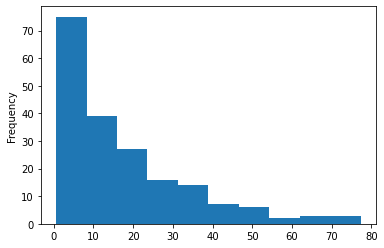

In [102]:
cindex_distro.plot.hist(by='cindex')
plt.show()

This actually resembles a pretty smooth exponential curve, which means it's probably a good idea to take the log of it to normalize it.

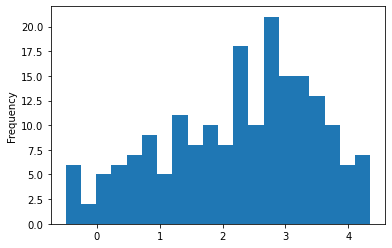

In [103]:
cindex_distro_log = cindex_distro.apply(np.log)
cindex_distro_log.plot.hist(by='cindex', bins=20)
plt.show()

To look at where the cutoffs of these bins are more closely:

In [104]:
pd.cut(cindex_distro_log, 20).value_counts().sort_index()

(-0.5, -0.253]        6
(-0.253, -0.0105]     2
(-0.0105, 0.232]      5
(0.232, 0.474]        6
(0.474, 0.716]        7
(0.716, 0.958]        9
(0.958, 1.2]          5
(1.2, 1.442]         11
(1.442, 1.684]        8
(1.684, 1.926]       10
(1.926, 2.168]        8
(2.168, 2.411]       18
(2.411, 2.653]       10
(2.653, 2.895]       21
(2.895, 3.137]       15
(3.137, 3.379]       15
(3.379, 3.621]       13
(3.621, 3.863]       10
(3.863, 4.105]        6
(4.105, 4.347]        7
Name: cindex, dtype: int64

Some different optional cutoff points that occur for an aggregate feature:
- -0.5, by 6 (being competitive at all, could just use >0 without the log)
- -0.0105 by 3
- 0.232 by 1
- 0.474 by 1
- 0.716 by 2
- 1.2 by 6
- 1.684 by 2
- 2.168 by 10
- 2.653 by 11
- 4.105 by 1

That said, I probably won't use those cutoffs since I need to split moves into physical, special and status first, but it gives the basic model for one of my aggregate features.

In [105]:
power_distro = moves_cindex_distro.loc[moves_cindex_distro['power'] > 0, 'power']
power_distro.describe(percentiles = [n/20 for n in range(1, 20)])

count    277.000000
mean      75.732852
std       34.504790
min       15.000000
5%        25.000000
10%       35.000000
15%       40.000000
20%       50.000000
25%       55.000000
30%       60.000000
35%       60.000000
40%       65.000000
45%       70.000000
50%       75.000000
55%       80.000000
60%       80.000000
65%       80.000000
70%       90.000000
75%       90.000000
80%      100.000000
85%      110.000000
90%      120.000000
95%      140.000000
max      250.000000
Name: power, dtype: float64

Nonzero powered moves have a median power of 75, a mean power of about 75 (which is interesting, probably indicating something less exponential and skewed), and a top 10% power of 120.

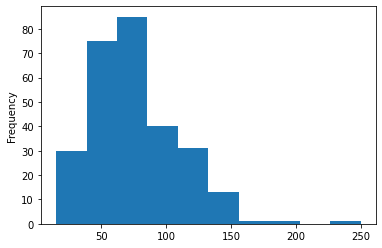

In [106]:
power_distro.plot.hist(by='power')
plt.show()

This is a very different distribution from the cindex, not exponential. It's closer to normal, but significantly right tailed. So perhaps our cutoffs would be slightly more concentrated on the left side, but no need to take the log of them since they aren't exponentially distributed.

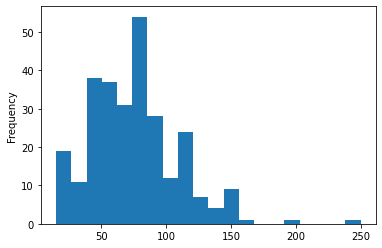

In [107]:
power_distro.plot.hist(by='power', bins=20)
plt.show()

In [108]:
#to see the specific values
pd.cut(power_distro, 20).value_counts().sort_index()

(14.765, 26.75]    19
(26.75, 38.5]      11
(38.5, 50.25]      38
(50.25, 62.0]      37
(62.0, 73.75]      31
(73.75, 85.5]      54
(85.5, 97.25]      28
(97.25, 109.0]     12
(109.0, 120.75]    24
(120.75, 132.5]     7
(132.5, 144.25]     4
(144.25, 156.0]     9
(156.0, 167.75]     1
(167.75, 179.5]     0
(179.5, 191.25]     0
(191.25, 203.0]     1
(203.0, 214.75]     0
(214.75, 226.5]     0
(226.5, 238.25]     0
(238.25, 250.0]     1
Name: power, dtype: int64

Going by the histogram cuts and fine visualization, some decent cutoffs seem to be (i.e. the "jumps" upward):
- 40 or 38.5
- 75 or 73.75
- 110 or 109.0
- 145 or 144.25

These capture the largest jumps which may capture key checkpoints in move strength.

<a id="physical_cutoff"></a>
### Aggregate Feature: Physical Cutoff

This feature will list the number of moves a pokemon has which are above a certain cindex value. We'll investigate which cutoff is best later.

First we need to consider only the moves in the distribution which are physical in nature to make decisions about this aggregate feature.

In [109]:
moves_cindex_distro_phys = moves_cindex_distro.loc[moves_cindex_distro['category'] == 'Physical', :].copy()
moves_cindex_distro_phys.drop(columns='category', inplace=True)
moves_cindex_distro_phys.describe(percentiles = [n/20 for n in range(1, 20)])

n_learnset  n_competitive      cindex       power
count  183.000000     183.000000  183.000000  183.000000
mean    58.497268       3.513661    8.120778   66.409836
std     58.594891       8.106339   14.330637   39.642653
min      3.000000       0.000000    0.000000    0.000000
5%       5.100000       0.000000    0.000000    0.000000
10%      7.000000       0.000000    0.000000   15.000000
15%     10.300000       0.000000    0.000000   25.000000
20%     13.400000       0.000000    0.000000   32.000000
25%     19.000000       0.000000    0.000000   40.000000
30%     23.600000       0.000000    0.000000   50.000000
35%     26.700000       0.000000    0.000000   58.500000
40%     32.800000       0.000000    0.000000   60.000000
45%     37.800000       0.000000    0.000000   60.000000
50%     43.000000       1.000000    0.719424   70.000000
55%     50.100000       1.000000    1.653981   70.000000
60%     53.400000       1.000000    2.847222   75.000000
65%     61.000000       2.000000    4.755814   80.000000
70%     65.400000       3.000000    7.250836   80.000000
75%     75.500000       4.000000   10.370685   85.000000
80%     88.800000       6.000000   14.152824   90.000000
85%    103.700000       7.700000   17.795365  100.000000
90%    139.800000      10.000000   27.733333  120.000000
95%    164.000000      13.000000   42.243590  129.000000
max    411.000000      72.000000   77.272727  250.000000

Physical Moves Summary Statistics:
- n_learnset mean: 58
- n_learnset median: 43
- n_learnset max: 411

- n_competitive mean: 3.5
- n_competitive median: 1
- n_competitive max: 72

- cindex mean: 8
- cindex median: 0.7
- cindex max: 77

- power mean: 66
- power median: 70
- power max: 250

Now we need the physical moves with cindex greater than 0

In [110]:
physical_distro = moves_cindex_distro_phys.loc[moves_cindex_distro_phys['cindex'] > 0, 'cindex']
physical_distro.describe(percentiles = [n/20 for n in range(1, 20)])

count    96.000000
mean     15.480233
std      16.682773
min       0.609756
5%        0.820882
10%       1.232607
15%       1.820055
20%       2.173913
25%       3.200605
30%       4.134697
35%       5.065789
40%       5.714286
45%       8.298812
50%       9.716758
55%      11.490566
60%      12.903226
65%      15.333208
70%      17.173321
75%      22.327044
80%      26.666667
85%      33.333333
90%      41.987179
95%      48.037037
max      77.272727
Name: cindex, dtype: float64

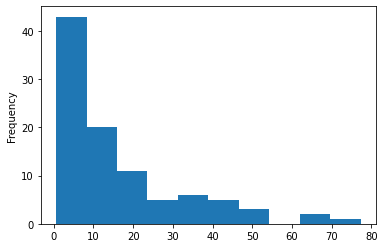

In [111]:
physical_distro.plot.hist(by='cindex')
plt.show()

It still vaguely resembles exponential decay, but the sparsity starts around 25.  So we can still try a log:

In [112]:
physical_distro_log = physical_distro.apply(np.log)
physical_distro_log.describe(percentiles = [n/20 for n in range(1, 20)])

count    96.000000
mean      2.084260
std       1.276202
min      -0.494696
5%       -0.200079
10%       0.206849
15%       0.598345
20%       0.776529
25%       1.163246
30%       1.418084
35%       1.622261
40%       1.742969
45%       2.115597
50%       2.273844
55%       2.441205
60%       2.557477
65%       2.729463
70%       2.843349
75%       3.105766
80%       3.283414
85%       3.506558
90%       3.737335
95%       3.871971
max       4.347341
Name: cindex, dtype: float64

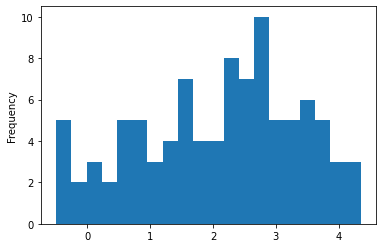

In [113]:
physical_distro_log.plot.hist(bins=20)
plt.show()

In [114]:
pd.cut(physical_distro_log, 20).value_counts().sort_index()

(-0.5, -0.253]        5
(-0.253, -0.0105]     2
(-0.0105, 0.232]      3
(0.232, 0.474]        2
(0.474, 0.716]        5
(0.716, 0.958]        5
(0.958, 1.2]          3
(1.2, 1.442]          4
(1.442, 1.684]        7
(1.684, 1.926]        4
(1.926, 2.168]        4
(2.168, 2.411]        8
(2.411, 2.653]        7
(2.653, 2.895]       10
(2.895, 3.137]        5
(3.137, 3.379]        5
(3.379, 3.621]        6
(3.621, 3.863]        5
(3.863, 4.105]        3
(4.105, 4.347]        3
Name: cindex, dtype: int64

Cutoff options:
- all of them (how many physical moves a pokemon has)
- 0.474
- 1.442
- 2.168
- 2.653
- 3.379

We will make 6 aggregate physical move features based on these cutoffs

In [115]:
physical_cutoff1 = list(physical_distro_log.index)
shrinkfeatures_df['Physical Cutoff 1'] = pokemon_learnsets_df.loc[:, physical_cutoff1].sum(axis=1)
shrinkfeatures_df['Physical Cutoff 1'].sort_values(ascending=False).head(10)

name
Mew           80
Rhyperior     45
Rhydon        44
Tyranitar     41
Aggron        40
Pangoro       38
Nidoking      37
Krookodile    36
Nidoqueen     35
Snorlax       33
Name: Physical Cutoff 1, dtype: int64

In [116]:
physical_cutoff2 = list(physical_distro_log[physical_distro_log >= 0.474].index)
shrinkfeatures_df['Physical Cutoff 2'] = pokemon_learnsets_df.loc[:, physical_cutoff2].sum(axis=1)
shrinkfeatures_df['Physical Cutoff 2'].sort_values(ascending=False).head(10)

name
Mew           68
Rhyperior     33
Rhydon        32
Tyranitar     32
Pangoro       30
Nidoking      29
Aggron        29
Krookodile    27
Nidoqueen     27
Snorlax       27
Name: Physical Cutoff 2, dtype: int64

In [117]:
physical_cutoff3 = list(physical_distro_log[physical_distro_log >= 1.442].index)
shrinkfeatures_df['Physical Cutoff 3'] = pokemon_learnsets_df.loc[:, physical_cutoff3].sum(axis=1)
shrinkfeatures_df['Physical Cutoff 3'].sort_values(ascending=False).head(10)

name
Mew          52
Pangoro      25
Rhyperior    22
Rhydon       21
Snorlax      21
Tyranitar    21
Aggron       20
Scrafty      19
Tyrantrum    19
Golurk       19
Name: Physical Cutoff 3, dtype: int64

In [118]:
physical_cutoff4 = list(physical_distro_log[physical_distro_log >= 2.168].index)
shrinkfeatures_df['Physical Cutoff 4'] = pokemon_learnsets_df.loc[:, physical_cutoff4].sum(axis=1)
shrinkfeatures_df['Physical Cutoff 4'].sort_values(ascending=False).head(10)

name
Mew          39
Pangoro      19
Rhyperior    16
Tyranitar    15
Aggron       15
Rhydon       15
Tyrantrum    15
Snorlax      15
Drednaw      15
Tyrunt       14
Name: Physical Cutoff 4, dtype: int64

In [119]:
physical_cutoff5 = list(physical_distro_log[physical_distro_log >= 2.653].index)
shrinkfeatures_df['Physical Cutoff 5'] = pokemon_learnsets_df.loc[:, physical_cutoff5].sum(axis=1)
shrinkfeatures_df['Physical Cutoff 5'].sort_values(ascending=False).head(10)

name
Mew           25
Rhyperior     10
Drednaw       10
Pangoro       10
Steelix       10
Arctovish      9
Copperajah     9
Tyrantrum      9
Coalossal      9
Solgaleo       9
Name: Physical Cutoff 5, dtype: int64

In [120]:
physical_cutoff6 = list(physical_distro_log[physical_distro_log >= 3.379].index)
shrinkfeatures_df['Physical Cutoff 6'] = pokemon_learnsets_df.loc[:, physical_cutoff6].sum(axis=1)
shrinkfeatures_df['Physical Cutoff 6'].sort_values(ascending=False).head(10)

name
Mew                 10
Gallade              5
Blaziken             5
Solgaleo             5
Lucario              4
Tyrantrum            4
Pinsir               4
Darmanitan-Galar     4
Pangoro              4
Marowak-Alola        4
Name: Physical Cutoff 6, dtype: int64

<a id="physical_coverage"></a>
### Aggregate Feature: Physical Coverage

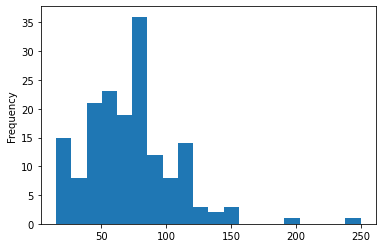

In [121]:
physical_powerdistro = moves_cindex_distro_phys.loc[moves_cindex_distro_phys['power'] > 0, ['power', 'type']]
physical_powerdistro['power'].plot.hist(bins=20)
plt.show()

In [122]:
pd.cut(physical_powerdistro['power'], 20).value_counts().sort_index()

(14.765, 26.75]    15
(26.75, 38.5]       8
(38.5, 50.25]      21
(50.25, 62.0]      23
(62.0, 73.75]      19
(73.75, 85.5]      36
(85.5, 97.25]      12
(97.25, 109.0]      8
(109.0, 120.75]    14
(120.75, 132.5]     3
(132.5, 144.25]     2
(144.25, 156.0]     3
(156.0, 167.75]     0
(167.75, 179.5]     0
(179.5, 191.25]     0
(191.25, 203.0]     1
(203.0, 214.75]     0
(214.75, 226.5]     0
(226.5, 238.25]     0
(238.25, 250.0]     1
Name: power, dtype: int64

Cutoff options:
- all of them
- 38.5
- 73.75
- 109

We'll make an aggregate feature for these four cutoffs of how many types that a pokemon has available moves for which are also above those levels of power (which gives an idea of how many types a pokemon can "cover" offensively, i.e. how versatile it is offensively against pokemon of a variety of types), and we'll define a function to help us do this

In [123]:
def physical_coveragesum(cutoff):
    powerdistro = physical_powerdistro.loc[physical_powerdistro['power'] >= cutoff, :]
    coveragesum = pd.DataFrame(index=shrinkfeatures_df.index)
    for ptype in type_list:
        physical_coverage = list(powerdistro.loc[powerdistro['type'] == ptype, :].index)
        coveragesum[ptype] = pokemon_learnsets_df.loc[:, physical_coverage].sum(axis=1)
        coveragesum.loc[:, ptype].where(coveragesum[ptype] <= 1, 1, inplace=True)
    return coveragesum.sum(axis=1)

In [124]:
shrinkfeatures_df['Physical Coverage 1'] = physical_coveragesum(0)
shrinkfeatures_df['Physical Coverage 1'].sort_values(ascending=False).head(10)

name
Mew           18
Pangoro       15
Nidoqueen     15
Kommo-o       15
Nidoking      15
Riolu         14
Dunsparce     14
Pancham       14
Rhyperior     14
Lickilicky    14
Name: Physical Coverage 1, dtype: int64

In [125]:
shrinkfeatures_df['Physical Coverage 2'] = physical_coveragesum(38.5)
shrinkfeatures_df['Physical Coverage 2'].sort_values(ascending=False).head(10)

name
Mew           18
Kommo-o       15
Nidoqueen     15
Pangoro       15
Rhyperior     14
Marshadow     14
Rhydon        14
Kangaskhan    14
Nidoking      14
Tyrunt        14
Name: Physical Coverage 2, dtype: int64

In [126]:
shrinkfeatures_df['Physical Coverage 3'] = physical_coveragesum(73.75)
shrinkfeatures_df['Physical Coverage 3'].sort_values(ascending=False).head(10)

name
Mew          18
Snorlax      13
Rhyperior    13
Rhydon       13
Nidoking     13
Pangoro      13
Marshadow    13
Scraggy      12
Scrafty      12
Mewtwo       12
Name: Physical Coverage 3, dtype: int64

In [127]:
shrinkfeatures_df['Physical Coverage 4'] = physical_coveragesum(109)
shrinkfeatures_df['Physical Coverage 4'].sort_values(ascending=False).head(10)

name
Mew              10.0
Snorlax           5.0
Copperajah        5.0
Solgaleo          5.0
Aggron            5.0
Nidoking          5.0
Marowak-Alola     5.0
Lickitung         4.0
Growlithe         4.0
Arcanine          4.0
Name: Physical Coverage 4, dtype: float64

<a id="special_cutoff"></a>
### Aggregate Feature: Special Cutoff

Now we will make a precisely analogous feature for special moves as we did in the feature physical cutoff.

In [128]:
moves_cindex_distro_spec = moves_cindex_distro.loc[moves_cindex_distro['category'] == 'Special', :].copy()
moves_cindex_distro_spec.drop(columns='category', inplace=True)
moves_cindex_distro_spec.describe(percentiles = [n/20 for n in range(1, 20)])

n_learnset  n_competitive      cindex       power
count  119.000000     119.000000  119.000000  119.000000
mean    59.789916       5.386555   10.451007   74.159664
std     69.108717       8.939637   15.085785   37.930128
min      3.000000       0.000000    0.000000    0.000000
5%       3.900000       0.000000    0.000000    0.000000
10%      4.000000       0.000000    0.000000   28.000000
15%      8.700000       0.000000    0.000000   40.000000
20%     13.200000       0.000000    0.000000   40.000000
25%     17.000000       0.000000    0.000000   50.000000
30%     21.000000       0.000000    0.000000   57.000000
35%     25.000000       0.000000    0.000000   60.000000
40%     31.200000       0.000000    0.000000   65.000000
45%     35.100000       0.000000    0.000000   65.000000
50%     38.000000       1.000000    2.000000   75.000000
55%     45.900000       1.000000    4.142157   80.000000
60%     51.000000       2.000000    8.471673   80.000000
65%     64.500000       2.700000   10.368590   90.000000
70%     73.600000       5.000000   13.571429   90.000000
75%     78.500000       8.000000   16.441441   92.500000
80%     92.200000      10.000000   21.414606  100.000000
85%    103.300000      12.300000   26.453634  113.000000
90%    132.000000      18.200000   33.333333  130.000000
95%    145.800000      29.100000   41.383148  150.000000
max    413.000000      37.000000   72.222222  160.000000

Special Moves Summary Statistics:
- n_learnset mean: 60
- n_learnset median: 38
- n_learnset max: 413
- n_competitive mean: 5.5
- n_competitive median: 1
- n_competitive max: 37
- cindex mean: 10
- cindex median: 2
- cindex max: 72
- power mean: 74
- power median: 75
- power max: 160

Now we need the special moves with cindex greater than 0

In [129]:
special_distro = moves_cindex_distro_spec.loc[moves_cindex_distro_spec['cindex'] > 0, 'cindex']
special_distro.describe(percentiles = [n/20 for n in range(1, 20)])

count    63.000000
mean     19.740790
std      15.709625
min       1.219512
5%        2.017391
10%       2.930187
15%       4.630952
20%       6.173469
25%       8.778206
30%       9.859649
35%      10.493421
40%      11.388889
45%      14.285714
50%      16.000000
55%      17.050644
60%      21.156728
65%      22.738474
70%      25.881596
75%      28.117716
80%      31.891892
85%      33.333333
90%      40.125642
95%      47.954098
max      72.222222
Name: cindex, dtype: float64

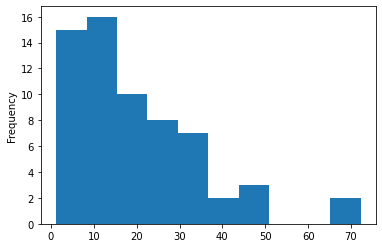

In [130]:
special_distro.plot.hist(by='cindex')
plt.show()

It's close enough to the physical moves that we can still try using a log transform

In [131]:
special_distro_log = special_distro.apply(np.log)
special_distro_log.describe(percentiles = [n/20 for n in range(1, 20)])

count    63.000000
mean      2.601724
std       0.989213
min       0.198451
5%        0.701485
10%       1.070136
15%       1.521872
20%       1.820210
25%       2.172228
30%       2.288298
35%       2.350737
40%       2.432563
45%       2.659260
50%       2.772589
55%       2.836033
60%       3.051954
65%       3.123042
70%       3.253485
75%       3.336395
80%       3.460794
85%       3.506558
90%       3.690565
95%       3.870240
max       4.279748
Name: cindex, dtype: float64

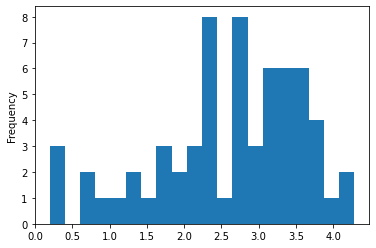

In [132]:
special_distro_log.plot.hist(bins=20)
plt.show()

In [133]:
pd.cut(special_distro_log, 20).value_counts().sort_index()

(0.194, 0.403]    3
(0.403, 0.607]    0
(0.607, 0.811]    2
(0.811, 1.015]    1
(1.015, 1.219]    1
(1.219, 1.423]    2
(1.423, 1.627]    1
(1.627, 1.831]    3
(1.831, 2.035]    2
(2.035, 2.239]    3
(2.239, 2.443]    8
(2.443, 2.647]    1
(2.647, 2.851]    8
(2.851, 3.055]    3
(3.055, 3.259]    6
(3.259, 3.463]    6
(3.463, 3.668]    6
(3.668, 3.872]    4
(3.872, 4.076]    1
(4.076, 4.28]     2
Name: cindex, dtype: int64

Cutoff options:
- all of them
- 0.607
- 1.219
- 1.627
- 2.239
- 2.647
- 3.055

We will make 7 aggregate special move features based on these cutoffs

In [134]:
special_cutoff1 = list(special_distro_log.index)
shrinkfeatures_df['Special Cutoff 1'] = pokemon_learnsets_df.loc[:, special_cutoff1].sum(axis=1)
shrinkfeatures_df['Special Cutoff 1'].sort_values(ascending=False).head(10)

name
Mew               48
Slowking-Galar    22
Mewtwo            22
Victini           21
Drampa            20
Rayquaza          20
Slowbro-Galar     20
Latias            19
Latios            19
Slowking          19
Name: Special Cutoff 1, dtype: int64

In [135]:
special_cutoff2 = list(special_distro_log[special_distro_log >= 0.607].index)
shrinkfeatures_df['Special Cutoff 2'] = pokemon_learnsets_df.loc[:, special_cutoff2].sum(axis=1)
shrinkfeatures_df['Special Cutoff 2'].sort_values(ascending=False).head(10)

name
Mew               45
Victini           21
Slowking-Galar    20
Mewtwo            20
Drampa            19
Rayquaza          18
Clefable          18
Slowbro-Galar     18
Latias            18
Latios            18
Name: Special Cutoff 2, dtype: int64

In [136]:
special_cutoff3 = list(special_distro_log[special_distro_log >= 1.219].index)
shrinkfeatures_df['Special Cutoff 3'] = pokemon_learnsets_df.loc[:, special_cutoff3].sum(axis=1)
shrinkfeatures_df['Special Cutoff 3'].sort_values(ascending=False).head(10)

name
Mew               42
Victini           21
Slowking-Galar    19
Drampa            18
Rayquaza          17
Clefable          17
Mewtwo            17
Latias            17
Latios            17
Slowbro-Galar     17
Name: Special Cutoff 3, dtype: int64

In [137]:
special_cutoff4 = list(special_distro_log[special_distro_log >= 1.627].index)
shrinkfeatures_df['Special Cutoff 4'] = pokemon_learnsets_df.loc[:, special_cutoff4].sum(axis=1)
shrinkfeatures_df['Special Cutoff 4'].sort_values(ascending=False).head(10)

name
Mew               40
Victini           21
Slowking-Galar    18
Latias            17
Latios            17
Mewtwo            16
Slowbro-Galar     16
Drampa            16
Clefable          16
Rayquaza          16
Name: Special Cutoff 4, dtype: int64

In [138]:
special_cutoff5 = list(special_distro_log[special_distro_log >= 2.239].index)
shrinkfeatures_df['Special Cutoff 5'] = pokemon_learnsets_df.loc[:, special_cutoff5].sum(axis=1)
shrinkfeatures_df['Special Cutoff 5'].sort_values(ascending=False).head(10)

name
Mew               33
Victini           19
Slowking-Galar    16
Latios            14
Slowbro-Galar     14
Frillish          14
Jellicent         14
Latias            14
Lunala            14
Rayquaza          14
Name: Special Cutoff 5, dtype: int64

In [139]:
special_cutoff6 = list(special_distro_log[special_distro_log >= 2.647].index)
shrinkfeatures_df['Special Cutoff 6'] = pokemon_learnsets_df.loc[:, special_cutoff6].sum(axis=1)
shrinkfeatures_df['Special Cutoff 6'].sort_values(ascending=False).head(10)

name
Mew               24
Victini           14
Slowking-Galar    13
Slowbro-Galar     12
Mewtwo            11
Lunala            11
Clefable          11
Rayquaza          11
Frillish          10
Jellicent         10
Name: Special Cutoff 6, dtype: int64

In [140]:
special_cutoff7 = list(special_distro_log[special_distro_log >= 3.055].index)
shrinkfeatures_df['Special Cutoff 7'] = pokemon_learnsets_df.loc[:, special_cutoff7].sum(axis=1)
shrinkfeatures_df['Special Cutoff 7'].sort_values(ascending=False).head(10)

name
Mew               16
Victini           10
Octillery          9
Clefairy           9
Clefable           9
Slowking-Galar     9
Slowbro-Galar      9
Frillish           8
Jellicent          8
Goodra             8
Name: Special Cutoff 7, dtype: int64

<a id="special_coverage"></a>
### Aggregate Feature: Special Coverage

Finally we'll make another analogous set of features for special coverage, just as we did for physical coverage, but for special moves instead of physical moves.

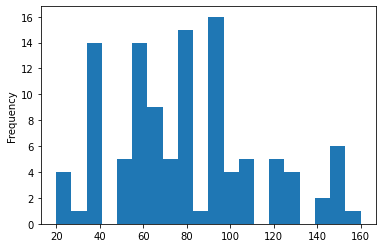

In [141]:
special_powerdistro = moves_cindex_distro_spec.loc[moves_cindex_distro_spec['power'] > 0, ['power', 'type']]
special_powerdistro['power'].plot.hist(bins=20)
plt.show()

In [142]:
pd.cut(special_powerdistro['power'], 20).value_counts().sort_index()

(19.86, 27.0]      4
(27.0, 34.0]       1
(34.0, 41.0]      14
(41.0, 48.0]       0
(48.0, 55.0]       9
(55.0, 62.0]      10
(62.0, 69.0]       9
(69.0, 76.0]       5
(76.0, 83.0]      15
(83.0, 90.0]      14
(90.0, 97.0]       3
(97.0, 104.0]      4
(104.0, 111.0]     5
(111.0, 118.0]     0
(118.0, 125.0]     5
(125.0, 132.0]     4
(132.0, 139.0]     0
(139.0, 146.0]     2
(146.0, 153.0]     6
(153.0, 160.0]     1
Name: power, dtype: int64

Cutoff options:
- all of them
- 34.0
- 48.0
- 55.0
- 76.0
- 97.0
- 104.0
- 118.0
- 139.0
- 146.0

In [143]:
def special_coveragesum(cutoff):
    powerdistro = special_powerdistro.loc[special_powerdistro['power'] >= cutoff, :]
    coveragesum = pd.DataFrame(index=shrinkfeatures_df.index)
    for ptype in type_list:
        special_coverage = list(powerdistro.loc[powerdistro['type'] == ptype, :].index)
        coveragesum[ptype] = pokemon_learnsets_df.loc[:, special_coverage].sum(axis=1)
        coveragesum.loc[:, ptype].where(coveragesum[ptype] <= 1, 1, inplace=True)
    return coveragesum.sum(axis=1)

In [144]:
shrinkfeatures_df['Special Coverage 1'] = special_coveragesum(0)
shrinkfeatures_df['Special Coverage 1'].sort_values(ascending=False).head(10)

name
Mew                18
Togekiss           13
Jirachi            13
Mewtwo             12
Latias             12
Sigilyph           12
Drampa             12
Giratina-Origin    12
Latios             12
Giratina           12
Name: Special Coverage 1, dtype: int64

In [145]:
shrinkfeatures_df['Special Coverage 2'] = special_coveragesum(34)
shrinkfeatures_df['Special Coverage 2'].sort_values(ascending=False).head(10)

name
Mew                  18
Sigilyph             12
Giratina-Origin      12
Giratina             12
Drampa               12
Jirachi              12
Togekiss             12
Silvally-Electric    11
Silvally-Grass       11
Silvally-Ghost       11
Name: Special Coverage 2, dtype: int64

In [146]:
shrinkfeatures_df['Special Coverage 3'] = special_coveragesum(48)
shrinkfeatures_df['Special Coverage 3'].sort_values(ascending=False).head(10)

name
Mew                18
Drampa             12
Giratina           12
Jirachi            12
Giratina-Origin    12
Sigilyph           12
Silvally-Bug       11
Silvally-Flying    11
Silvally-Fire      11
Marowak-Alola      11
Name: Special Coverage 3, dtype: int64

In [147]:
shrinkfeatures_df['Special Coverage 4'] = special_coveragesum(55)
shrinkfeatures_df['Special Coverage 4'].sort_values(ascending=False).head(10)

name
Mew                18
Jirachi            12
Giratina           12
Giratina-Origin    12
Drampa             12
Sigilyph           12
Slowking           11
Silvally-Dragon    11
Silvally-Dark      11
Silvally-Bug       11
Name: Special Coverage 4, dtype: int64

In [148]:
shrinkfeatures_df['Special Coverage 5'] = special_coveragesum(76)
shrinkfeatures_df['Special Coverage 5'].sort_values(ascending=False).head(10)

name
Mew          18
Drampa       11
Rayquaza     10
Aggron       10
Nidoking     10
Slowking     10
Nidoqueen    10
Latias        9
Genesect      9
Sigilyph      9
Name: Special Coverage 5, dtype: int64

In [149]:
shrinkfeatures_df['Special Coverage 6'] = special_coveragesum(97)
shrinkfeatures_df['Special Coverage 6'].sort_values(ascending=False).head(10)

name
Mew           9.0
Slowking      8.0
Drampa        8.0
Lickilicky    8.0
Slowbro       8.0
Rayquaza      8.0
Dragonite     8.0
Aggron        7.0
Snorlax       7.0
Palkia        7.0
Name: Special Coverage 6, dtype: float64

In [150]:
shrinkfeatures_df['Special Coverage 7'] = special_coveragesum(104)
shrinkfeatures_df['Special Coverage 7'].sort_values(ascending=False).head(10)

name
Mew               9.0
Dragonite         8.0
Slowking          8.0
Slowbro           8.0
Drampa            8.0
Rayquaza          8.0
Snorlax           7.0
Palkia            7.0
Slowbro-Galar     7.0
Slowking-Galar    7.0
Name: Special Coverage 7, dtype: float64

In [151]:
shrinkfeatures_df['Special Coverage 8'] = special_coveragesum(118)
shrinkfeatures_df['Special Coverage 8'].sort_values(ascending=False).head(10)

name
Mew             6.0
Slowbro         5.0
Slowking        5.0
Magmar          4.0
Raichu-Alola    4.0
Alakazam        4.0
Jirachi         4.0
Rayquaza        4.0
Registeel       4.0
Solgaleo        4.0
Name: Special Coverage 8, dtype: float64

In [152]:
shrinkfeatures_df['Special Coverage 9'] = special_coveragesum(139)
shrinkfeatures_df['Special Coverage 9'].sort_values(ascending=False).head(10)

name
Heatran                3.0
Bronzong               2.0
Excadrill              2.0
Wailord                2.0
Celesteela             2.0
Necrozma               2.0
Necrozma-Dusk Mane     2.0
Necrozma-Dawn Wings    2.0
Magearna               2.0
Primarina              2.0
Name: Special Coverage 9, dtype: float64

In [153]:
shrinkfeatures_df['Special Coverage 10'] = special_coveragesum(146)
shrinkfeatures_df['Special Coverage 10'].sort_values(ascending=False).head(10)

name
Heatran                2.0
Swampert               2.0
Inteleon               2.0
Cinderace              2.0
Rillaboom              2.0
Necrozma-Dawn Wings    2.0
Necrozma               2.0
Torkoal                2.0
Jellicent              2.0
Blaziken               2.0
Name: Special Coverage 10, dtype: float64

<a id="misc_status"></a>
### Aggregate Feature: Miscellaneous Status

Now we need to make an aggregate feature for the last category of moves, status moves. Since these moves don't do direct damage, we can't use them to make a coverage feature, but we'll still probably want to know their cindexes and the distribution thereof. This feature is going to have more similarity to the manual features we created than to the other aggregate features, since having status moves itself is often a unique utility role that is played (rather than just having generically strong physical or special attacks).

In [154]:
moves_cindex_distro_stat = moves_cindex_distro.loc[moves_cindex_distro['category'] == 'Non-Damaging', :].copy()
moves_cindex_distro_stat.drop(columns='category', inplace=True)
moves_cindex_distro_stat.describe(percentiles = [n/20 for n in range(1, 20)])

n_learnset  n_competitive      cindex  power
count  122.000000     122.000000  122.000000  122.0
mean    51.016393       1.983607    4.446601    0.0
std     56.362314       6.058917   12.187723    0.0
min      3.000000       0.000000    0.000000    0.0
5%       4.050000       0.000000    0.000000    0.0
10%      7.100000       0.000000    0.000000    0.0
15%     11.000000       0.000000    0.000000    0.0
20%     13.000000       0.000000    0.000000    0.0
25%     15.000000       0.000000    0.000000    0.0
30%     18.300000       0.000000    0.000000    0.0
35%     21.350000       0.000000    0.000000    0.0
40%     24.800000       0.000000    0.000000    0.0
45%     27.450000       0.000000    0.000000    0.0
50%     32.000000       0.000000    0.000000    0.0
55%     37.000000       0.000000    0.000000    0.0
60%     42.000000       0.000000    0.000000    0.0
65%     47.000000       0.000000    0.000000    0.0
70%     61.700000       0.000000    0.000000    0.0
75%     66.750000       1.000000    1.250000    0.0
80%     75.800000       1.000000    3.515065    0.0
85%     94.550000       3.000000    6.657233    0.0
90%    125.800000       4.900000   17.190635    0.0
95%    143.950000       8.950000   24.832090    0.0
max    352.000000      37.000000   75.000000    0.0

It looks like most status moves are not really significant, so we need not concern ourselves with most of these statistics, and we are only interested in the top 25% or so of status moves.

In [155]:
moves_cindex_distro_stat.loc[moves_cindex_distro_stat['cindex'] > 0, :].sort_values(by='cindex')

n_learnset  n_competitive     cindex  power      type
Safeguard           143.0            1.0   0.699301    0.0    Normal
Block                95.0            1.0   1.052632    0.0    Normal
Spite                76.0            1.0   1.315789    0.0     Ghost
Skill Swap           66.0            1.0   1.515152    0.0   Psychic
Magnet Rise          49.0            1.0   2.040816    0.0  Electric
Hail                 97.0            2.0   2.061856    0.0       Ice
Magic Coat           91.0            2.0   2.197802    0.0   Psychic
Tailwind             68.0            2.0   2.941176    0.0    Flying
Reflect             164.0            6.0   3.658537    0.0   Psychic
Copycat              26.0            1.0   3.846154    0.0    Normal
Light Screen        153.0            6.0   3.921569    0.0   Psychic
Misty Terrain        24.0            1.0   4.166667    0.0     Fairy
Disable              42.0            2.0   4.761905    0.0    Normal
Roar                106.0            7.0   6.603774    0.0    Normal
Trick Room           75.0            5.0   6.666667    0.0   Psychic
Perish Song          14.0            1.0   7.142857    0.0    Normal
Soak                 13.0            1.0   7.692308    0.0     Water
Hypnosis             34.0            3.0   8.823529    0.0   Psychic
Destiny Bond         29.0            4.0  13.793103    0.0     Ghost
Encore               65.0           10.0  15.384615    0.0    Normal
Memento              23.0            4.0  17.391304    0.0      Dark
Whirlwind            22.0            4.0  18.181818    0.0    Normal
Haze                 42.0            8.0  19.047619    0.0       Ice
Pain Split           64.0           13.0  20.312500    0.0    Normal
Yawn                 42.0            9.0  21.428571    0.0    Normal
Taunt               134.0           29.0  21.641791    0.0      Dark
Thunder Wave        144.0           36.0  25.000000    0.0  Electric
Stun Spore           15.0            4.0  26.666667    0.0     Grass
Trick                98.0           37.0  37.755102    0.0   Psychic
Will-O-Wisp          68.0           26.0  38.235294    0.0      Fire
Glare                 5.0            3.0  60.000000    0.0    Normal
Sleep Powder         13.0            8.0  61.538462    0.0     Grass
Unique Shield         4.0            3.0  75.000000    0.0    Normal

There is one more thing that we are forgetting about, which is that there are several status moves left in our pool of unique moves. Since we'll make a separate feature for unique powerful attacks soon, let's remove the remaining powerful status moves there (which haven't been removed already into something like setup, e.g. Geomancy) and include them in the hierarchy of our misc status feature:

In [156]:
moves_cindex.loc[(moves_cindex['cindex'] == 100) & (moves_cindex['category'] == 'Non-Damaging'), :]

n_learnset  n_competitive  cindex  power    type      category
Spore               2.0            2.0   100.0    0.0   Grass  Non-Damaging
Lovely Kiss         1.0            1.0   100.0    0.0  Normal  Non-Damaging

Lovely Kiss is actually no better than Sleep Powder in terms of its move statistics, but it only has 100 cindex since it is only in the (competitive) learnset of Jynx and it is a good move. Spore, on the other hand, is unique as a 100 accuracy immediate sleep move, so it really is a cut above.

Also, although Thunder Wave has a slightly lower cindex than Stun Spore, it is  an almost strictly better move due to higher accuracy for the same effect. Stun Spore may just have higher cindex due to having much narrow access for a certain group of pokemon that could use it well, whereas Thunder Wave is a widely accessible move, but Thunder Wave will be placed above Stun Spore.

As another reminder, there were also three damaging moves with powerful secondary status effects that cause them to be used for phazing, like many of the moves in our 2nd to last rank of this feature (e.g. Encore, Whirlwind, etc.). These are Clear Smog, Circle Throw and Dragon Tail, and since these moves are used more for their secondary status effects than for their damage, they fit well in the same tier of this feature as the other phazing moves.

Misc Status Hierarchy (based on the most reasonable clusters of above cindexes):
- 5: Spore
- 4: Unique Shield, Sleep Powder, Lovely Kiss, Glare
- 3: Thunder Wave, Trick, Will-O-Wisp
- 2: Destiny Bond, Encore, Memento, Whirlwind, Haze, Pain Split, Yawn, Taunt, Stun Spore, Clear Smog, Dragon Tail, Circle Throw
- 1: Safeguard, Block, Spite, Skill Swap, Magnet Rise, Hail, Magic Coat, Tailwind, Reflect, Copycat, Light Screen, Misty Terrain, Disable, Roar, Trick Room, Perish Song, Soak, Hypnosis

In [157]:
#Misc Status
shrinkfeatures_df['Misc Status'] = 0
shrinkfeatures_df.loc[pokemon_learnsets_df['Safeguard'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Block'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Spite'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Skill Swap'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Magnet Rise'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Hail'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Magic Coat'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Copycat'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Misty Terrain'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Disable'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Soak'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Tailwind'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Reflect'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Light Screen'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Trick Room'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Roar'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Perish Song'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Hypnosis'] == 1, 'Misc Status'] = 1
shrinkfeatures_df.loc[pokemon_learnsets_df['Memento'] == 1, 'Misc Status'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Pain Split'] == 1, 'Misc Status'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Taunt'] == 1, 'Misc Status'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Whirlwind'] == 1, 'Misc Status'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Yawn'] == 1, 'Misc Status'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Haze'] == 1, 'Misc Status'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Clear Smog'] == 1, 'Misc Status'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Destiny Bond'] == 1, 'Misc Status'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Encore'] == 1, 'Misc Status'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Dragon Tail'] == 1, 'Misc Status'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Circle Throw'] == 1, 'Misc Status'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Stun Spore'] == 1, 'Misc Status'] = 2
shrinkfeatures_df.loc[pokemon_learnsets_df['Trick'] == 1, 'Misc Status'] = 3
shrinkfeatures_df.loc[pokemon_learnsets_df['Thunder Wave'] == 1, 'Misc Status'] = 3
shrinkfeatures_df.loc[pokemon_learnsets_df['Will-O-Wisp'] == 1, 'Misc Status'] = 3
#don't forget Unique Shield moves, which have to be added separately
#since they are not really duplicate moves, just have similar function
#collectively their cindex would be 75
shrinkfeatures_df.loc[pokemon_learnsets_df['King\'s Shield'] == 1, 'Misc Status'] = 4
shrinkfeatures_df.loc[pokemon_learnsets_df['Spiky Shield'] == 1, 'Misc Status'] = 4
shrinkfeatures_df.loc[pokemon_learnsets_df['Obstruct'] == 1, 'Misc Status'] = 4
shrinkfeatures_df.loc[pokemon_learnsets_df['Baneful Bunker'] == 1, 'Misc Status'] = 4
shrinkfeatures_df.loc[pokemon_learnsets_df['Sleep Powder'] == 1, 'Misc Status'] = 4
shrinkfeatures_df.loc[pokemon_learnsets_df['Lovely Kiss'] == 1, 'Misc Status'] = 4
shrinkfeatures_df.loc[pokemon_learnsets_df['Glare'] == 1, 'Misc Status'] = 4
shrinkfeatures_df.loc[pokemon_learnsets_df['Spore'] == 1, 'Misc Status'] = 5
shrinkfeatures_df['Misc Status'].value_counts()

3    335
2    234
1     89
0     41
4     35
5      4
Name: Misc Status, dtype: int64

And that should take care of any status moves that are important competitively, according to the statistics we got from describe and our peripheral knowledge of edge cases.

<a id="unique_powerful"></a>
### Unique Powerful Moves Feature

Now we need to make a feature indicating whether a pokemon has one of the unique powerful moves with cindex 100 and n_learnset 1 or 2 (one has n_learnset 11 but that's a fluke as I already explained about Silvally and Multi-Attack). We should look at all of those moves to make sure we aren't missing anything, but first we need to remember to remove Spore and Lovely Kiss, since this feature is really capturing unique damaging moves (not status moves which our misc status and other many manual features accounted for).

In [158]:
moves_cindex.drop(index=['Spore', 'Lovely Kiss'], inplace=True)
moves_cindex.loc[moves_cindex['cindex'] == 100, :]

n_learnset  n_competitive  cindex  power      type  category
Crabhammer               1.0            1.0   100.0  100.0     Water  Physical
Bonemerang               2.0            2.0   100.0   50.0    Ground  Physical
Sacred Fire              2.0            2.0   100.0  100.0      Fire  Physical
Magma Storm              1.0            1.0   100.0  100.0      Fire   Special
Spacial Rend             1.0            1.0   100.0  100.0    Dragon   Special
Bolt Strike              2.0            2.0   100.0  130.0  Electric  Physical
Gear Grind               1.0            1.0   100.0   50.0     Steel  Physical
Psystrike                1.0            1.0   100.0  100.0   Psychic   Special
Secret Sword             1.0            1.0   100.0   85.0  Fighting   Special
V-create                 2.0            2.0   100.0  180.0      Fire  Physical
Diamond Storm            1.0            1.0   100.0  100.0      Rock  Physical
Thousand Arrows          2.0            2.0   100.0   90.0    Ground  Physical
Thousand Waves           2.0            2.0   100.0   90.0    Ground  Physical
Precipice Blades         1.0            1.0   100.0  120.0    Ground  Physical
Dragon Ascent            1.0            1.0   100.0  120.0    Flying  Physical
Origin Pulse             1.0            1.0   100.0  110.0     Water   Special
Steam Eruption           1.0            1.0   100.0  110.0     Water   Special
Double Iron Bash         1.0            1.0   100.0   60.0     Steel  Physical
Multi-Attack            11.0           11.0   100.0  120.0    Normal  Physical
Clanging Scales          1.0            1.0   100.0  110.0    Dragon   Special
Fleur Cannon             1.0            1.0   100.0  130.0     Fairy   Special
Moongeist Beam           2.0            2.0   100.0  100.0     Ghost   Special
Plasma Fists             1.0            1.0   100.0  100.0  Electric  Physical
Shadow Bone              1.0            1.0   100.0   85.0     Ghost  Physical
Spectral Thief           1.0            1.0   100.0   90.0     Ghost  Physical
Spirit Shackle           1.0            1.0   100.0   80.0     Ghost  Physical
Sunsteel Strike          2.0            2.0   100.0  100.0     Steel  Physical
Apple Acid               1.0            1.0   100.0   80.0     Grass   Special
Astral Barrage           1.0            1.0   100.0  120.0     Ghost   Special
Aura Wheel               1.0            1.0   100.0  110.0  Electric  Physical
Behemoth Bash            1.0            1.0   100.0  100.0     Steel  Physical
Bolt Beak                2.0            2.0   100.0   85.0  Electric  Physical
Dynamax Cannon           1.0            1.0   100.0  100.0    Dragon   Special
Fiery Wrath              1.0            1.0   100.0   90.0      Dark   Special
Fishious Rend            2.0            2.0   100.0   85.0     Water  Physical
Glacial Lance            1.0            1.0   100.0  130.0       Ice  Physical
Grav Apple               1.0            1.0   100.0   80.0     Grass  Physical
Overdrive                1.0            1.0   100.0   80.0  Electric   Special
Spirit Break             1.0            1.0   100.0   75.0     Fairy  Physical
Strange Steam            1.0            1.0   100.0   90.0     Fairy   Special
Surging Strikes          1.0            1.0   100.0   25.0     Water  Physical
Thunderous Kick          1.0            1.0   100.0   90.0  Fighting  Physical
Wicked Blow              1.0            1.0   100.0   80.0      Dark  Physical

These moves all make sense for the feature, so now we just need to create it:

In [159]:
shrinkfeatures_df['Unique Powerful Move'] = pokemon_learnsets_df.loc[:, list(moves_cindex.loc[moves_cindex['cindex'] == 100, :].index)].sum(axis=1)
#we're just one-hot encoding this so let's get rid of all values over 1
shrinkfeatures_df.loc[:, 'Unique Powerful Move'].where(shrinkfeatures_df['Unique Powerful Move'] <= 1, 1, inplace=True)
shrinkfeatures_df['Unique Powerful Move'].value_counts()

0    665
1     73
Name: Unique Powerful Move, dtype: int64

<a id="abilities_invest"></a>
### Investigating abilities_cindex

Just as we did for moves, we need to make an aggregate feature for the remaining abilities that weren't manually placed into features. In order to make appropriate decisions on how to perform various cutoffs in our aggregation, we need to quantitatively investigate our abilities_cindex dataframe first.

In [160]:
abilities_cindex['cindex'].describe(percentiles = [n/20 for n in range(1, 20)])

count    215.000000
mean      55.873363
std       42.280529
min        0.000000
5%         0.000000
10%        0.000000
15%        0.000000
20%        0.000000
25%        0.000000
30%       14.761905
35%       33.333333
40%       50.000000
45%       50.000000
50%       64.285714
55%       75.000000
60%       85.714286
65%      100.000000
70%      100.000000
75%      100.000000
80%      100.000000
85%      100.000000
90%      100.000000
95%      100.000000
max      100.000000
Name: cindex, dtype: float64

Relative to moves, there is a very large percentage of 100 cindex abilities. We should probably investigate just those 100 cindex abilities more closely:

In [161]:
abilities_cindex.loc[abilities_cindex['cindex'] == 100].describe(percentiles = [n/20 for n in range(1, 20)])

n_abilityset  n_competitive  cindex
count     82.000000      82.000000    82.0
mean       2.243902       2.243902   100.0
std        2.432095       2.432095     0.0
min        1.000000       1.000000   100.0
5%         1.000000       1.000000   100.0
10%        1.000000       1.000000   100.0
15%        1.000000       1.000000   100.0
20%        1.000000       1.000000   100.0
25%        1.000000       1.000000   100.0
30%        1.000000       1.000000   100.0
35%        1.000000       1.000000   100.0
40%        1.000000       1.000000   100.0
45%        1.000000       1.000000   100.0
50%        1.000000       1.000000   100.0
55%        1.000000       1.000000   100.0
60%        2.000000       2.000000   100.0
65%        2.000000       2.000000   100.0
70%        2.000000       2.000000   100.0
75%        2.000000       2.000000   100.0
80%        3.000000       3.000000   100.0
85%        3.000000       3.000000   100.0
90%        4.000000       4.000000   100.0
95%        7.900000       7.900000   100.0
max       13.000000      13.000000   100.0

This is a much more lively distribution than the 100 cindex moves! Although more than half of these abilities are powerful unique abilities (with n_abilityset of only 1), plenty have 2 or 3 for n_abilityset, and there is one with as many as 13! That must be an extremely powerful ability to be used so consistently, given the option to use it.

To make the decision of which n_abilityset we want to use as the cutoff for our distribution and our eventual unique powerful ability feature, we'll have to do some statistical tests. Before we do that though, let's look at the perfect cindex abilities which have n_abilityset higher than 1, and check the distribution of cindex 0 abilities:

In [162]:
abilities_cindex.loc[(abilities_cindex['cindex'] == 100) & (abilities_cindex['n_abilityset'] > 1)].sort_values(by='n_abilityset')

n_abilityset  n_competitive  cindex
Trace                        2              2   100.0
Fluffy                       2              2   100.0
Aroma Veil                   2              2   100.0
Unseen Fist                  2              2   100.0
Skill Link                   2              2   100.0
Misty Surge                  2              2   100.0
Berserk                      2              2   100.0
Storm Drain                  2              2   100.0
Slush Rush                   2              2   100.0
Electric Surge               2              2   100.0
Huge Power                   2              2   100.0
Dauntless Shield             2              2   100.0
Sticky Hold                  2              2   100.0
Neutralizing Gas             2              2   100.0
Compound Eyes                2              2   100.0
Aftermath                    3              3   100.0
Drought                      3              3   100.0
Dry Skin                     3              3   100.0
Drizzle                      3              3   100.0
Snow Warning                 3              3   100.0
Multiscale                   3              3   100.0
Grassy Surge                 3              3   100.0
Tough Claws                  3              3   100.0
Sand Stream                  3              3   100.0
Psychic Surge                3              3   100.0
Magic Bounce                 4              4   100.0
Adaptability                 4              4   100.0
Speed Boost                  4              4   100.0
Scrappy                      6              6   100.0
Magic Guard                  6              6   100.0
Guts                         8              8   100.0
Beast Boost                 10             10   100.0
RKS System                  11             11   100.0
Status Absorber             11             11   100.0
Regenerator                 13             13   100.0

- Regenerator is a very strong and useful ability that isn't unique to a family or line of pokemon.  Other abilities on this list which fit this description: Natural Cure, Guts, Magic Guard, Scrappy, Adaptability, Speed Boost, Magic Bounce, Drought, Multiscale, Aftermath, Dry Skin, Snow Warning, Sand Stream, Tough Claws, Drizzle, Grassy Surge, Psychic Surge, Magnet Pull, Sticky Hold, Shed Skin, Huge Power, Compound Eyes, Skill Link, Storm Drain, Aroma Veil, Berserk, Electric Surge, Fluffy, Misty Surge, Slush Rush, Trace
- RKS System belongs uniquely to Silvally who just has many variants so that may be misleading (same situation as Multi-Attack)
- Beast Boost belongs to the Ultra Beasts and is very strong and non-negotiable (maybe it should just be considered a unique given the lack of choice, not sure though)
- Unseen Fist belongs to the two forms of Urshifu and is the only option so should be considered unique
- Neutralizing Gas belongs to the Weezing family (including Galar) so should be considered unique
- Dauntless Shield is unique to the versions of Zazamenta and is obligatory so should be considered unique

Statistics will be necessary to make final decisions about what we should do. So just as we made a series called n_learnset for moves that we used to examine z_scores, we should make an analogous series for abilities called n_abilityset.

In [163]:
n_abilityset = abilities_cindex['n_abilityset'].value_counts()
n_abilityset

1     73
2     32
3     20
4     16
6     14
8     11
7     10
5     10
0      9
11     7
10     6
13     4
9      4
14     2
23     1
12     1
19     1
22     1
16     1
15     1
Name: n_abilityset, dtype: int64

In [164]:
n_abilityset[np.abs(stats.zscore(n_abilityset)) > 3]

1    73
Name: n_abilityset, dtype: int64

In [165]:
n_abilityset[np.abs(stats.zscore(n_abilityset)) > 2]

1    73
Name: n_abilityset, dtype: int64

So for abilities, n_abilityset=1 is definitively the only outlier value for n_abilityset.  I already looked at the 100 cindex abilities for which n_abilityset > 1, so I already have a good idea of which of those abilities need to be treated uniquely.

I will have to remove n_abilityset=1 abilities from the distribution, since they skew it unreasonably, and remove the 0 values (the uncompetitive abilities), just as was done for moves:

In [166]:
abilities_cindex_distro = abilities_cindex[abilities_cindex['n_abilityset'] > 1]
abilities_cindex_distro.describe(percentiles = [n/20 for n in range(1, 20)])

n_abilityset  n_competitive      cindex
count    142.000000     142.000000  142.000000
mean       5.915493       3.021127   51.498402
std        4.109310       3.359053   38.329805
min        2.000000       0.000000    0.000000
5%         2.000000       0.000000    0.000000
10%        2.000000       0.000000    0.000000
15%        2.000000       0.000000    0.000000
20%        2.000000       0.000000    0.000000
25%        3.000000       1.000000   14.285714
30%        3.000000       1.000000   21.500000
35%        3.000000       1.000000   33.333333
40%        4.000000       2.000000   40.000000
45%        4.000000       2.000000   50.000000
50%        5.000000       2.000000   50.000000
55%        5.550000       2.000000   60.000000
60%        6.000000       3.000000   66.666667
65%        6.650000       3.000000   75.000000
70%        7.000000       3.000000   79.333333
75%        8.000000       4.000000   93.813131
80%        8.800000       5.000000  100.000000
85%       10.000000       6.000000  100.000000
90%       11.000000       7.000000  100.000000
95%       13.000000       9.950000  100.000000
max       23.000000      21.000000  100.000000

Some brief notes:
- About 20% of abilities are not useful competitively, and thus have 0 cindex, and slightly more have 100 cindex

Now we need to remove zero values, name our new cindex_distro something sensible, and look at the describe and histogram methods to figure out explicit cutoffs for our aggregate features:

In [167]:
cindex_distro_ability = abilities_cindex_distro.loc[abilities_cindex_distro['cindex'] > 0, 'cindex']
cindex_distro_ability.describe(percentiles = [n/20 for n in range(1, 20)])

count    108.000000
mean      67.710862
std       28.774906
min       12.500000
5%        16.666667
10%       25.000000
15%       33.333333
20%       40.000000
25%       50.000000
30%       50.000000
35%       50.000000
40%       59.428571
45%       65.434783
50%       66.666667
55%       75.000000
60%       78.222222
65%       86.696429
70%      100.000000
75%      100.000000
80%      100.000000
85%      100.000000
90%      100.000000
95%      100.000000
max      100.000000
Name: cindex, dtype: float64

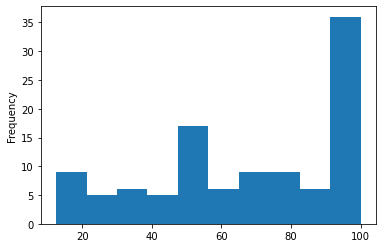

In [168]:
cindex_distro_ability.plot.hist(by='cindex')
plt.show()

This isn't relatively smooth exponential decay like the moves cindex was, so I won't use a log transform.  It's probably better to use pd.cut to look at the jumps like we did for the move power distro.

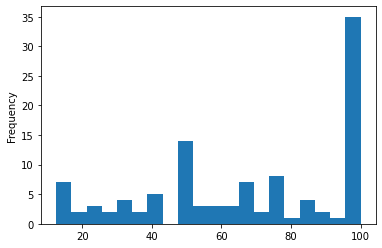

In [169]:
cindex_distro_ability.plot.hist(by='cindex', bins=20)
plt.show()

In [170]:
pd.cut(cindex_distro_ability, 20).value_counts().sort_index()

(12.412, 16.875]     7
(16.875, 21.25]      2
(21.25, 25.625]      3
(25.625, 30.0]       2
(30.0, 34.375]       4
(34.375, 38.75]      2
(38.75, 43.125]      5
(43.125, 47.5]       0
(47.5, 51.875]      14
(51.875, 56.25]      3
(56.25, 60.625]      3
(60.625, 65.0]       3
(65.0, 69.375]       7
(69.375, 73.75]      2
(73.75, 78.125]      8
(78.125, 82.5]       1
(82.5, 86.875]       4
(86.875, 91.25]      2
(91.25, 95.625]      1
(95.625, 100.0]     35
Name: cindex, dtype: int64

Ability cutoffs:
- 0 (basically, is it competitive at all?)
- 47.5 (pretty big cutoff, leading to a whole new "island")
- 65.0 (the final island before the big top)
- 73.75
- 95.625 (elite abilities)

<a id="ability_cutoff"></a>
### Aggregate Feature: Ability Cutoff

To start with, since pokemon have multiple abilities to choose from, we need to find out the best ability of each pokemon according to the ability cindexes.

In [171]:
abilitylist = list(cindex_distro_ability.index)
cindex_encoder = pokemon_abilities_df.loc[:, abilitylist + list(abilities_cindex.loc[(abilities_cindex['cindex'] == 100) & (abilities_cindex['n_abilityset'] == 1), :].index)].copy()
for ability in abilitylist:
    cindex_encoder.loc[cindex_encoder[ability] == 1, ability] = abilities_cindex.loc[ability, 'cindex']
bestability =  cindex_encoder.max(axis=1)
bestability.shape

(738,)

Now, we can simply create the feature according to the cutoffs we just decided on, where pokemon whose best ability is higher than the associated cutoff will be one-hot encoded as a 1, and those who don't have any ability as high as the indicated cutff will be encoded as a 0.

In [172]:
shrinkfeatures_df['Ability Cutoff 1'] = bestability.where(bestability == 0, 1)
shrinkfeatures_df['Ability Cutoff 1'].value_counts()

1.0    727
0.0     11
Name: Ability Cutoff 1, dtype: int64

In [173]:
shrinkfeatures_df['Ability Cutoff 2'] = bestability.where(bestability < 47.5, 1).where(bestability >= 47.5, 0)
shrinkfeatures_df['Ability Cutoff 2'].value_counts()

1.0    618
0.0    120
Name: Ability Cutoff 2, dtype: int64

In [174]:
shrinkfeatures_df['Ability Cutoff 3'] = bestability.where(bestability < 65, 1).where(bestability >= 65, 0)
shrinkfeatures_df['Ability Cutoff 3'].value_counts()

1.0    479
0.0    259
Name: Ability Cutoff 3, dtype: int64

In [175]:
shrinkfeatures_df['Ability Cutoff 4'] = bestability.where(bestability < 73.75, 1).where(bestability >= 73.75, 0)
shrinkfeatures_df['Ability Cutoff 4'].value_counts()

1.0    386
0.0    352
Name: Ability Cutoff 4, dtype: int64

In [176]:
shrinkfeatures_df['Ability Cutoff 5'] = bestability.where(bestability < 82.5, 1).where(bestability >= 82.5, 0)
shrinkfeatures_df['Ability Cutoff 5'].value_counts()

0.0    429
1.0    309
Name: Ability Cutoff 5, dtype: int64

In [177]:
shrinkfeatures_df['Ability Cutoff 6'] = bestability.where(bestability < 95.625, 1).where(bestability >= 95.625, 0)
shrinkfeatures_df['Ability Cutoff 6'].value_counts()

0.0    512
1.0    226
Name: Ability Cutoff 6, dtype: int64

<a id="other_ability"></a>
### Other Ability Features

Because it's not clear whether having a one-hot encoded feature for abilities, as we already have, is better than having a feature for abilities that just records the cindex of the best ability of each pokemon, we can also have a best ability cindex feature very easily:

In [178]:
shrinkfeatures_df['Best Ability'] = bestability
shrinkfeatures_df['Best Ability'].describe(percentiles = [n/20 for n in range(1, 20)])

count    738.000000
mean      70.687772
std       28.828267
min        0.000000
5%         1.000000
10%       27.272727
15%       40.000000
20%       50.000000
25%       54.545455
30%       60.000000
35%       64.285714
40%       66.666667
45%       70.000000
50%       75.000000
55%       76.923077
60%       83.333333
65%       88.888889
70%      100.000000
75%      100.000000
80%      100.000000
85%      100.000000
90%      100.000000
95%      100.000000
max      100.000000
Name: Best Ability, dtype: float64

I also want to done another feature which doesn't include any abilities with 100 cindex, since this gives the model more information about a few things in combination with the other ability features:
- who has 100 cindex abilities that aren't unique (since they would have 100 in bestability but wouldn't have a "unique powerful ability")
- who has 100 cindex abilities that are unique
- how good abilities are that aren't 100 cindex, making a more interesting and diverse distro

It's possible that this more convoluted feature won't end up being used in the final model, but it's easy to make since we simply have to adapt our code from before by adding some restrictions, so why not.

In [179]:
abilitylist_non100 = list(cindex_distro_ability[cindex_distro_ability < 100].index)
cindex_encoder_non100 = pokemon_abilities_df.loc[:, abilitylist_non100].copy()
for ability in abilitylist_non100:
    cindex_encoder_non100.loc[cindex_encoder_non100[ability] == 1, ability] = cindex_distro_ability[ability]
shrinkfeatures_df['Best Ability <100'] = cindex_encoder_non100.max(axis=1)
shrinkfeatures_df['Best Ability <100'].describe(percentiles = [n/20 for n in range(1, 20)])

count    738.000000
mean      49.216722
std       29.765971
min        0.000000
5%         0.000000
10%        0.000000
15%        0.000000
20%       16.666667
25%       26.315789
30%       33.333333
35%       40.000000
40%       50.000000
45%       50.000000
50%       55.555556
55%       61.538462
60%       65.217391
65%       66.666667
70%       66.666667
75%       75.000000
80%       75.000000
85%       77.777778
90%       85.714286
95%       88.888889
max       95.454545
Name: Best Ability <100, dtype: float64

And finally, we of course need our unique powerful ability feature. We shouldn't forget from our investigation in abilities_cindex that Dauntless Shield, Unseen Fist and RKS System are really unique powerful abilities even though they won't be listed as such since their n_abilityset is misleadingly listed as being higher than 1, so let's change abilities_cindex to fix this:

In [180]:
abilities_cindex.loc[['Dauntless Shield', 'Unseen Fist', 'RKS System'], ['n_abilityset', 'n_competitive']] = 1
abilities_cindex.loc[['Dauntless Shield', 'Unseen Fist', 'RKS System'], :]

n_abilityset  n_competitive  cindex
Dauntless Shield             1              1   100.0
Unseen Fist                  1              1   100.0
RKS System                   1              1   100.0

In [181]:
shrinkfeatures_df['Unique Powerful Ability'] = pokemon_abilities_df.loc[:, list(abilities_cindex.loc[(abilities_cindex['cindex'] == 100) & (abilities_cindex['n_abilityset'] == 1), :].index)].sum(axis=1)
shrinkfeatures_df['Unique Powerful Ability'].value_counts()

0    645
1     93
Name: Unique Powerful Ability, dtype: int64

There is still technically one more feature, but it's not really a new feature, it's just our target feature, format, as a number from 0 to 6 instead of a category, which may be imporant for some algorithms, especially since the tiers are ordinal, not just discrete.

In [182]:
pokemon_df['format codes'] = pd.Categorical(pokemon_df['formats'], categories=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber']).codes
pokemon_df.head(10)

hp  atk  def  spa  spd  spe  weight  height formats generation  \
name                                                                         
Bulbasaur   45   49   49   65   65   45     6.9     0.7      ZU         RB   
Ivysaur     60   62   63   80   80   60    13.0     1.0      ZU         RB   
Venusaur    80   82   83  100  100   80   100.0     2.0      OU         RB   
Charmander  39   52   43   60   50   65     8.5     0.6      ZU         RB   
Charmeleon  58   64   58   80   65   80    19.0     1.1      ZU         RB   
Charizard   78   84   78  109   85  100    90.5     1.7      PU         RB   
Squirtle    44   48   65   50   64   43     9.0     0.5      ZU         RB   
Wartortle   59   63   80   65   80   58    22.5     1.0      ZU         RB   
Blastoise   79   83  100   85  105   78    85.5     1.6      NU         RB   
Caterpie    45   30   35   20   20   45     2.9     0.3      ZU         RB   

            format codes  
name                      
Bulbasaur              0  
Ivysaur                0  
Venusaur               5  
Charmander             0  
Charmeleon             0  
Charizard              1  
Squirtle               0  
Wartortle              0  
Blastoise              2  
Caterpie               0

The final step is to put all of our data together in a single dataframe, combining pokemon_df (which contains the basic stats), pokemon_types_summary (which contains pokemon type information), and shrinkfeatures_df (which contains all manual and aggregate features we designed to summarize ability and move information):

In [183]:
pokemon_data = pokemon_df.merge(pokemon_types_summary, on='name')
pokemon_data = pokemon_data.merge(shrinkfeatures_df, on='name')
pokemon_data.head()

hp  atk  def  spa  spd  spe  weight  height formats generation  \
name                                                                         
Bulbasaur   45   49   49   65   65   45     6.9     0.7      ZU         RB   
Ivysaur     60   62   63   80   80   60    13.0     1.0      ZU         RB   
Venusaur    80   82   83  100  100   80   100.0     2.0      OU         RB   
Charmander  39   52   43   60   50   65     8.5     0.6      ZU         RB   
Charmeleon  58   64   58   80   65   80    19.0     1.1      ZU         RB   

            ...  Unique Powerful Move  Ability Cutoff 1  Ability Cutoff 2  \
name        ...                                                             
Bulbasaur   ...                     0               1.0               1.0   
Ivysaur     ...                     0               1.0               1.0   
Venusaur    ...                     0               1.0               1.0   
Charmander  ...                     0               1.0               1.0   
Charmeleon  ...                     0               1.0               1.0   

            Ability Cutoff 3  Ability Cutoff 4  Ability Cutoff 5  \
name                                                               
Bulbasaur                0.0               0.0               0.0   
Ivysaur                  0.0               0.0               0.0   
Venusaur                 0.0               0.0               0.0   
Charmander               0.0               0.0               0.0   
Charmeleon               0.0               0.0               0.0   

            Ability Cutoff 6  Best Ability  Best Ability <100  \
name                                                            
Bulbasaur                0.0     63.636364          63.636364   
Ivysaur                  0.0     63.636364          63.636364   
Venusaur                 0.0     63.636364          63.636364   
Charmander               0.0     50.000000          50.000000   
Charmeleon               0.0     50.000000          50.000000   

            Unique Powerful Ability  
name                                 
Bulbasaur                         0  
Ivysaur                           0  
Venusaur                          0  
Charmander                        0  
Charmeleon                        0  

[5 rows x 68 columns]

In [184]:
pokemon_data.columns

Index(['hp', 'atk', 'def', 'spa', 'spd', 'spe', 'weight', 'height', 'formats',
       'generation', 'format codes', 'Weaknesses', 'Strong Weaknesses',
       'Resists', 'Strong Resists', 'Immune', 'STAB', 'Resistance Index',
       'Entry Hazards', 'Hazard Removal', 'Removal Deterrent', 'Cleric',
       'Pivot', 'Item Removal', 'Setup', 'Priority', 'HP Drain', 'HP Recovery',
       'Weather Set', 'Weather Gimmick', 'Physical Cutoff 1',
       'Physical Cutoff 2', 'Physical Cutoff 3', 'Physical Cutoff 4',
       'Physical Cutoff 5', 'Physical Cutoff 6', 'Physical Coverage 1',
       'Physical Coverage 2', 'Physical Coverage 3', 'Physical Coverage 4',
       'Special Cutoff 1', 'Special Cutoff 2', 'Special Cutoff 3',
       'Special Cutoff 4', 'Special Cutoff 5', 'Special Cutoff 6',
       'Special Cutoff 7', 'Special Coverage 1', 'Special Coverage 2',
       'Special Coverage 3', 'Special Coverage 4', 'Special Coverage 5',
       'Special Coverage 6', 'Special Coverage 7', 'Special Cove

## Feature Selection and Visualizations

In [185]:
pokemon_data.shape

(738, 68)

In [186]:
pokemon_data.select_dtypes(include='number').shape

(738, 66)

<a id="removing_unnecessary"></a>
### Removing Obviously Unnecessary Features

We've narrowed down our features tremendously, going from hundreds of moves and abilities to having a total numeric feature count of 66. However, that's still not great for a multi-class classification problem given that it's only a bit less than one tenth of our sample size (738), and we also have lots of redundant features (e.g. many values for cutoff and coverage moves), so we can narrow our space of important features even more.

For starters, weight and height are rarely if ever used in pokemon, and whatever use they have would be so small that it would be completely overshadowed by other competitive attributes like the 6 major stats, the type, and features related to moves and abilities, so we can certainly get rid of weight and height.

We also designed our resistance index feature to summarize type information related to weaknesses, resistances and immunities, so having separate features for weaknesses, resistances and immunities taken out of context from their overall summary and relationship is not likely to be helpful (so we will remove all type summary information except the resistance index). The other one to remove is "STAB", since this feature (simply indicating whether a pokemon has 1 or 2 types) is not even close to impactful enough to predict the competitive viability of a pokemon (feel free to visit my EDA experiments if you doubt this since I tested the correlations of many features which isn't useful enough to put in this notebook but it made clear that many features are useless and most of them are much less impactful than the best features).

Of course we wouldn't include format codes as a feature since that is a version of the target feature.

The next major decision we have is which of the cutoff and coverage features to remove for moves and abilities. Probably the best we can do this is looking at their correlation with the target feature (in this case treated as a number: the ordinal format codes we just created) to see which one is likely to correlate best with competitive viability. We only need to use one cutoff and coverage feature from each of physical moves, special moves, and abilities, and we can also look at the correlations of other ability features we created which we are less certain about the usefulness of.

In [187]:
pokemon_data.loc[:, ['Physical Cutoff 1', 'Physical Cutoff 2', 'Physical Cutoff 3', 'Physical Cutoff 4', 'Physical Cutoff 5', 'Physical Cutoff 6']].corrwith(pokemon_data['format codes'])

Physical Cutoff 1    0.270197
Physical Cutoff 2    0.284223
Physical Cutoff 3    0.324136
Physical Cutoff 4    0.325190
Physical Cutoff 5    0.300717
Physical Cutoff 6    0.276238
dtype: float64

In [188]:
pokemon_data.loc[:, ['Physical Coverage 1', 'Physical Coverage 2', 'Physical Coverage 3', 'Physical Coverage 4']].corrwith(pokemon_data['format codes'])

Physical Coverage 1    0.241386
Physical Coverage 2    0.247097
Physical Coverage 3    0.301653
Physical Coverage 4    0.302690
dtype: float64

In [189]:
pokemon_data.loc[:, ['Special Cutoff 1', 'Special Cutoff 2', 'Special Cutoff 3', 'Special Cutoff 4', 'Special Cutoff 5', 'Special Cutoff 6', 'Special Cutoff 7']].corrwith(pokemon_data['format codes'])

Special Cutoff 1    0.314893
Special Cutoff 2    0.326647
Special Cutoff 3    0.347783
Special Cutoff 4    0.342295
Special Cutoff 5    0.322373
Special Cutoff 6    0.329574
Special Cutoff 7    0.245275
dtype: float64

In [190]:
pokemon_data.loc[:, ['Special Coverage 1', 'Special Coverage 2', 'Special Coverage 3', 'Special Coverage 4', 'Special Coverage 5', 'Special Coverage 6', 'Special Coverage 7', 'Special Coverage 8', 'Special Coverage 9', 'Special Coverage 10']].corrwith(pokemon_data['format codes'])

Special Coverage 1     0.243955
Special Coverage 2     0.267509
Special Coverage 3     0.273630
Special Coverage 4     0.285747
Special Coverage 5     0.332534
Special Coverage 6     0.435150
Special Coverage 7     0.450963
Special Coverage 8     0.494721
Special Coverage 9     0.499534
Special Coverage 10    0.535532
dtype: float64

In [191]:
pokemon_data.loc[:, ['Ability Cutoff 1', 'Ability Cutoff 2', 'Ability Cutoff 3', 'Ability Cutoff 4', 'Ability Cutoff 5', 'Ability Cutoff 6', 'Best Ability', 'Best Ability <100', 'Unique Powerful Ability']].corrwith(pokemon_data['format codes'])

Ability Cutoff 1           0.063815
Ability Cutoff 2           0.048313
Ability Cutoff 3           0.120181
Ability Cutoff 4           0.095327
Ability Cutoff 5           0.077595
Ability Cutoff 6           0.060640
Best Ability               0.070026
Best Ability <100         -0.034189
Unique Powerful Ability    0.043605
dtype: float64

First of all, it's just generally interesting that abilities (at least discretely) have less correlation with competitive viability than movesets. One reason could be that since abilities are far fewer, they may contain a lot more uninformative "0's" whereas movesets almost never have 0's in lower cutoffs.

For most of these, the choice is pretty obvious: the **number 3** version of each feature is the natural elbow point, so it's the one we'll use. This even includes the Ability Cutoff feature, but our Best Ability <100 feature has a NEGATIVE correlation with competitive viability. It was already suspected to be a pretty convoluted feature, so we should just get rid of it.

On another note, the special moves get strangely correlated to competitive viability the higher they get in power (as in the Special Coverage feature), which is strange because I know that's not really how moves are used in competitive play (maybe it just has to do with a handful of legendaries having powerful moves in that direction). So we should look at which moves are being ranked so highly, and calculate the median cindex for each cutoff group:

**Group 10:**

In [192]:
moves_cindex.loc[(moves_cindex['power']>=146) & (moves_cindex['category']=='Special'), :]

n_learnset  n_competitive     cindex  power     type category
Hyper Beam            353.0            0.0   0.000000  150.0   Normal  Special
Blast Burn              3.0            0.0   0.000000  150.0     Fire  Special
Eruption                4.0            0.0   0.000000  150.0     Fire  Special
Frenzy Plant            4.0            0.0   0.000000  150.0    Grass  Special
Hydro Cannon            4.0            0.0   0.000000  150.0    Water  Special
Water Spout             3.0            1.0  33.333333  150.0    Water  Special
Roar of Time            1.0            0.0   0.000000  150.0   Dragon  Special
Mind Blown              1.0            0.0   0.000000  150.0     Fire  Special
Prismatic Laser         3.0            0.0   0.000000  160.0  Psychic  Special
Shell Trap              1.0            0.0   0.000000  150.0     Fire  Special
Dragon Energy           1.0            0.0   0.000000  150.0   Dragon  Special
Eternabeam              1.0            0.0   0.000000  160.0   Dragon  Special

In [193]:
moves_cindex.loc[(moves_cindex['power']>=146) & (moves_cindex['category']=='Special'), 'cindex'].median(axis=0)

0.0

This is indeed very informative, because although more powerful pokemon may happen to have moves this powerful more frequently, the reality is that almost all of them have very low cindex, so choosing a cutoff this high is very uninformative for competitive viability, especially with unseen data.

**Group 9:**

In [194]:
moves_cindex.loc[(moves_cindex['power']>=139) & (moves_cindex['power']<146) & (moves_cindex['category']=='Special'), :]

n_learnset  n_competitive     cindex  power    type category
Doom Desire         1.0            0.0   0.000000  140.0   Steel  Special
Ice Burn            1.0            0.0   0.000000  140.0     Ice  Special
Boomburst           6.0            3.0  50.000000  140.0  Normal  Special
Steel Beam         51.0            2.0   3.921569  140.0   Steel  Special

In [195]:
moves_cindex.loc[(moves_cindex['power']>=139) & (moves_cindex['power']<146) & (moves_cindex['category']=='Special'), 'cindex'].median(axis=0)

1.9607843137254901

Boomburst is a great move, but it's not a coverage move because it's normal type, so that's not what it makes it good, and thus it isn't very informative for this feature (it can be covered in the move cutoff feature). The other moves here are generally weak.

**Group 8:**

In [196]:
moves_cindex.loc[(moves_cindex['power']>=118) & (moves_cindex['power']<139) & (moves_cindex['category']=='Special'), :]

n_learnset  n_competitive      cindex  power      type  \
Petal Dance            9.0            0.0    0.000000  120.0     Grass   
Zap Cannon            54.0            0.0    0.000000  120.0  Electric   
Future Sight          59.0            9.0   15.254237  120.0   Psychic   
Overheat              37.0            9.0   24.324324  130.0      Fire   
Draco Meteor          51.0           21.0   41.176471  130.0    Dragon   
Leaf Storm            25.0           12.0   48.000000  130.0     Grass   
Focus Blast          142.0           30.0   21.126761  120.0  Fighting   
Techno Blast           1.0            0.0    0.000000  120.0    Normal   
Blue Flare             2.0            1.0   50.000000  130.0      Fire   
Belch                 22.0            0.0    0.000000  120.0    Poison   
Burn Up                5.0            0.0    0.000000  130.0      Fire   
Fleur Cannon           1.0            1.0  100.000000  130.0     Fairy   
Astral Barrage         1.0            1.0  100.000000  120.0     Ghost   

               category  
Petal Dance     Special  
Zap Cannon      Special  
Future Sight    Special  
Overheat        Special  
Draco Meteor    Special  
Leaf Storm      Special  
Focus Blast     Special  
Techno Blast    Special  
Blue Flare      Special  
Belch           Special  
Burn Up         Special  
Fleur Cannon    Special  
Astral Barrage  Special

In [197]:
moves_cindex.loc[(moves_cindex['power']>=118) & (moves_cindex['power']<139) & (moves_cindex['category']=='Special'), 'cindex'].median(axis=0)

21.12676056338028

This is starting to look like possibly a good feature, but there are a lot of unique powerful moves here which are less informative due to sampple size of n_learnset=1.

**Group 7:**

In [198]:
moves_cindex.loc[(moves_cindex['power']>=104) & (moves_cindex['power']<118) & (moves_cindex['category']=='Special'), :]

n_learnset  n_competitive      cindex  power      type  \
Blizzard              113.0            4.0    3.539823  110.0       Ice   
Fire Blast             84.0           22.0   26.190476  110.0      Fire   
Thunder               114.0           11.0    9.649123  110.0  Electric   
Hydro Pump             78.0           22.0   28.205128  110.0     Water   
Hurricane              37.0           16.0   43.243243  110.0    Flying   
Origin Pulse            1.0            1.0  100.000000  110.0     Water   
Steam Eruption          1.0            1.0  100.000000  110.0     Water   
Clanging Scales         1.0            1.0  100.000000  110.0    Dragon   

                category  
Blizzard         Special  
Fire Blast       Special  
Thunder          Special  
Hydro Pump       Special  
Hurricane        Special  
Origin Pulse     Special  
Steam Eruption   Special  
Clanging Scales  Special

In [199]:
moves_cindex.loc[(moves_cindex['power']>=104) & (moves_cindex['power']<118) & (moves_cindex['category']=='Special'), 'cindex'].median(axis=0)

35.72418572418572

This one is a whole different level of good, as most of these moves are informative. Group 7 is the best so far.

**Group 6:**

In [200]:
moves_cindex.loc[(moves_cindex['power']>=97) & (moves_cindex['power']<104) & (moves_cindex['category']=='Special'), :]

n_learnset  n_competitive      cindex  power     type category
Dream Eater           96.0            0.0    0.000000  100.0  Psychic  Special
Aeroblast              1.0            0.0    0.000000  100.0   Flying  Special
Magma Storm            1.0            1.0  100.000000  100.0     Fire  Special
Spacial Rend           1.0            1.0  100.000000  100.0   Dragon  Special
Fusion Flare           3.0            1.0   33.333333  100.0     Fire  Special
Inferno                8.0            0.0    0.000000  100.0     Fire  Special
Psystrike              1.0            1.0  100.000000  100.0  Psychic  Special
Searing Shot           1.0            0.0    0.000000  100.0     Fire  Special
Core Enforcer          2.0            0.0    0.000000  100.0   Dragon  Special
Moongeist Beam         2.0            2.0  100.000000  100.0    Ghost  Special
Photon Geyser          3.0            1.0   33.333333  100.0  Psychic  Special
Dynamax Cannon         1.0            1.0  100.000000  100.0   Dragon  Special

This is a huge concentration of low sample size moves, so I think it's not potentially informative. Group 7 is still the best.

**Group 5:**

In [201]:
moves_cindex.loc[(moves_cindex['power']>=76) & (moves_cindex['power']<97) & (moves_cindex['category']=='Special'), :]

n_learnset  n_competitive      cindex  power      type  \
Psychic              132.0           37.0   28.030303   90.0   Psychic   
Tri Attack            49.0            3.0    6.122449   80.0    Normal   
Surf                 112.0           14.0   12.500000   90.0     Water   
Flamethrower         103.0           37.0   35.922330   90.0      Fire   
Ice Beam             133.0           36.0   27.067669   90.0       Ice   
Thunderbolt          136.0           30.0   22.058824   90.0  Electric   
Shadow Ball          167.0           30.0   17.964072   80.0     Ghost   
Sludge Bomb           74.0           22.0   29.729730   90.0    Poison   
Extrasensory          34.0            0.0    0.000000   80.0   Psychic   
Uproar               122.0            0.0    0.000000   90.0    Normal   
Heat Wave             73.0            8.0   10.958904   95.0      Fire   
Hyper Voice          104.0            6.0    5.769231   90.0    Normal   
Muddy Water           45.0            0.0    0.000000   90.0     Water   
Aura Sphere           25.0            4.0   16.000000   80.0  Fighting   
Bug Buzz              21.0            6.0   28.571429   90.0       Bug   
Dragon Pulse          66.0            5.0    7.575758   85.0    Dragon   
Energy Ball           96.0           10.0   10.416667   90.0     Grass   
Power Gem             20.0            2.0   10.000000   80.0      Rock   
Dark Pulse            96.0           11.0   11.458333   80.0      Dark   
Discharge             37.0            6.0   16.216216   80.0  Electric   
Earth Power           91.0           13.0   14.285714   90.0    Ground   
Flash Cannon          79.0            7.0    8.860759   80.0     Steel   
Lava Plume             6.0            2.0   33.333333   80.0      Fire   
Fire Pledge            4.0            0.0    0.000000   80.0      Fire   
Grass Pledge          16.0            1.0    6.250000   80.0     Grass   
Scald                 61.0           29.0   47.540984   80.0     Water   
Water Pledge           4.0            0.0    0.000000   80.0     Water   
Fiery Dance            1.0            0.0    0.000000   80.0      Fire   
Night Daze             2.0            0.0    0.000000   85.0      Dark   
Psyshock              74.0           16.0   21.621622   80.0   Psychic   
Secret Sword           1.0            1.0  100.000000   85.0  Fighting   
Sludge Wave           47.0           10.0   21.276596   95.0    Poison   
Dazzling Gleam        74.0           19.0   25.675676   80.0     Fairy   
Moonblast             27.0           18.0   66.666667   95.0     Fairy   
Pollen Puff           12.0            2.0   16.666667   90.0       Bug   
Sparkling Aria         2.0            0.0    0.000000   90.0     Water   
Apple Acid             1.0            1.0  100.000000   80.0     Grass   
Eerie Spell            1.0            0.0    0.000000   80.0   Psychic   
Fiery Wrath            1.0            1.0  100.000000   90.0      Dark   
Freezing Glare         1.0            0.0    0.000000   90.0   Psychic   
Overdrive              1.0            1.0  100.000000   80.0  Electric   
Shell Side Arm         1.0            0.0    0.000000   90.0    Poison   
Snipe Shot             1.0            0.0    0.000000   80.0     Water   
Strange Steam          1.0            1.0  100.000000   90.0     Fairy   
Thunder Cage           1.0            0.0    0.000000   80.0  Electric   

               category  
Psychic         Special  
Tri Attack      Special  
Surf            Special  
Flamethrower    Special  
Ice Beam        Special  
Thunderbolt     Special  
Shadow Ball     Special  
Sludge Bomb     Special  
Extrasensory    Special  
Uproar          Special  
Heat Wave       Special  
Hyper Voice     Special  
Muddy Water     Special  
Aura Sphere     Special  
Bug Buzz        Special  
Dragon Pulse    Special  
Energy Ball     Special  
Power Gem       Special  
Dark Pulse      Special  
Discharge       Special  
Earth Power     Special  
Flash Cannon    Special  
Lava Plume   

In [202]:
moves_cindex.loc[(moves_cindex['power']>=76) & (moves_cindex['power']<97) & (moves_cindex['category']=='Special'), 'cindex'].median(axis=0)

12.5

Unfortunately, I'm inclined to think this one **TRULY IS** informative, knowing a lot of competitive moves are in this category, but its median cindex isn't huge (though it's not small either), there might just be a lot of garbage here too.

**Group 4:**

In [203]:
moves_cindex.loc[(moves_cindex['power']>=55) & (moves_cindex['power']<76) & (moves_cindex['category']=='Special'), :]

n_learnset  n_competitive     cindex  power      type  \
Aurora Beam             17.0            0.0   0.000000   65.0       Ice   
Bubble Beam             50.0            0.0   0.000000   65.0     Water   
Sludge                   7.0            0.0   0.000000   65.0    Poison   
Psybeam                 40.0            1.0   2.500000   65.0   Psychic   
Swift                  203.0            0.0   0.000000   60.0    Normal   
Ancient Power           82.0            1.0   1.219512   60.0      Rock   
Dragon Breath           38.0            0.0   0.000000   60.0    Dragon   
Icy Wind               144.0            2.0   1.388889   55.0       Ice   
Octazooka                3.0            0.0   0.000000   65.0     Water   
Air Cutter              34.0            0.0   0.000000   60.0    Flying   
Luster Purge             1.0            0.0   0.000000   70.0   Psychic   
Magical Leaf            37.0            0.0   0.000000   60.0     Grass   
Mist Ball                0.0            0.0        NaN   70.0   Psychic   
Mud Shot                70.0            1.0   1.428571   55.0    Ground   
Shock Wave             133.0            0.0   0.000000   60.0  Electric   
Water Pulse            100.0            2.0   2.000000   60.0     Water   
Air Slash               68.0           10.0  14.705882   75.0    Flying   
Brine                   49.0            0.0   0.000000   65.0     Water   
Frost Breath            17.0            0.0   0.000000   60.0       Ice   
Hex                     59.0           10.0  16.949153   65.0     Ghost   
Incinerate              84.0            0.0   0.000000   60.0      Fire   
Round                  413.0            0.0   0.000000   60.0    Normal   
Snarl                   72.0            3.0   4.166667   55.0      Dark   
Electroweb              31.0            0.0   0.000000   55.0  Electric   
Glaciate                 4.0            1.0  25.000000   65.0       Ice   
Leaf Tornado             2.0            0.0   0.000000   65.0     Grass   
Venoshock               42.0            0.0   0.000000   65.0    Poison   
Mystical Fire           35.0           12.0  34.285714   75.0      Fire   
Parabolic Charge         1.0            0.0   0.000000   65.0  Electric   
Freeze-Dry              18.0           13.0  72.222222   70.0       Ice   
Burning Jealousy        23.0            2.0   8.695652   70.0      Fire   
Scorching Sands         45.0            5.0  11.111111   70.0    Ground   

                 category  
Aurora Beam       Special  
Bubble Beam       Special  
Sludge            Special  
Psybeam           Special  
Swift             Special  
Ancient Power     Special  
Dragon Breath     Special  
Icy Wind          Special  
Octazooka         Special  
Air Cutter        Special  
Luster Purge      Special  
Magical Leaf      Special  
Mist Ball         Special  
Mud Shot          Special  
Shock Wave        Special  
Water Pulse       Special  
Air Slash         Special  
Brine             Special  
Frost Breath      Special  
Hex               Special  
Incinerate        Special  
Round             Special  
Snarl             Special  
Electroweb        Special  
Glaciate          Special  
Leaf Tornado      Special  
Venoshock         Special  
Mystical Fire     Special  
Parabolic Charge  Special  
Freeze-Dry        Special  
Burning Jealousy  Special  
Scorching Sands   Special

In [204]:
moves_cindex.loc[(moves_cindex['power']>=55) & (moves_cindex['power']<76) & (moves_cindex['category']=='Special'), 'cindex'].median(axis=0)

0.0

This one is garbage and I suspect all below it will be as well

**Group 3:**

In [205]:
moves_cindex.loc[(moves_cindex['power']>=48) & (moves_cindex['power']<55) & (moves_cindex['category']=='Special'), :]

n_learnset  n_competitive     cindex  power      type category
Confusion           55.0            0.0   0.000000   50.0   Psychic  Special
Snore              413.0            0.0   0.000000   50.0    Normal  Special
Charge Beam         90.0            0.0   0.000000   50.0  Electric  Special
Struggle Bug        25.0            0.0   0.000000   50.0       Bug  Special
Clear Smog          14.0            2.0  14.285714   50.0    Poison  Special

This one is obviously no good.

**Group 2:**

In [206]:
moves_cindex.loc[(moves_cindex['power']>=34) & (moves_cindex['power']<48) & (moves_cindex['category']=='Special'), :]

n_learnset  n_competitive    cindex  power      type category
Acid                   15.0            0.0  0.000000   40.0    Poison  Special
Fire Spin              35.0            2.0  5.714286   35.0      Fire  Special
Gust                   25.0            0.0  0.000000   40.0    Flying  Special
Mega Drain             33.0            0.0  0.000000   40.0     Grass  Special
Ember                  21.0            0.0  0.000000   40.0      Fire  Special
Thunder Shock          32.0            0.0  0.000000   40.0  Electric  Special
Water Gun              71.0            0.0  0.000000   40.0     Water  Special
Whirlpool              76.0            0.0  0.000000   35.0     Water  Special
Powder Snow            15.0            0.0  0.000000   40.0       Ice  Special
Twister                38.0            0.0  0.000000   40.0    Dragon  Special
Echoed Voice           94.0            0.0  0.000000   40.0    Normal  Special
Acid Spray             14.0            0.0  0.000000   40.0    Poison  Special
Disarming Voice        31.0            0.0  0.000000   40.0     Fairy  Special
Fairy Wind             12.0            0.0  0.000000   40.0     Fairy  Special

So the rest of the lower powered moves are not competitively viable, thus my two choices for special coverage seem pretty obvious (5 or 7). I will choose just one of them (the lower one, group 5) for the sake of conciseness and because it includes both the informative groups whereas choosing 7 will exclude the informative group 5 which contains many of the most common coverage moves. Including anything below group 5 makes no sense.

<a id="pca"></a>
### Principal Component Analysis

Before performing our likely far more successful and useful PCA, on account of having such a smaller number of features, let's remind ourselves of all the columns that we will be removing from consideration in our current iteration of pokemon_data:

'weight', 'height', 'format codes', 'Weaknesses', 'Strong Weaknesses', 'Resists', 'Strong Resists', 'Immune', 'STAB', 'Physical Cutoff 1', 'Physical Cutoff 2', 'Physical Cutoff 4', 'Physical Cutoff 5', 'Physical Cutoff 6', 'Physical Coverage 1', 'Physical Coverage 2', 'Physical Coverage 4', 'Special Cutoff 1', 'Special Cutoff 2', 'Special Cutoff 4', 'Special Cutoff 5', 'Special Cutoff 6', 'Special Cutoff 7', 'Special Coverage 1', 'Special Coverage 2', 'Special Coverage 3', 'Special Coverage 4', 'Special Coverage 6', 'Special Coverage 7', 'Special Coverage 8', 'Special Coverage 9', 'Special Coverage 10', 'Ability Cutoff 1', 'Ability Cutoff 2', 'Ability Cutoff 4', 'Ability Cutoff 5', 'Ability Cutoff 6', 'Best Ability <100'

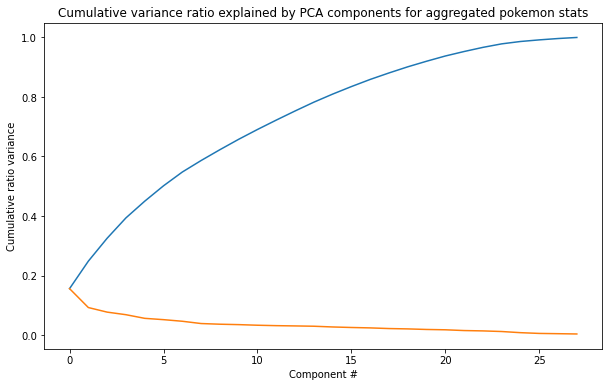

In [207]:
pokemon_data_pca = pokemon_data.drop(columns=['weight', 'height', 'format codes', 'Weaknesses', 'Strong Weaknesses', 'Resists',
                                              'Strong Resists', 'Immune', 'STAB', 'Physical Cutoff 1', 'Physical Cutoff 2',
                                              'Physical Cutoff 4', 'Physical Cutoff 5', 'Physical Cutoff 6',
                                              'Physical Coverage 1', 'Physical Coverage 2', 'Physical Coverage 4',
                                              'Special Cutoff 1', 'Special Cutoff 2', 'Special Cutoff 4',
                                              'Special Cutoff 5', 'Special Cutoff 6', 'Special Cutoff 7',
                                              'Special Coverage 1', 'Special Coverage 2', 'Special Coverage 3',
                                              'Special Coverage 4', 'Special Coverage 6', 'Special Coverage 7',
                                              'Special Coverage 8', 'Special Coverage 9', 'Special Coverage 10',
                                              'Ability Cutoff 1', 'Ability Cutoff 2', 'Ability Cutoff 4', 'Ability Cutoff 5',
                                              'Ability Cutoff 6', 'Best Ability <100'])

pokemon_data_nonnumeric = pokemon_data_pca.select_dtypes(include='object', exclude='number')
pokemon_data_numeric = pokemon_data_pca.select_dtypes(include='number')
data_scaled = scale(pokemon_data_numeric)
pokemon_data_scaled = pd.DataFrame(data_scaled, index=pokemon_data.index, columns=pokemon_data_numeric.columns)
pokemon_data_fit = PCA().fit(pokemon_data_scaled)

plt.subplots(figsize=(10, 6))
plt.plot(pokemon_data_fit.explained_variance_ratio_.cumsum())
plt.plot(pokemon_data_fit.explained_variance_ratio_)
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for aggregated pokemon stats');

In [208]:
pokemon_data_fit.components_.shape

(28, 28)

Only 28 components is amazing compared to the 100's of components we had previously, and is FAR more useful.

In [209]:
pokemon_data_compdf = pd.DataFrame(pokemon_data_fit.components_, columns=pokemon_data_numeric.columns)
pokemon_data_compdf.head()

hp       atk       def       spa       spd       spe  \
0  0.292529  0.290580  0.228237  0.322763  0.296457  0.215643   
1  0.058455  0.322214  0.208986 -0.214476 -0.090800 -0.011680   
2 -0.063800 -0.012251 -0.031023  0.089784  0.019185  0.197422   
3  0.132370 -0.097197  0.224501 -0.036549  0.187039 -0.368777   
4 -0.063297  0.003124 -0.130240 -0.122939 -0.131708 -0.038420   

   Resistance Index  Entry Hazards  Hazard Removal  Removal Deterrent  ...  \
0          0.050405      -0.017300        0.085232           0.027921  ...   
1          0.009699       0.187946       -0.126154          -0.063162  ...   
2          0.165646      -0.177491        0.153131           0.069995  ...   
3          0.043186       0.230547       -0.235254           0.036495  ...   
4          0.044727      -0.011485       -0.016400           0.194679  ...   

   Weather Gimmick  Physical Cutoff 3  Physical Coverage 3  Special Cutoff 3  \
0         0.050268           0.275777             0.266815          0.349974   
1        -0.164052           0.370041             0.330131         -0.211405   
2        -0.110972          -0.150424            -0.165476          0.021847   
3         0.012443           0.025713            -0.031456          0.119847   
4         0.051134           0.186024             0.248867          0.018569   

   Special Coverage 5  Misc Status  Unique Powerful Move  Ability Cutoff 3  \
0            0.355463     0.174814              0.203015          0.089447   
1           -0.167959    -0.299766              0.076086         -0.163002   
2            0.024579     0.079281              0.175157         -0.441778   
3            0.143488     0.055433             -0.038966         -0.302081   
4            0.044074     0.083415             -0.273544         -0.196494   

   Best Ability  Unique Powerful Ability  
0      0.079612                 0.058149  
1     -0.170631                 0.077706  
2     -0.496561                 0.427848  
3     -0.270582                 0.018261  
4     -0.168088                -0.073380  

[5 rows x 28 columns]

We can also zoom in on the scree plot a little more to get a more precise idea of where the elbow is.

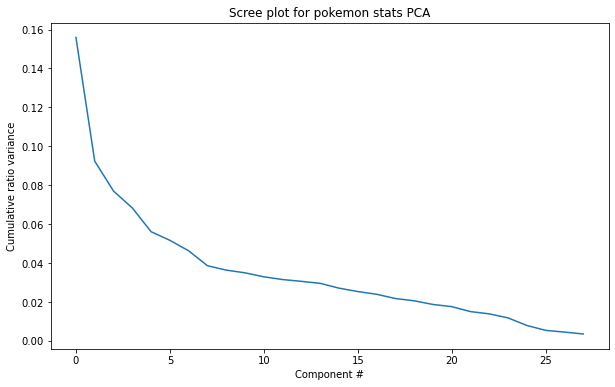

In [210]:
plt.subplots(figsize=(10, 6))
plt.plot(pokemon_data_fit.explained_variance_ratio_)
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Scree plot for pokemon stats PCA');

The elbow is around 6 or 7 components, so that's probably all we have to look at deeply for our analysis, as after that the components become individually quite insignificant.

**First component:**

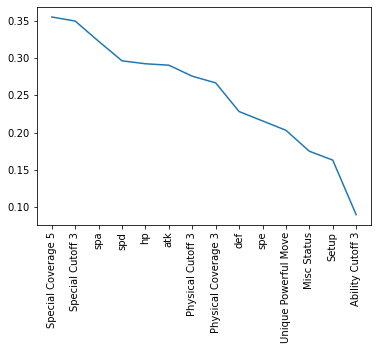

In [211]:
plt.plot(pokemon_data_compdf.loc[0, :].sort_values(ascending=False).head(14))
plt.xticks(rotation = 90)
plt.show()

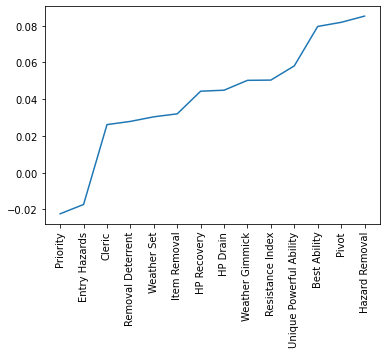

In [212]:
plt.plot(pokemon_data_compdf.loc[0, :].sort_values().head(14))
plt.xticks(rotation = 90)
plt.show()

So this feature mainly captures the stats and move access of pokemon, what overall threat they represent, which makes sense as the strongest component. The few negative features are cheesy tactics that don't depend on stats so much, such as priority moves and entry hazards, so it makes sense why they'd be negatively correlated here.

**Second component:**

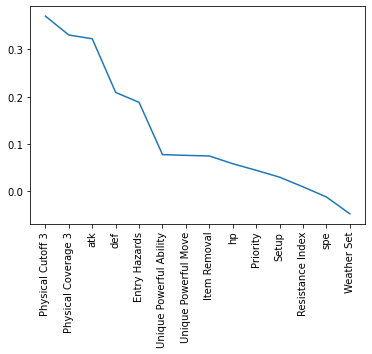

In [213]:
plt.plot(pokemon_data_compdf.loc[1, :].sort_values(ascending=False).head(14))
plt.xticks(rotation = 90)
plt.show()

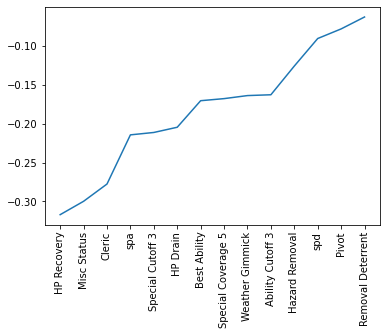

In [214]:
plt.plot(pokemon_data_compdf.loc[1, :].sort_values().head(14))
plt.xticks(rotation = 90)
plt.show()

This feature mainly captures the physical power of a pokemon (physical movesets, attack and defense), combined with entry hazard setting ability on the positive side, and on the negative side are mainly status oriented moves and special attack and abilities (which may indeed be opposite to a more direct physically oriented pokemon)

**Third component:**

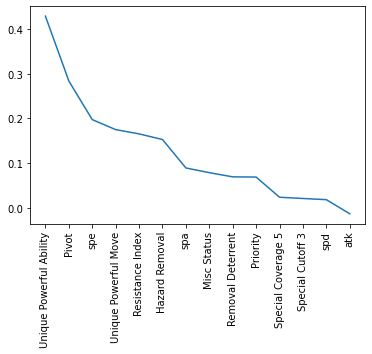

In [215]:
plt.plot(pokemon_data_compdf.loc[2, :].sort_values(ascending=False).head(14))
plt.xticks(rotation = 90)
plt.show()

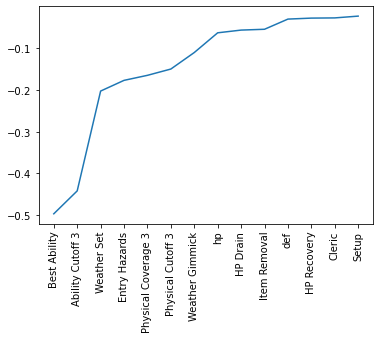

In [216]:
plt.plot(pokemon_data_compdf.loc[2, :].sort_values().head(14))
plt.xticks(rotation = 90)
plt.show()

This is a very interesting feature which heavily prioritizes having a unique powerful ability, rather than a good overall best ability or high ability cutoff point (including weather set or gimmick). It also looks favorably upon resistance index, pivot, speed and misc status, so it might be a feature that's measuring a certain kind of pivot that has a unique ability

**Fourth component:**

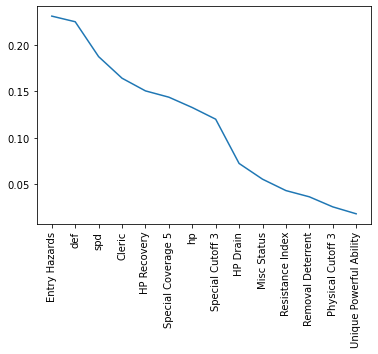

In [217]:
plt.plot(pokemon_data_compdf.loc[3, :].sort_values(ascending=False).head(14))
plt.xticks(rotation = 90)
plt.show()

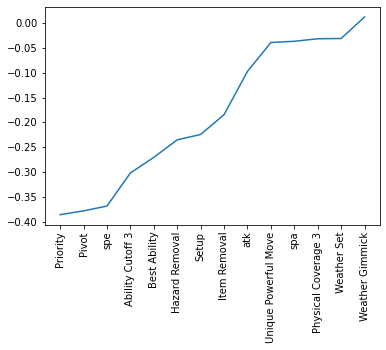

In [218]:
plt.plot(pokemon_data_compdf.loc[3, :].sort_values().head(14))
plt.xticks(rotation = 90)
plt.show()

This is a defensive feature, prioritizing entry hazard setting, def, spd, cleric and hp recovery, and hp itself. It is opposed to fast pivots with priority moves and hazard removal, as well as setup sweepers, who are perhaps the opposite.

**Fifth component:**

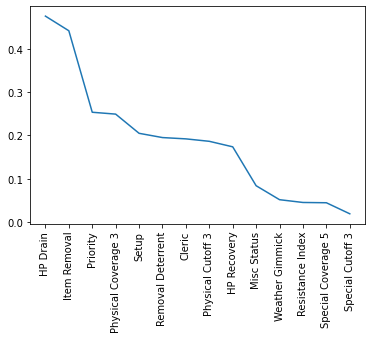

In [219]:
plt.plot(pokemon_data_compdf.loc[4, :].sort_values(ascending=False).head(14))
plt.xticks(rotation = 90)
plt.show()

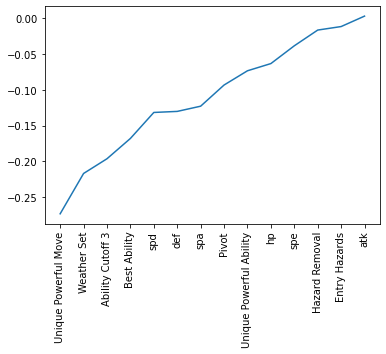

In [220]:
plt.plot(pokemon_data_compdf.loc[4, :].sort_values().head(14))
plt.xticks(rotation = 90)
plt.show()

Here is a feature that is a bit stranger and harder to interpret, it really prioritzes HP Drain and Item removal, which is an odd combination, and to a lesser extent, physical moveset, priority, setup, hp recovery and cleric and removal deterrent are prioritized. It's heavily against unique powerful moves, and to a lesser extent, pivoting, weather setting and general stats (so it's more about the useful moves and abilities a pokemon has to stay alive perhaps, regardless of stats, or perhaps about physical sweepers that use priority and recovery moves like drain punch, which may be a common trope).

**Sixth component:**

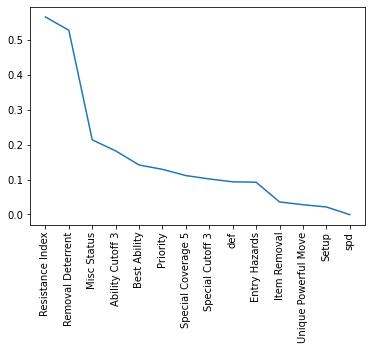

In [221]:
plt.plot(pokemon_data_compdf.loc[5, :].sort_values(ascending=False).head(14))
plt.xticks(rotation = 90)
plt.show()

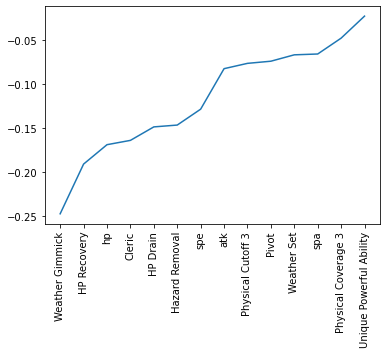

In [222]:
plt.plot(pokemon_data_compdf.loc[5, :].sort_values().head(14))
plt.xticks(rotation = 90)
plt.show()

This is another feature measuring intangibles, like resistance index and removal deterrent especially, as well as misc status moves and ability rating, positively, and negatively correlated to weather gimmick and setting (perhaps because those are special abilities) and even more often hp, and any sort of hp recovery, drain, cleric, etc. (so perhaps it's intangles that keep pokemon alive other than direct hp and hp recovery, such as their type, ability and status moves).

**Seventh component:**

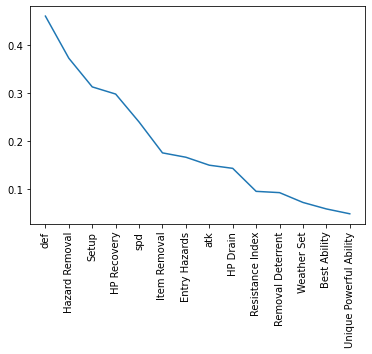

In [223]:
plt.plot(pokemon_data_compdf.loc[6, :].sort_values(ascending=False).head(14))
plt.xticks(rotation = 90)
plt.show()

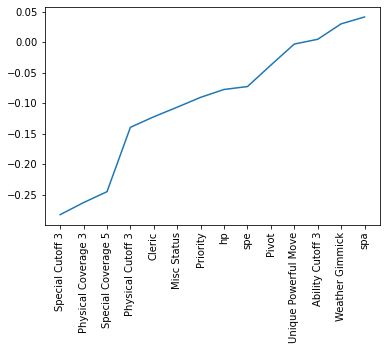

In [224]:
plt.plot(pokemon_data_compdf.loc[6, :].sort_values().head(14))
plt.xticks(rotation = 90)
plt.show()

This feature seems to be about staying alive and setting up, due to high defense, special defense, entry hazards and removal, setup and hp recovery, and it is negatively correlated with other moves the pokemon has (physical and special).

Now, I'd look to do pairplots of these seven components, so there are not too many, to get an idea of the actual shape of the data

In [225]:
pokemon_data_comp = pokemon_data_fit.transform(pokemon_data_scaled)
pokemon_data_pcadf = pd.DataFrame(pokemon_data_comp, index=pokemon_data.index)
pokemon_data_pcadf['formats'] = pokemon_data['formats']
pokemon_data_pcadf.head()

0         1         2         3         4         5  \
name                                                                     
Bulbasaur  -1.713514 -1.831390  0.015047  0.732663  2.115891 -0.988950   
Ivysaur    -0.895094 -1.725419  0.116549  0.760688  1.871457 -1.172140   
Venusaur    0.838643 -1.461947  0.150654  0.951734  1.753125 -1.349979   
Charmander -1.389595  0.871759  0.323135 -0.021592  0.818681 -0.321924   
Charmeleon -0.478317  0.947587  0.429359  0.030283  0.540688 -0.534603   

                   6         7         8         9  ...        19        20  \
name                                                ...                       
Bulbasaur   0.891259 -0.010846 -0.838784  0.244057  ... -0.117148 -0.765284   
Ivysaur     1.237336  0.490807 -0.931300 -0.074361  ... -0.105319 -0.812415   
Venusaur    1.297541  0.916270 -1.147363 -0.304011  ...  0.010157 -0.836046   
Charmander -1.438897  0.032454 -0.805936  0.182313  ... -0.005457 -0.967178   
Charmeleon -1.087209  0.571344 -0.894775 -0.196009  ... -0.000231 -0.946702   

                  21        22        23        24        25        26  \
name                                                                     
Bulbasaur   0.408721  0.594439 -0.018471 -0.250585 -0.654390  0.366285   
Ivysaur     0.469127  0.594994 -0.156022 -0.175018 -0.666552  0.332685   
Venusaur    0.486265  0.464879 -0.405938 -0.072551 -0.731089  0.235426   
Charmander -0.059527  0.956971  0.747617  0.265333 -0.405225 -0.074479   
Charmeleon  0.085509  0.970859  0.666081  0.439069 -0.422955 -0.131151   

                  27  formats  
name                           
Bulbasaur   0.238484       ZU  
Ivysaur     0.287664       ZU  
Venusaur   -0.065291       OU  
Charmander  0.478516       ZU  
Charmeleon  0.534876       ZU  

[5 rows x 29 columns]

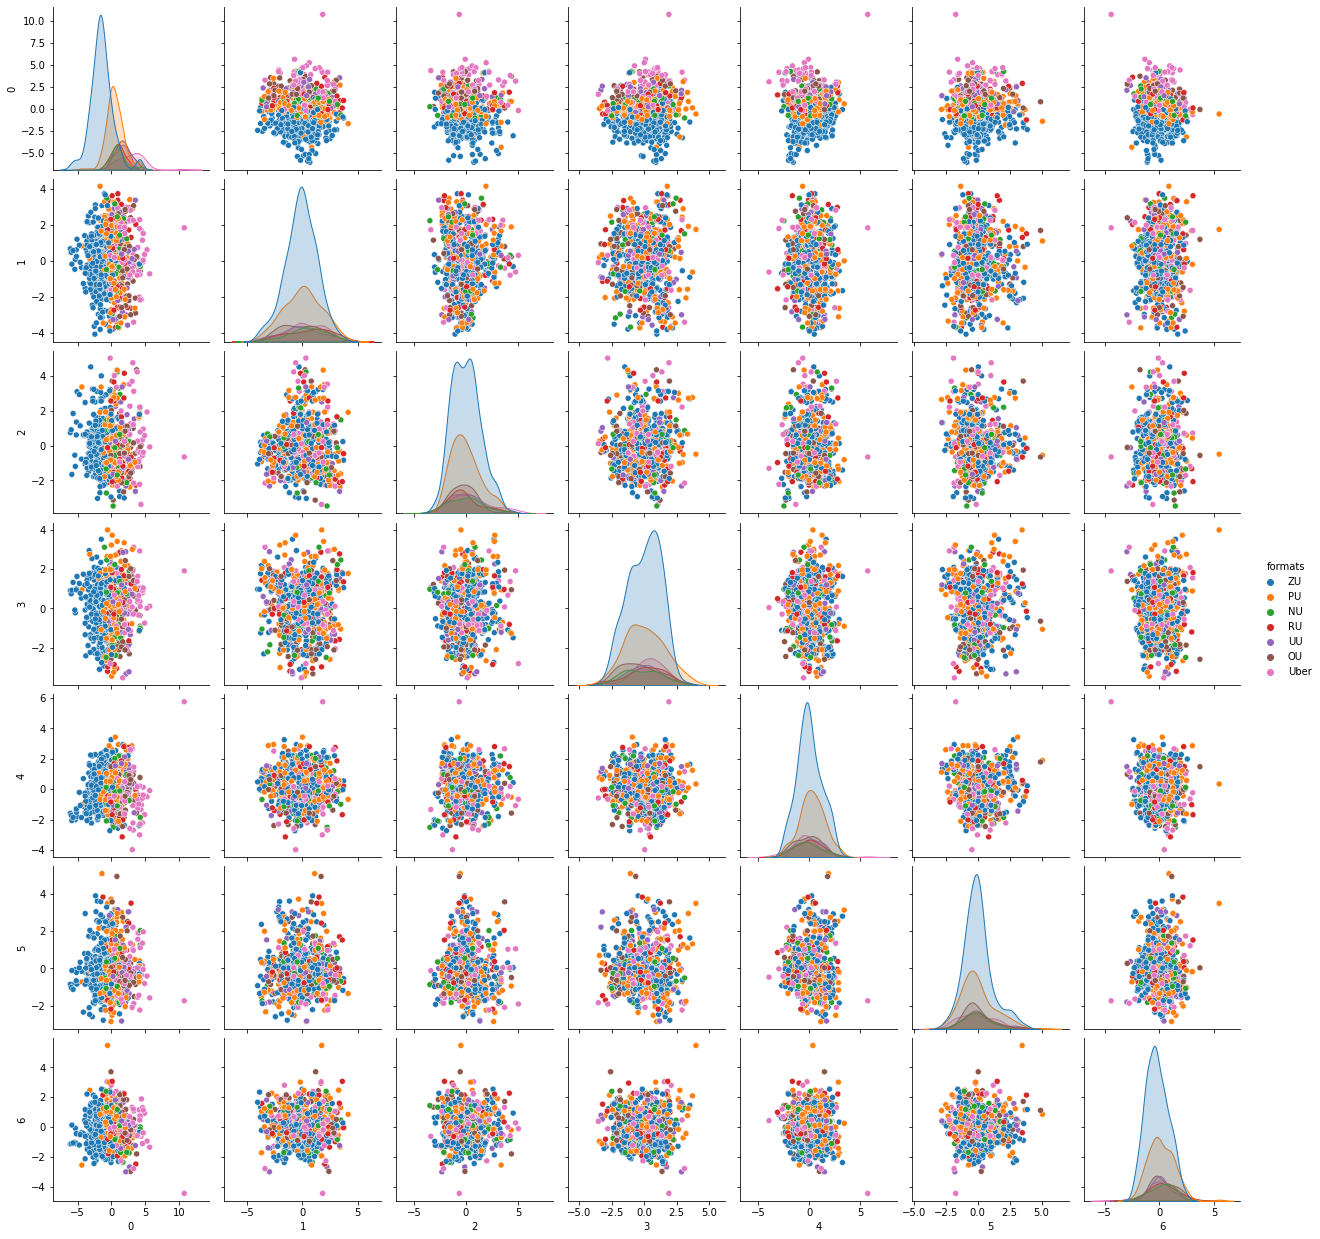

In [226]:
pairplot_pcadf_list = [n for n in range(7)]
pairplot_pcadf_list.append('formats')
sns.pairplot(pokemon_data_pcadf.loc[:, pairplot_pcadf_list], hue='formats', hue_order=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])
plt.show()

On the outer left and upward edges of the charts, we can see correlations with the first components which do cluster pretty well around the tier due to the neater cascade of colors. This makes sense since that first component was based a lot on overall stats, which is expected to correlate well with overall competitive viability. However, most of the other charts moving down and towards the right are just a mess of color, so don't correlate well to tier at all. That's not necessarily bad though, as they may help more with making differentiations within tier, rather than predicting it as directly as stats.

The general lack of clustering is also interesting, as it indicates that using PCA for our clustering algorithms later probably won't be helpful compared to just clustering the data directly. Also, it's likely that more artificial, forced clustering techniques like K-Means will work better than techniques that find more natural clusters like density-based clustering, since there aren't particularly good natural clusters (and it's more likely to just find outliers, as we will discover later).

<a id="data_prep"></a>
### Preparing the Data for OOTB Modeling

Now we're going to try some out of the box modeling, not significantly optimized for performance but more to get feedback about the features in our data. In particular, we want to look at the general performance of some different algorithms, as well as what coefficients and importances are assigned to the features so that we can see what features are putting in the most work and which are not very useful.

To do that, we need to prepare our data in the form of an X and y variable typically used in machine learning.

For our y variable, we will need to use several versions to have an idea of what target variable is best to use.  We could try up to 6:
- competitive or not competitive (binary classification)
- 4 classes: (ZU, PU, NU+RU+UU, OU+Uber)
- all 7 classes at once
And each of those have one variation with the tierchange work we did, and one variation without it

And I can also do a linreg variation on each one of those (classic lasso), with the exception of the 2 classes version, since there is no point of doing linear regression in such a case.

Let's start with getting back our old formats target variable from before we modified it with tierchange_df:

In [227]:
oldformats = pd.read_csv('./data/pokemon_df.csv', index_col="name")['formats']
oldformats[oldformats == 'LC'] = 'ZU'
oldformats[oldformats == 'NFE'] = 'ZU'
oldformats[oldformats == 'Untiered'] = 'ZU'
oldformats[oldformats == 'PUBL'] = 'NU'
oldformats[oldformats == 'NUBL'] = 'RU'
oldformats[oldformats == 'RUBL'] = 'UU'
oldformats[oldformats == 'UUBL'] = 'OU'
oldformats.unique()

array(['ZU', 'UU', 'PU', 'NU', 'OU', 'RU', 'Uber'], dtype=object)

Then we need to make a column for our oldformats in both string and linear regression formats, and we also need to make a dataframe to hold all of our different target variables to select from.

In [228]:
pokemon_data['oldformats'] = oldformats
pokemon_data['oldformat codes'] = pd.Categorical(pokemon_data['oldformats'], categories=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber']).codes

X = pokemon_data.drop(columns=['weight', 'height', 'Weaknesses', 'Strong Weaknesses', 'Resists',
                                'Strong Resists', 'Immune', 'STAB', 'Physical Cutoff 1', 'Physical Cutoff 2',
                                'Physical Cutoff 4', 'Physical Cutoff 5', 'Physical Cutoff 6',
                                'Physical Coverage 1', 'Physical Coverage 2', 'Physical Coverage 4',
                                'Special Cutoff 1', 'Special Cutoff 2', 'Special Cutoff 4',
                                'Special Cutoff 5', 'Special Cutoff 6', 'Special Cutoff 7',
                                'Special Coverage 1', 'Special Coverage 2', 'Special Coverage 3',
                                'Special Coverage 4', 'Special Coverage 6', 'Special Coverage 7',
                                'Special Coverage 8', 'Special Coverage 9', 'Special Coverage 10',
                                'Ability Cutoff 1', 'Ability Cutoff 2', 'Ability Cutoff 4', 'Ability Cutoff 5',
                                'Ability Cutoff 6', 'Best Ability <100', 'formats', 'generation',
                                'format codes', 'oldformats', 'oldformat codes'])

y_df = pd.DataFrame(pokemon_data[['formats', 'format codes', 'oldformats', 'oldformat codes']], index=pokemon_data.index, columns=['formats', 'format codes', 'oldformats', 'oldformat codes'])
y_df['formats4'] = y_df['formats'].replace({'ZU':'Not c', 'PU': 'Low c', 'NU': 'Mid c', 'RU': 'Mid c', 'UU': 'Mid c', 'OU': 'High c', 'Uber': 'High c'})
y_df['format codes4'] = y_df['format codes'].replace({3:2, 4: 2, 5:3, 6:3})
y_df['oldformats4'] = y_df['oldformats'].replace({'ZU':'Not c', 'PU': 'Low c', 'NU': 'Mid c', 'RU': 'Mid c', 'UU': 'Mid c', 'OU': 'High c', 'Uber': 'High c'})
y_df['oldformat codes4'] = y_df['oldformat codes'].replace({3:2, 4: 2, 5:3, 6:3})
y_df['formats2'] = y_df['formats'].replace({'ZU':'No', 'PU': 'Yes', 'NU': 'Yes', 'RU': 'Yes', 'UU': 'Yes', 'OU': 'Yes', 'Uber': 'Yes'})
y_df['oldformats2'] = y_df['oldformats'].replace({'ZU':'No', 'PU': 'Yes', 'NU': 'Yes', 'RU': 'Yes', 'UU': 'Yes', 'OU': 'Yes', 'Uber': 'Yes'})
y_df

formats  format codes oldformats  oldformat codes formats4  \
name                                                                        
Bulbasaur           ZU             0         ZU                0    Not c   
Ivysaur             ZU             0         ZU                0    Not c   
Venusaur            OU             5         UU                4   High c   
Charmander          ZU             0         ZU                0    Not c   
Charmeleon          ZU             0         ZU                0    Not c   
...                ...           ...        ...              ...      ...   
Glastrier           NU             2         NU                2    Mid c   
Spectrier         Uber             6       Uber                6   High c   
Calyrex             PU             1         ZU                0    Low c   
Calyrex-Ice       Uber             6       Uber                6   High c   
Calyrex-Shadow    Uber             6       Uber                6   High c   

                format codes4 oldformats4  oldformat codes4 formats2  \
name                                                                   
Bulbasaur                   0       Not c                 0       No   
Ivysaur                     0       Not c                 0       No   
Venusaur                    3       Mid c                 2      Yes   
Charmander                  0       Not c                 0       No   
Charmeleon                  0       Not c                 0       No   
...                       ...         ...               ...      ...   
Glastrier                   2       Mid c                 2      Yes   
Spectrier                   3      High c                 3      Yes   
Calyrex                     1       Not c                 0      Yes   
Calyrex-Ice                 3      High c                 3      Yes   
Calyrex-Shadow              3      High c                 3      Yes   

               oldformats2  
name                        
Bulbasaur               No  
Ivysaur                 No  
Venusaur               Yes  
Charmander              No  
Charmeleon              No  
...                    ...  
Glastrier              Yes  
Spectrier              Yes  
Calyrex                 No  
Calyrex-Ice            Yes  
Calyrex-Shadow         Yes  

[738 rows x 10 columns]

<a id="logistic_l1"></a>
### Logistic Regression with L1 norm

The first model we're going to use is logistic regression with an l1 norm, i.e. Lasso, which is especially inclined to penalize features which aren't contributing to the model by making their coefficients 0, which is useful for the feature selection we are engaged in.

First we'll try it with all 7 classes:

In [229]:
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l1', solver = 'liblinear', random_state=42))

pipe.fit(X, y_df['formats'])

y_pred = pipe.predict(X)

precision_recall_fscore_support(y_df['formats'], y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

(array([0.80829016, 0.46118721, 0.2       , 0.45454545, 0.5       ,
        0.54545455, 0.55555556]),
 array([0.93134328, 0.63522013, 0.02439024, 0.10869565, 0.10869565,
        0.4137931 , 0.66037736]),
 array([0.86546463, 0.53439153, 0.04347826, 0.1754386 , 0.17857143,
        0.47058824, 0.60344828]),
 array([335, 159,  41,  46,  46,  58,  53], dtype=int64))

This is interesting, so it's doing very well on ZU and Ubers (the extremes, which make sense as they are the easiest), and especially poorly on NU and on the recall for NU, RU and UU (which makes sense, they have the fewest examples plus they are more middling so they require more nuance to understand than the extremes).

Not only does this support the idea of a two-stage model, where the model might have a chance for more differentiations, it also STRONGLY supports a 4 class approach, since all three of our weakest classes would be included in a single larger class that I think would be far easier for the model to recognize than any of the individual classes

Let's look at the coefficients though, which is the main reason we created this model:

In [230]:
model1_coef = pd.DataFrame(pipe._final_estimator.coef_, index=pipe._final_estimator.classes_, columns=X.columns)
feature_zeroes = (model1_coef==0).sum(axis=0)
feature_zeroes.sort_values(ascending=False)

Best Ability               3
Physical Cutoff 3          3
Ability Cutoff 3           2
HP Recovery                2
Cleric                     2
Priority                   1
Pivot                      1
Misc Status                1
HP Drain                   1
atk                        1
Item Removal               1
Unique Powerful Ability    1
Hazard Removal             1
spd                        1
spa                        1
def                        1
Removal Deterrent          0
Setup                      0
Entry Hazards              0
Resistance Index           0
Weather Set                0
Weather Gimmick            0
spe                        0
Physical Coverage 3        0
Special Cutoff 3           0
Special Coverage 5         0
Unique Powerful Move       0
hp                         0
dtype: int64

Most of all, L1 Logistic Regression found that **Physical Cutoff**, **Best Ability**, **HP Recovery**, **Ability Cutoff** and **Cleric** were not important for competitive viability, but it needs to be kept in mind that none of these were always considered unimportant (they just had the most zero values totalled over the classes), and the model did not perform particularly well (so it may just not be seeing their importance sufficiently).

We also need to try this L1 Logistic Regression with the 4 class and binary classification methods.

In [231]:
pipe4 = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l1', solver = 'liblinear', random_state=42))

pipe4.fit(X, y_df['formats4'])

y_pred4 = pipe4.predict(X)
precision_recall_fscore_support(y_df['formats4'], y_pred4, labels=['Not c', 'Low c', 'Mid c', 'High c'])

(array([0.81746032, 0.58      , 0.61956522, 0.61016949]),
 array([0.92238806, 0.54716981, 0.42857143, 0.64864865]),
 array([0.86676017, 0.5631068 , 0.50666667, 0.62882096]),
 array([335, 159, 133, 111], dtype=int64))

These are notably better scores, with no class below 50% in the f1 score.

In [232]:
model_formats4_coef = pd.DataFrame(pipe4._final_estimator.coef_, index=pipe4._final_estimator.classes_, columns=X.columns)
feature_zeroes = (model_formats4_coef==0).sum(axis=0)
feature_zeroes.sort_values(ascending=False)

Best Ability               2
Physical Cutoff 3          2
Unique Powerful Ability    1
Misc Status                1
Weather Gimmick            1
Pivot                      1
Item Removal               1
HP Drain                   0
Ability Cutoff 3           0
Unique Powerful Move       0
Special Coverage 5         0
Special Cutoff 3           0
Physical Coverage 3        0
Weather Set                0
HP Recovery                0
hp                         0
atk                        0
Setup                      0
Cleric                     0
Removal Deterrent          0
Hazard Removal             0
Entry Hazards              0
Resistance Index           0
spe                        0
spd                        0
spa                        0
def                        0
Priority                   0
dtype: int64

**Best Ability** and **Physical Cutoff** are still slightly struggling given that they got a zero for some classes, but overall there aren't many zeros being given for any of the classes so none of the features seem to doing that bad, though the two I mentioned continue to be under the most suspicion.

In [233]:
pipe2 = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l1', solver = 'liblinear', random_state=42))

pipe2.fit(X, y_df['formats2'])

y_pred2 = pipe2.predict(X)
precision_recall_fscore_support(y_df['formats2'], y_pred2, labels=['No', 'Yes'])

(array([0.915625  , 0.89952153]),
 array([0.87462687, 0.93300248]),
 array([0.89465649, 0.91595615]),
 array([335, 403], dtype=int64))

This is performing very well indeed, and I think **gives the strongest support by far of splitting this task up into a two-stage model**, where we do binary classification first (this will likely be very high accuracy, given that we got around 90% in both classes with an out of the box model with no tuning), and then trying to figure out which of the competitive classes the remaining pokemon belong in (either split into the original 3, or perhaps low/mid/high as previously proposed, or something else suggested to us by clustering)

We also want to remember, when actually modeling, that **we may want to use weighted precision and recall matrices, given unbalanced class sizes** (this is especially important with more than two classes, I think), for now it's not that big of a deal since we aren't focusing on score very much, just trying to gain insight (and perhaps f score offers something like that).

In [234]:
model_formats2_coef = pd.DataFrame(pipe2._final_estimator.coef_, columns=X.columns)
model_formats2_coef.T.sort_values(by=0, ascending=False)

0
spe                      1.231555
def                      1.229645
atk                      0.972826
spd                      0.934690
spa                      0.698900
Resistance Index         0.644582
hp                       0.576345
Cleric                   0.561600
Item Removal             0.447925
Ability Cutoff 3         0.364483
HP Recovery              0.259305
Physical Coverage 3      0.217315
HP Drain                 0.182544
Priority                 0.142349
Entry Hazards            0.104129
Misc Status              0.029673
Special Cutoff 3         0.024159
Physical Cutoff 3        0.000000
Best Ability             0.000000
Unique Powerful Ability  0.000000
Removal Deterrent       -0.036286
Weather Gimmick         -0.050844
Setup                   -0.085656
Weather Set             -0.129733
Pivot                   -0.133358
Special Coverage 5      -0.225606
Unique Powerful Move    -0.272807
Hazard Removal          -0.388969

We are consistently hearing that **Physical Cutoff** and **Best Ability** are not relevant to assessing the competitive viability of pokemon, at least from this model, which is interesting. **Unique Powerful Ability** also gave no information to this model.

Unsurprisingly the stats and type information were important. The others seem less consistent but Ability Cutoff, Item Removal, Cleric, and HP Drain/Recovery, Physical Coverage, Priority and Entry Hazard setting held some importance in this model, and Hazard Removal, Unique Powerful Moves, Special Coverage, Pivot moves and Weather Setting abilities predicted against competitive viability (most of which is pretty strange).

That said, **we may want to pay attention to the possible uselessness of the cutoff and ability features**, **especially if** they have other problems, like **strong correlation with other features** (such as the coverage features which did turn out to be more informative)

Let's try again with the old formats that haven't been tampered with:

In [235]:
pipeold = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l1', solver = 'liblinear', random_state=42))

pipeold.fit(X, y_df['oldformats'])

y_predold = pipeold.predict(X)
precision_recall_fscore_support(y_df['oldformats'], y_predold, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

(array([0.78787879, 0.57142857, 0.5       , 0.45454545, 0.35714286,
        0.58333333, 0.70454545]),
 array([0.98734177, 0.11764706, 0.10416667, 0.27272727, 0.12195122,
        0.42857143, 0.83783784]),
 array([0.87640449, 0.19512195, 0.17241379, 0.34090909, 0.18181818,
        0.49411765, 0.7654321 ]),
 array([474,  34,  48,  55,  41,  49,  37], dtype=int64))

The extremes still do very well here, with Uber doing significantly better than last time we tried, and none of our classes doing nearly as bad as our worst classes last time, but not much better performance on the whole especially with PU doing far worse.

In [236]:
model_oldformats_coef = pd.DataFrame(pipeold._final_estimator.coef_, index=pipeold._final_estimator.classes_, columns=X.columns)
feature_zeroes = (model_oldformats_coef==0).sum(axis=0)
feature_zeroes.sort_values(ascending=False)

Physical Cutoff 3          3
Special Coverage 5         3
Ability Cutoff 3           3
Setup                      3
Best Ability               2
Entry Hazards              2
Weather Gimmick            1
Weather Set                1
HP Recovery                1
HP Drain                   1
Special Cutoff 3           1
Priority                   1
Pivot                      1
Physical Coverage 3        1
Removal Deterrent          1
Resistance Index           1
def                        1
Cleric                     1
Misc Status                0
Unique Powerful Move       0
hp                         0
atk                        0
Item Removal               0
Hazard Removal             0
spe                        0
spd                        0
spa                        0
Unique Powerful Ability    0
dtype: int64

**Physical Cutoff** and **Best Ability** again having problems, along with Special Coverage, Ability Cutoff, Setup, Entry Hazards.  We'll have to see how consistent these are as trends to derive much insights from it.

In [237]:
pipeold4 = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l1', solver = 'liblinear', random_state=42))

pipeold4.fit(X, y_df['oldformats4'])

y_predold4 = pipeold4.predict(X)
precision_recall_fscore_support(y_df['oldformats4'], y_predold4, labels=['Not c', 'Low c', 'Mid c', 'High c'])

(array([0.82727273, 0.66666667, 0.62962963, 0.71428571]),
 array([0.95991561, 0.05882353, 0.47222222, 0.63953488]),
 array([0.88867188, 0.10810811, 0.53968254, 0.67484663]),
 array([474,  34, 144,  86], dtype=int64))

This is actually doing far worse than our tierchange_df formats for four classes, and it's because for tierchange_df, PU was very large, but in oldformats PU is much too small so the model performs terribly on it. A workaround is dividing up 4 classes differently, combing PU and NU with low competitive (low c) and having mid competitive (mid c) be only RU and UU, to balance class sizes (but we'll only make that adjustment for oldformats).

In [238]:
y_df['oldformats4'] = y_df['oldformats'].replace({'ZU':'Not c', 'PU': 'Low c', 'NU': 'Low c', 'RU': 'Mid c', 'UU': 'Mid c', 'OU': 'High c', 'Uber': 'High c'})
y_df['oldformat codes4'] = y_df['oldformat codes'].replace({2:1, 3:2, 4: 2, 5:3, 6:3})

In [239]:
pipeold4 = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l1', solver = 'liblinear', random_state=42))

pipeold4.fit(X, y_df['oldformats4'])

y_predold4 = pipeold4.predict(X)
precision_recall_fscore_support(y_df['oldformats4'], y_predold4, labels=['Not c', 'Low c', 'Mid c', 'High c'])

(array([0.80628272, 0.375     , 0.55357143, 0.6344086 ]),
 array([0.97468354, 0.07317073, 0.32291667, 0.68604651]),
 array([0.88252149, 0.12244898, 0.40789474, 0.65921788]),
 array([474,  82,  96,  86], dtype=int64))

This split barely created any improvment in low competitive. We can also try splitting low competitive into PU, NU AND RU, and mid competitive will be UU and OU and the Ubers can stand alone in high competitive due to how extreme and recognizable they often are.

In [240]:
y_df['oldformats4'] = y_df['oldformats'].replace({'ZU':'Not c', 'PU': 'Low c', 'NU': 'Low c', 'RU': 'Low c', 'UU': 'Mid c', 'OU': 'Mid c', 'Uber': 'High c'})
y_df['oldformat codes4'] = y_df['oldformat codes'].replace({2:1, 3:1, 4: 2, 5:2, 6:3})

In [241]:
pipeold4 = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l1', solver = 'liblinear', random_state=42))

pipeold4.fit(X, y_df['oldformats4'])

y_predold4 = pipeold4.predict(X)
precision_recall_fscore_support(y_df['oldformats4'], y_predold4, labels=['Not c', 'Low c', 'Mid c', 'High c'])

(array([0.82851986, 0.5505618 , 0.65      , 0.74285714]),
 array([0.96835443, 0.35766423, 0.43333333, 0.7027027 ]),
 array([0.89299611, 0.43362832, 0.52      , 0.72222222]),
 array([474, 137,  90,  37], dtype=int64))

This actually lead to remarkable improvements, with low competitive still not being quite as good as it was for tierchange_df 4 classes, but Ubers/high competitive actually being even better (a sign that we might have good reason to isolate Ubers).

In [242]:
model_oldformats4_coef = pd.DataFrame(pipeold4._final_estimator.coef_, index=pipeold4._final_estimator.classes_, columns=X.columns)
feature_zeroes = (model_oldformats4_coef==0).sum(axis=0)
feature_zeroes.sort_values(ascending=False)

Priority                   2
Best Ability               1
Special Coverage 5         1
Entry Hazards              1
Hazard Removal             1
Physical Cutoff 3          1
Item Removal               1
Setup                      1
Weather Gimmick            1
HP Recovery                0
Ability Cutoff 3           0
Unique Powerful Move       0
Misc Status                0
Special Cutoff 3           0
Physical Coverage 3        0
Weather Set                0
hp                         0
HP Drain                   0
atk                        0
Pivot                      0
Cleric                     0
Removal Deterrent          0
Resistance Index           0
spe                        0
spd                        0
spa                        0
def                        0
Unique Powerful Ability    0
dtype: int64

There aren't many 0's here at all, but Best Ability and Physical Cutoff still have one zero each. Priority has the most but has never been consistently bad so I'm highly doubtful of that meaning anything significant.

Finally, oldformats binary classification:

In [243]:
pipeold2 = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l1', solver = 'liblinear', random_state=42))

pipeold2.fit(X, y_df['oldformats2'])

y_predold2 = pipeold2.predict(X)
precision_recall_fscore_support(y_df['oldformats2'], y_predold2, labels=['No', 'Yes'])

(array([0.88235294, 0.79389313]),
 array([0.88607595, 0.78787879]),
 array([0.88421053, 0.79087452]),
 array([474, 264], dtype=int64))

This is not terrible, but it is notably worse in accuracy than using tierchange_df formats, since tierchange_df must have made ZU more distinct by removing even slightly competitive pokemon into PU.

In [244]:
model_oldformats2_coef = pd.DataFrame(pipeold2._final_estimator.coef_, columns=X.columns)
model_oldformats2_coef.T.sort_values(by=0, ascending=False)

0
spe                      1.121068
atk                      1.043136
Resistance Index         0.974329
spa                      0.936435
hp                       0.852144
def                      0.802509
spd                      0.735954
HP Recovery              0.279066
Item Removal             0.206453
Entry Hazards            0.186160
HP Drain                 0.185209
Physical Cutoff 3        0.131052
Ability Cutoff 3         0.120974
Best Ability             0.113125
Cleric                   0.102777
Special Cutoff 3         0.098760
Weather Set              0.093537
Physical Coverage 3      0.080105
Priority                 0.052533
Pivot                   -0.008784
Setup                   -0.056233
Weather Gimmick         -0.062390
Hazard Removal          -0.114752
Unique Powerful Move    -0.130098
Unique Powerful Ability -0.143840
Misc Status             -0.266189
Special Coverage 5      -0.268762
Removal Deterrent       -0.281111

Nothing was 0 this time, so I'm not sure we have a good enough justification to remove anything yet, but Ability features in general and Physical Cutoff are under suspicion.

Special Coverage and Hazard Removal have also been correlated surprisingly against competitiveness in both the binary models, which is also noteworthy to keep an eye on. Unique Powerful Move has also been consistently slightly anti-competitive. Most of the others have been pretty inconsistent on the negative side, either meaning very little or sometimes meaning a lot and sometimes meaning close to nothing or even fluctuation to slightly positive like with Weather Set.

The positively correlated features have been quite consistent though: stats, type information, HP Drain/Recovery, Item Removal and Entry Hazards, and sometimes Cleric and Ability Cutoff.

In the EDA experiments 2 notebook, we tried doing Linear Regression with L1 Lasso penalty and it found almost all coefficients to be zero and had an r-squared score that was on par with random guessing. Given time constraints, and our previous lack of success with looking at pearson correlations to the linear target feature codes, I think we are just going to leave linear regression out of this project, as it has proven itself to be completely useless, whereas logistic regression has provided noteworthy insight and not terrible accuracy. That means we're done with regression, and we can move on to decision trees (in particular, random forest, which is my personal favorite model for this project, but we'll see what performs the best). The reason I like random forest is that it's nonlinear, deals with combinations of features really well, and it simulates the random nature of pokemon (battles have a huge element of randomness, you don't know what you'll come up against so to be good you have to be able to handle randomness and be prepared for it).

<a id="random_forest"></a>
### Random Forest Feature Importances

I think we WILL use grid search cv for this since we have no idea what a good number of trees is, and it's not hard to try 6 values for that and just pick what turned out best, but we won't worry about in-depth hyperparameter optimization. We will save that completely for pre-processing, and now we instead want to look at feature performances and the general performance of the algorithm compared to unoptimized logistic regression. There is no need to scale features for random forest so we won't even bother, thus we don't really even need a pipeline, we can just plug RF right into Grid Search. We'll probably just set cross validation to 2 folds to minimize its impact (probably we will not want too many cv folds in our final model anyways due to having some class sizes that are quite small).

We also need to use a train-test split because random forest heavily overfits on training data without advanced optimization on our part that we don't have time for in this OOTB modeling, so it should be kept in mind that it's performance is being heavily disadvantaged compared to logistic regression since we did not split for that algorithm.

In [245]:
#setting up our different tree counts for all models
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=6)]
grid_params = {'n_estimators': n_est}

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y_df['formats'],
                        test_size=0.25, random_state=42,
                        stratify=y_df['formats'].values)

random_forest_classifier = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(random_forest_classifier, param_grid=grid_params, cv=2, n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_grid.best_params_, rf_grid.best_score_

({'n_estimators': 398}, 0.5894809815308952)

In [247]:
y_predrf_train = rf_grid.predict(X_train)
y_predrf_test = rf_grid.predict(X_test)
precision_recall_fscore_support(y_train, y_predrf_train, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber']), precision_recall_fscore_support(y_test, y_predrf_test, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

((array([0.99601594, 1.        , 0.93939394, 1.        , 1.        ,
         1.        , 1.        ]),
  array([0.99601594, 0.98319328, 1.        , 1.        , 1.        ,
         1.        , 1.        ]),
  array([0.99601594, 0.99152542, 0.96875   , 1.        , 1.        ,
         1.        , 1.        ]),
  array([251, 119,  31,  34,  35,  43,  40], dtype=int64)),
 (array([0.79120879, 0.43103448, 0.25      , 0.25      , 0.33333333,
         0.46153846, 0.58333333]),
  array([0.85714286, 0.625     , 0.1       , 0.08333333, 0.09090909,
         0.4       , 0.53846154]),
  array([0.82285714, 0.51020408, 0.14285714, 0.125     , 0.14285714,
         0.42857143, 0.56      ]),
  array([84, 40, 10, 12, 11, 15, 13], dtype=int64)))

This is quite realistic; it's doing really well on the training data (overfitting a lot, which we will want to pay attention to when modeling), but on the test data not quite so well, so the results are more similar to logistic regression (though since I didn't use testing data for logistic regression, logistic regression might well have done even worse on it). In any case, let's look at feature importances this time:

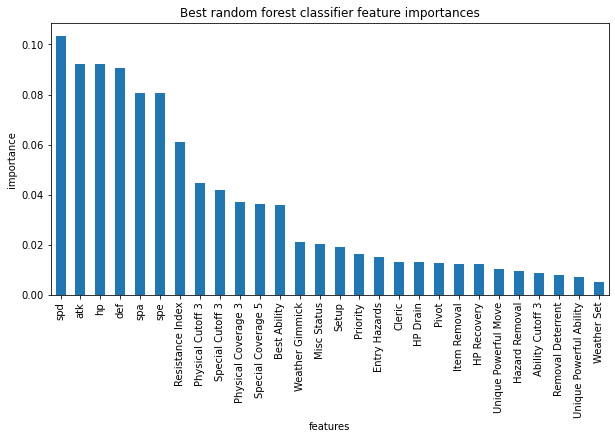

In [248]:
plt.subplots(figsize=(10, 5))
imps = rf_grid.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest classifier feature importances');

We see a nice tiering in the importance of features here:
- the most useful are the stats
- the next set of quite useful features are resistance index, cutoff and coverage move features, and best ability
- then the remaining features are much less useful, with the least useful being Weather Set, Unique Powerful Ability, Removal Deterrent, Ability Cutoff 3, Hazard Removal and Unique Powerful Move, while Weather Gimmick, Misc Status and Setup are still quite useful.

This makes me wonder about an idea of folding in some of these weaker features into some of our better features, like folding weather set into Best Ability or Weather Gimmick to simply enhance them while removing a relatively confusing and pointless extraneous feature. Unique Powerful Ability and Ability Cutoff 3 could arguably just be removed as Best Ability probably just captures the ability information much better. For some of the others, we could think carefully about the best options (e.g. it might be useful to meld HP Recovery and HP Drain)

Now we will try with 4 classes:

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y_df['formats4'],
                        test_size=0.25, random_state=42,
                        stratify=y_df['formats4'].values)

random_forest_classifier = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(random_forest_classifier, param_grid=grid_params, cv=2, n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_grid.best_params_, rf_grid.best_score_

({'n_estimators': 158}, 0.6257063255375922)

In [250]:
y_predrf4_train = rf_grid.predict(X_train)
y_predrf4_test = rf_grid.predict(X_test)
precision_recall_fscore_support(y_train, y_predrf4_train, labels=['Not c', 'Low c', 'Mid c', 'High c']), precision_recall_fscore_support(y_test, y_predrf4_test, labels=['Not c', 'Low c', 'Mid c', 'High c'])

((array([0.98818898, 1.        , 1.        , 1.        ]),
  array([1.        , 0.98319328, 0.99      , 1.        ]),
  array([0.99405941, 0.99152542, 0.99497487, 1.        ]),
  array([251, 119, 100,  83], dtype=int64)),
 (array([0.81521739, 0.44444444, 0.42857143, 0.7       ]),
  array([0.89285714, 0.5       , 0.36363636, 0.5       ]),
  array([0.85227273, 0.47058824, 0.39344262, 0.58333333]),
  array([84, 40, 33, 28], dtype=int64)))

Pretty similar performance to logistic regression, but maybe slightly worse in the 2nd highest class, though we had to train test split the data this time which may be the reason.

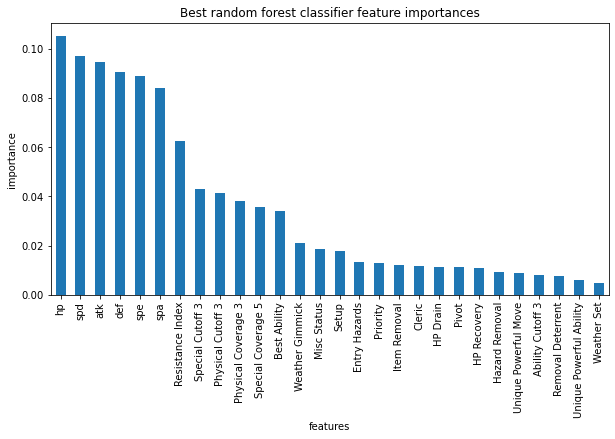

In [251]:
plt.subplots(figsize=(10, 5))
imps = rf_grid.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest classifier feature importances');

This remains nearly identical in overall narrative, and even many of the details.

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y_df['formats2'],
                        test_size=0.25, random_state=42,
                        stratify=y_df['formats2'].values)

random_forest_classifier = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(random_forest_classifier, param_grid=grid_params, cv=2, n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_grid.best_params_, rf_grid.best_score_

({'n_estimators': 398}, 0.8842607126039868)

In [253]:
y_predrf2_train = rf_grid.predict(X_train)
y_predrf2_test = rf_grid.predict(X_test)
precision_recall_fscore_support(y_train, y_predrf2_train, labels=['No', 'Yes']), precision_recall_fscore_support(y_test, y_predrf2_test, labels=['No', 'Yes'])

((array([0.99209486, 1.        ]),
  array([1.        , 0.99337748]),
  array([0.99603175, 0.99667774]),
  array([251, 302], dtype=int64)),
 (array([0.87012987, 0.84259259]),
  array([0.79761905, 0.9009901 ]),
  array([0.83229814, 0.8708134 ]),
  array([ 84, 101], dtype=int64)))

It did pretty well, not quite as well as logistic regression (but again we didn't split into training and test sets), but still very well, so it remains promosing.

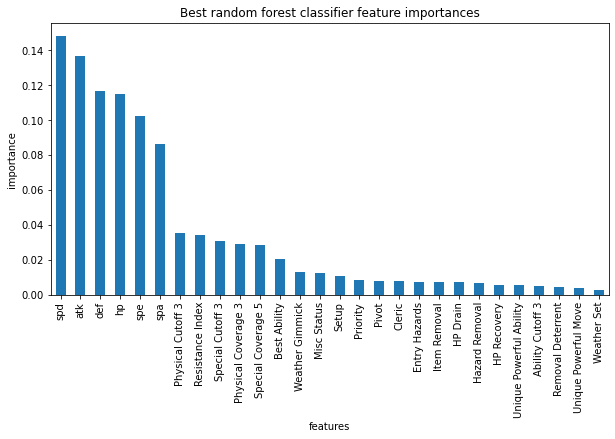

In [254]:
plt.subplots(figsize=(10, 5))
imps = rf_grid.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest classifier feature importances');

It's still very similar to previous forests but even more weighted towards stats (which makes sense, you need certain stats to be in the higher tiers otherwise you will just get mowed down or be too passive to do anything).

This is a sign that we could expect any binary model we make to be heavily weighted towards stats, but then our secondary model which categorizes more finely will use the other features more closely with the stats.

Now let's get into oldformats:

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y_df['oldformats'],
                        test_size=0.25, random_state=42,
                        stratify=y_df['oldformats'].values)
random_forest_classifier = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(random_forest_classifier, param_grid=grid_params, cv=2, n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_grid.best_params_, rf_grid.best_score_

({'n_estimators': 398}, 0.670911159943494)

In [256]:
y_predrfold_train = rf_grid.predict(X_train)
y_predrfold_test = rf_grid.predict(X_test)
precision_recall_fscore_support(y_train, y_predrfold_train, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber']), precision_recall_fscore_support(y_test, y_predrfold_test, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

((array([1., 1., 1., 1., 1., 1., 1.]),
  array([1., 1., 1., 1., 1., 1., 1.]),
  array([1., 1., 1., 1., 1., 1., 1.]),
  array([355,  25,  36,  41,  31,  37,  28], dtype=int64)),
 (array([0.72839506, 0.        , 0.        , 0.        , 0.5       ,
         0.2       , 0.55555556]),
  array([0.99159664, 0.        , 0.        , 0.        , 0.2       ,
         0.08333333, 0.55555556]),
  array([0.83985765, 0.        , 0.        , 0.        , 0.28571429,
         0.11764706, 0.55555556]),
  array([119,   9,  12,  14,  10,  12,   9], dtype=int64)))

In spite of the "better score" oldformats 7 class received than tierchange_df 7 classes did, the oldformats model actually performed notably worse on the precision recall matrix, having many outright 0 f scores. It may only be better on the training set, and thus I may want to question whether Grid Search CV might not always give the best model, it might be giving me overfitted garbage, and I may have to assess things based on a more manual search to try prevent overfitting, or perhaps other metrics and hyperparameters will help with that. But overall, I'd have to say oldformats performs terribly with 7 classes.

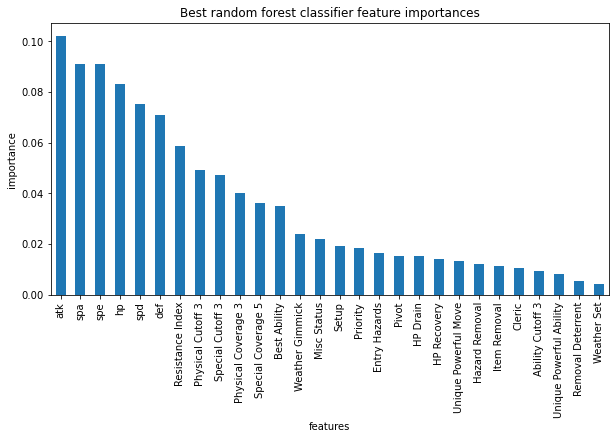

In [257]:
plt.subplots(figsize=(10, 5))
imps = rf_grid.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest classifier feature importances');

No significant difference in feature importances

Let's more onto oldformats 4 classes:

In [258]:
X_train, X_test, y_train, y_test = train_test_split(X, y_df['oldformats4'],
                        test_size=0.25, random_state=42,
                        stratify=y_df['oldformats4'].values)
random_forest_classifier = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(random_forest_classifier, param_grid=grid_params, cv=2, n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_grid.best_params_, rf_grid.best_score_

({'n_estimators': 158}, 0.6944226442735311)

In [259]:
y_predrfold4_train = rf_grid.predict(X_train)
y_predrfold4_test = rf_grid.predict(X_test)
precision_recall_fscore_support(y_train, y_predrfold4_train, labels=['Not c', 'Low c', 'Mid c', 'High c']), precision_recall_fscore_support(y_test, y_predrfold4_test, labels=['Not c', 'Low c', 'Mid c', 'High c'])

((array([1., 1., 1., 1.]),
  array([1., 1., 1., 1.]),
  array([1., 1., 1., 1.]),
  array([355, 103,  67,  28], dtype=int64)),
 (array([0.78666667, 0.375     , 0.63636364, 0.75      ]),
  array([0.99159664, 0.17647059, 0.30434783, 0.66666667]),
  array([0.87732342, 0.24      , 0.41176471, 0.70588235]),
  array([119,  34,  23,   9], dtype=int64)))

Oldformats doesn't have good performance here, due to low c performing poorly and mid c not doing very well either.

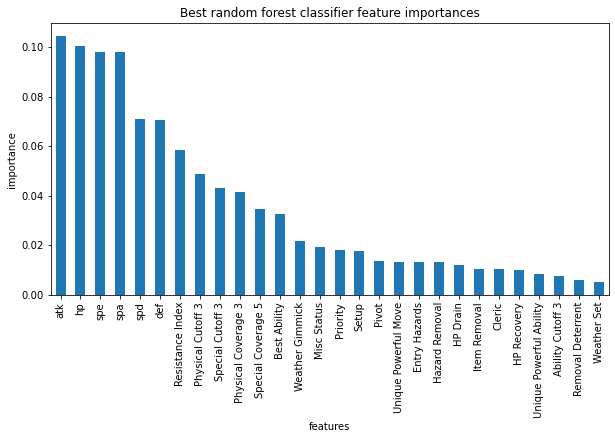

In [260]:
plt.subplots(figsize=(10, 5))
imps = rf_grid.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest classifier feature importances');

Utterly typical

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X, y_df['oldformats2'],
                        test_size=0.25, random_state=42,
                        stratify=y_df['oldformats2'].values)
random_forest_classifier = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(random_forest_classifier, param_grid=grid_params, cv=2, n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_grid.best_params_, rf_grid.best_score_

({'n_estimators': 25}, 0.8390754983519071)

In [262]:
y_predrfold2_train = rf_grid.predict(X_train)
y_predrfold2_test = rf_grid.predict(X_test)
precision_recall_fscore_support(y_train, y_predrfold2_train, labels=['No', 'Yes']), precision_recall_fscore_support(y_test, y_predrfold2_test, labels=['No', 'Yes'])

((array([1., 1.]),
  array([1., 1.]),
  array([1., 1.]),
  array([355, 198], dtype=int64)),
 (array([0.86440678, 0.74626866]),
  array([0.85714286, 0.75757576]),
  array([0.86075949, 0.7518797 ]),
  array([119,  66], dtype=int64)))

Again it does noticeably worse than tierchange formats, so I think we're likely to go with tierchange over oldformats due to the more balanced classes we created.

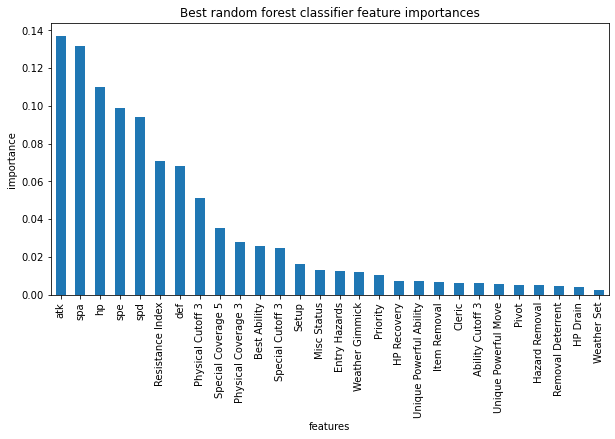

In [263]:
plt.subplots(figsize=(10, 5))
imps = rf_grid.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest classifier feature importances');

Typical and predictably weighted towards stats, though it's interesting that attacking stats are more important and defense is even lower than resistance index.

<a id="hierarchical_clustering"></a>
### Hierarchical Clustering

**Now, we are moving onto clustering.**  We want to try three kinds of clustering:
- Hierarchical
- KMeans
- Density based
- Meanshift

First of all, we can get a nice visualization of our hierarchical clustering via a dendrogram! We need to scale our data first, since we are using distance measures and there isn't a reason that features with larger or smaller distance scales should a priori be more important:

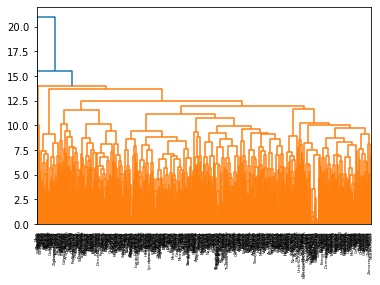

In [264]:
X_scaled = StandardScaler().fit_transform(X)
mergings = linkage(X_scaled, method='complete')
dendrogram(mergings,
           labels=X.index,
           leaf_rotation=90,
           leaf_font_size=4)
plt.show()

While beautiful and interesting, this dendrogram is far too busy to be of much use. Let's look more closely at the results of different cluster distance cutoff points:

In [265]:
labels = fcluster(mergings, 10, criterion='distance')
pairs = pd.DataFrame({'labels': labels, 'pokemon': X.index})
pairs['labels'].value_counts()

10    181
8     152
14    109
7      61
3      43
13     42
5      37
6      36
11     29
9      22
12     10
4       8
2       4
1       2
16      1
15      1
Name: labels, dtype: int64

In [266]:
labels = fcluster(mergings, 9, criterion='distance')
pairs = pd.DataFrame({'labels': labels, 'pokemon': X.index})
pairs['labels'].value_counts()

12    121
24     80
16     55
23     42
20     40
9      38
8      36
11     31
21     29
7      29
15     26
18     25
10     23
4      23
19     20
3      20
14     19
25     19
17     15
26     10
22     10
6       8
5       8
2       4
13      3
1       2
28      1
27      1
Name: labels, dtype: int64

A distance of 10 shows a good amount of clusters (16), not too many and not too few, but a lot of the clusters are really large so I wonder how much those can really mean. 9 still has a possibly tolerable amount at 28, but it's tending towards a lot so I don't think going down to 8 is a good idea.

Let's examine the clusters for a distance of 10 by examining the outliers, a few small and medium sized clusters, and a large cluster (and merge with the 'formats' feature so that we can see the target variable in each clustering):

In [267]:
labels = fcluster(mergings, 10, criterion='distance')
pairs = pd.DataFrame({'labels': labels, 'pokemon': X.index})
pairs['labels'].value_counts()

10    181
8     152
14    109
7      61
3      43
13     42
5      37
6      36
11     29
9      22
12     10
4       8
2       4
1       2
16      1
15      1
Name: labels, dtype: int64

In [268]:
pairs[pairs['labels'] == 15].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True)

labels  pokemon formats
151      15  Shuckle      PU

In [269]:
pairs[pairs['labels'] == 16].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True)

labels pokemon formats
116      16     Mew    Uber

So our uniques are Mew and Shuckle, who both have very unique features. Shuckle has extremely high defense and special defense, and very low values for all of its other stats. Mew is the only pokemon that can learn ANY move in all of pokemon which is available to be learned (i.e. it doesn't include unique moves the level up sets of many pokemon, but it is BY FAR the largest learnset of any pokemon).

In [270]:
pairs[pairs['labels'] == 1].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True)

labels  pokemon formats
78        1  Chansey      UU
166       1  Blissey    Uber

Chansey and Blissey uniquely have by far the highest HP of all pokemon, and it's the reason that they are used as special walls due to the fact that they also have high special defense and a type (normal) that has few weaknesses (however their HP is really what stands out about them that the clustering is surely detecting).

In [271]:
pairs[pairs['labels'] == 2].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True)

labels    pokemon formats
147       2  Wobbuffet      ZU
225       2    Wailmer      ZU
226       2    Wailord      ZU
613       2   Guzzlord      NU

These are the other very high hp pokemon, just of a notably lower hp than Blissey and Chansey. Probably they are in different clusters because HP is the stats with the highest variance of all the stats in pokemon, so the other stats won't be able to split into as many small unique clusters like this. It also stands out that these pokemon aren't as competitive as Blissey and Chansey who both have quite high tiers, so that's probably another reason for the split (Blissey and Chansey are also more powerful). That said, I'm not sure it's ideal to split these high hp pokemon, so we'll see if they glom together in other forms of clustering.

In [272]:
pairs[pairs['labels'] == 4].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True)

labels      pokemon formats
472       4   Fletchling      ZU
473       4  Fletchinder      ZU
474       4   Talonflame      RU
553       4      Mudbray      ZU
554       4     Mudsdale      NU
709       4  Stonjourner      PU
731       4    Regieleki    Uber
732       4    Regidrago      RU

This one is harder to see the common thread in. There are fast and lightweight pokemon like Talonflame and Regieleki, and heavy bulky pokemon like Mudsdale, Stonjourner and Regidrago, all with quite different types and seemingly movesets as well, not to mention a large spread in terms of formats (although all of them are competitive, at least if they are a final evolution in their family). It's hard to see much common thread though, so I don't think this cluster is very good.

Let's start skipping by twos, since we don't need to look at every cluster, as we will ultimately take the clustering method and distance as hyperparamters in tuning our model.

In [273]:
pairs[pairs['labels'] == 9].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True)

labels         pokemon formats
26        9      Jigglypuff      ZU
27        9      Wigglytuff      PU
58        9      Farfetch'd      ZU
117       9       Igglybuff      ZU
173       9         Milotic      UU
338       9         Gothita      ZU
339       9       Gothorita      ZU
340       9      Gothitelle      PU
434       9        Braviary      NU
445       9        Tornadus      UU
447       9       Thundurus      UU
478       9      Meowstic-F      PU
485       9           Inkay      ZU
486       9         Malamar      ZU
557       9        Fomantis      ZU
558       9        Lurantis      PU
570       9       Passimian      NU
634       9  Articuno-Galar      NU
635       9    Zapdos-Galar      OU
671       9         Boltund      PU
697       9       Obstagoon      UU
705       9         Falinks      PU

The common thread here is the ability "competitive" or something very similar to it (e.g. defiant), which must mean this ability is quite unique and important (in fact it is, it's hazard removal deterrent).

In [274]:
pairs[pairs['labels'] == 6].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True)

labels         pokemon formats
56        6       Magnemite      ZU
57        6        Magneton      PU
188       6          Mawile      ZU
190       6         Duskull      ZU
191       6        Dusclops      ZU
213       6        Shedinja      ZU
216       6         Sableye      PU
267       6        Dusknoir      PU
269       6       Magnezone      OU
293       6       Spiritomb      PU
317       6        Froslass      PU
341       6      Ferrothorn    Uber
343       6         Litwick      ZU
344       6         Lampent      ZU
345       6      Chandelure      UU
391       6          Yamask      ZU
392       6      Cofagrigus      PU
408       6      Escavalier      NU
415       6       Ferroseed      PU
431       6        Pawniard      PU
432       6         Bisharp      OU
460       6       Aegislash      OU
479       6         Honedge      ZU
480       6        Doublade      RU
505       6          Klefki      UU
506       6        Phantump      ZU
507       6       Trevenant      PU
573       6       Sandygast      ZU
574       6       Palossand      PU
597       6         Mimikyu      RU
643       6    Yamask-Galar      ZU
644       6  Stunfisk-Galar      PU
689       6        Sinistea      ZU
694       6        Impidimp      ZU
695       6         Morgrem      ZU
702       6       Runerigus      PU

These are pokemon who often have types like ghost or steel that have a lot of immunities and resistances, so they likely have a high resistance index.

In [275]:
pairs[pairs['labels'] == 13].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True)

labels              pokemon formats
114      13            Dragonite      OU
115      13               Mewtwo    Uber
170      13                Lugia    Uber
171      13                Ho-Oh    Uber
249      13            Salamence      UU
254      13               Latios      OU
257      13             Rayquaza    Uber
273      13              Heatran    Uber
322      13               Dialga    Uber
323      13               Palkia    Uber
325      13             Giratina    Uber
326      13      Giratina-Origin    Uber
441      13            Hydreigon      OU
449      13             Reshiram    Uber
450      13               Zekrom    Uber
453      13               Kyurem      OU
454      13         Kyurem-Black    Uber
455      13         Kyurem-White    Uber
515      13            Volcanion      UU
533      13        Marowak-Alola      RU
577      13             Silvally      ZU
578      13         Silvally-Bug      PU
579      13        Silvally-Dark      ZU
580      13      Silvally-Dragon      PU
581      13    Silvally-Electric      ZU
582      13       Silvally-Fairy      PU
583      13    Silvally-Fighting      ZU
584      13        Silvally-Fire      ZU
585      13      Silvally-Flying      ZU
586      13       Silvally-Ghost      NU
587      13       Silvally-Grass      ZU
588      13      Silvally-Ground      NU
589      13         Silvally-Ice      PU
590      13      Silvally-Poison      PU
591      13     Silvally-Psychic      ZU
592      13        Silvally-Rock      PU
593      13       Silvally-Steel      NU
594      13       Silvally-Water      ZU
598      13               Drampa      PU
606      13               Lunala    Uber
615      13   Necrozma-Dusk Mane    Uber
616      13  Necrozma-Dawn Wings    Uber

This is a lot of very powerful legendary or quasi-legendary pokemon, though Silvally seems like the weak link here, and there are a few non-legendaries like Marowak-Alola.

In [276]:
pairs[pairs['labels'] == 10].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True).head(50)

labels    pokemon formats
0        10  Bulbasaur      ZU
1        10    Ivysaur      ZU
2        10   Venusaur      OU
22       10   Clefairy      PU
23       10   Clefable    Uber
30       10     Oddish      ZU
31       10      Gloom      ZU
32       10  Vileplume      RU
37       10    Psyduck      ZU
38       10    Golduck      PU
41       10    Poliwag      ZU
42       10  Poliwhirl      ZU
44       10       Abra      ZU
45       10    Kadabra      PU
46       10   Alakazam      OU
54       10   Slowpoke      ZU
55       10    Slowbro      OU
61       10     Gastly      ZU
62       10    Haunter      PU
63       10     Gengar      OU
67       10  Exeggcute      ZU
68       10  Exeggutor      ZU
73       10  Lickitung      ZU
74       10    Koffing      ZU
75       10    Weezing      NU
79       10    Tangela      PU
87       10   Mr. Mime      PU
89       10       Jynx      PU
98       10      Eevee      ZU
99       10   Vaporeon      NU
100      10    Jolteon      PU
101      10    Flareon      PU
102      10    Porygon      ZU
109      10   Articuno      ZU
110      10     Zapdos      OU
111      10    Moltres      OU
112      10    Dratini      ZU
113      10  Dragonair      ZU
118      10     Togepi      ZU
119      10    Togetic      PU
120      10     Cleffa      ZU
121      10  Bellossom      PU
123      10  Azumarill      OU
126      10    Noctowl      ZU
128      10    Corsola      ZU
129      10    Mantine      UU
130      10     Raikou      UU
133      10   Hoothoot      ZU
134      10     Crobat      RU
135      10   Chinchou      ZU

This is just the first 50 from the largest indiscrimiate cluster, and this one indeed doesn't seem that informative, with great variety of types, stats, competitive viability, etc. But the fact that hierarchical clustering definitely detected some very sensible and reasonable clusters is promising, and even if only some of the clusters are reasonable in my final model, it may still increase how discerning the model is about unusual cases (since they'll belong to a cluster that will cause them to be treated differently, instead of a bigger standardized cluster like this).

That was all a clustering based on all of the features that have a chance of making it into my final model. It might be interesting to cluster by focusing on just part of the data, such as:
- stats
- abilities
- learnset
- (type information is already contained in merely one feature so there is no need to find clusters in one feature)

We will start with the stats. The values I found most useful during EDA_experiments_2 were between 5 and 3.5. 3.75 probably did the best job of breaking down the largest clusters with the highest value possible, but there were still arguably too many clusters with this value (34 total). We'll try a value of 5 (since it has the lowest number of clusters, 16, of the good values) to get an idea of what it will cluster together, but our ultimate value of choice will be a tunable hyperparameter.

In [277]:
X_scaled = StandardScaler().fit_transform(pokemon_df.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])
mergings = linkage(X_scaled, method='complete')
labels = fcluster(mergings, 5, criterion='distance')
pairs = pd.DataFrame({'labels': labels, 'pokemon': pokemon_df.index})
pairs['labels'].value_counts()

14    188
5     118
12     90
7      84
13     68
8      40
15     39
9      27
3      20
11     19
4      16
10     16
2       9
1       2
16      1
6       1
Name: labels, dtype: int64

In [278]:
pairs[pairs['labels'] == 6].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True)

labels  pokemon formats
612       6  Kartana      OU

In [279]:
pairs[pairs['labels'] == 16].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True)

labels  pokemon formats
151      16  Shuckle      PU

Shuckle was already unique in terms of stats, but now Kartana is seem as having very unique stats, and I agree because Kartana has grotesquely high physical stats and very low special stats and hp. It makes sense that Mew was displaced here since its learnset was so unique, not its stats.

In [280]:
pairs[pairs['labels'] == 1].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True)

labels  pokemon formats
78        1  Chansey      UU
166       1  Blissey    Uber

Chansey and Blissey, still taking on the role of the super high hp pokemon who are also powerfully competitive

In [281]:
pairs[pairs['labels'] == 2].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True)

labels     pokemon formats
27        2  Wigglytuff      PU
108       2     Snorlax      RU
147       2   Wobbuffet      ZU
225       2     Wailmer      ZU
226       2     Wailord      ZU
284       2    Drifblim      PU
297       2    Munchlax      ZU
613       2    Guzzlord      NU
732       2   Regidrago      RU

These are more high hp pokemon, but this time it's more inclusive since we specifically focused on stats, so that's even more useful

Let's start skipping by 2, since we don't need to dwell on every cluster, it just needs to be reasonable overall

In [282]:
pairs[pairs['labels'] == 4].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True)

labels      pokemon formats
77        4       Rhydon      PU
246       4    Relicanth      PU
301       4    Hippowdon      OU
311       4    Rhyperior      UU
330       4     Gigalith      NU
374       4   Conkeldurr      OU
377       4        Throh      PU
408       4   Escavalier      NU
554       4     Mudsdale      NU
572       4    Golisopod      RU
608       4     Buzzwole    Uber
625       4     Melmetal      OU
655       4     Greedent      ZU
715       4   Copperajah      NU
733       4    Glastrier      NU
736       4  Calyrex-Ice    Uber

These are quite physically oriented (attack and defense) and also quite bulky (high hp and/or at least one of the defenses) pokemon, attack is usually higher than defense though

In [283]:
pairs[pairs['labels'] == 3].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True)

labels          pokemon formats
15        3        Sandslash      PU
60        3         Cloyster      RU
64        3             Onix      ZU
140       3        Sudowoodo      ZU
149       3          Steelix      RU
159       3         Skarmory    Uber
192       3         Regirock      PU
218       3           Lairon      ZU
219       3           Aggron      PU
350       3          Boldore      ZU
352       3          Crustle      PU
464       3  Gourgeist-Large      ZU
467       3          Avalugg      PU
480       3         Doublade      RU
488       3       Barbaracle      RU
511       3  Gourgeist-Super      PU
525       3  Sandslash-Alola      PU
621       3        Stakataka      RU
679       3       Sandaconda      PU
709       3      Stonjourner      PU

These are also physically oriented pokemon but slanted notably more towards defense than attack, so like a mirror of the last one

In [284]:
pairs[pairs['labels'] == 15].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True)

labels          pokemon formats
12       15          Pikachu      PU
26       15       Jigglypuff      ZU
33       15          Diglett      ZU
35       15           Meowth      ZU
41       15          Poliwag      ZU
50       15        Tentacool      ZU
94       15         Magikarp      ZU
117      15        Igglybuff      ZU
122      15           Marill      ZU
137      15            Pichu      ZU
189      15           Feebas      ZU
190      15          Duskull      ZU
195      15          Wingull      ZU
203      15        Zigzagoon      ZU
240      15           Wynaut      ZU
250      15           Beldum      ZU
265      15         Mime Jr.      ZU
278      15           Combee      ZU
289      15          Bronzor      ZU
292      15          Happiny      ZU
302      15          Skorupi      ZU
306      15          Mantyke      ZU
332      15         Venipede      ZU
333      15       Whirlipede      ZU
335      15         Cottonee      ZU
342      15            Klink      ZU
391      15           Yamask      ZU
415      15        Ferroseed      PU
423      15          Shelmet      ZU
470      15         Bunnelby      ZU
528      15    Diglett-Alola      ZU
530      15     Meowth-Alola      ZU
546      15         Cutiefly      ZU
571      15           Wimpod      ZU
639      15  Zigzagoon-Galar      ZU
643      15     Yamask-Galar      ZU
659      15          Blipbug      ZU
675      15           Applin      ZU
721      15           Dreepy      ZU

Weak baby pokemon, almost entirely uncompetitive

In [285]:
pairs[pairs['labels'] == 14].merge(pokemon_data['formats'], how='inner', left_on='pokemon', right_index=True).head(50)

labels     pokemon formats
0        14   Bulbasaur      ZU
3        14  Charmander      ZU
6        14    Squirtle      ZU
9        14    Caterpie      ZU
10       14     Metapod      ZU
14       14   Sandshrew      ZU
16       14   Nidoran-F      ZU
17       14    Nidorina      ZU
19       14   Nidoran-M      ZU
20       14    Nidorino      ZU
22       14    Clefairy      PU
24       14      Vulpix      ZU
28       14       Zubat      ZU
30       14      Oddish      ZU
37       14     Psyduck      ZU
39       14   Growlithe      ZU
47       14      Machop      ZU
54       14    Slowpoke      ZU
58       14  Farfetch'd      ZU
59       14    Shellder      ZU
65       14      Krabby      ZU
67       14   Exeggcute      ZU
69       14      Cubone      ZU
74       14     Koffing      ZU
76       14     Rhyhorn      ZU
83       14     Goldeen      ZU
85       14      Staryu      ZU
97       14       Ditto      ZU
98       14       Eevee      ZU
105      14      Kabuto      ZU
112      14     Dratini      ZU
118      14      Togepi      ZU
120      14      Cleffa      ZU
124      14     Tyrogue      ZU
133      14    Hoothoot      ZU
135      14    Chinchou      ZU
138      14        Natu      ZU
142      14      Wooper      ZU
154      14      Swinub      ZU
156      14    Remoraid      ZU
158      14    Delibird      ZU
163      14      Elekid      ZU
164      14       Magby      ZU
167      14    Larvitar      ZU
174      14     Treecko      ZU
177      14     Torchic      ZU
180      14      Mudkip      ZU
183      14       Ralts      ZU
184      14      Kirlia      ZU
187      14     Azurill      ZU

Also weak baby pokemon in the largest cluster (of which the above only shows the first 50).

Overall, I'd say that the clustering of stats performed more consistently and coherently than clustering based on all of the features of the pokemon, so I like it a lot.

Now let's try clustering by abilities:

In [286]:
X_scaled = StandardScaler().fit_transform(pokemon_abilities_df)
mergings = linkage(X_scaled, method='complete')
labels = fcluster(mergings, 10, criterion='distance')
pairs = pd.DataFrame({'labels': labels, 'pokemon': pokemon_df.index})
pairs['labels'].value_counts()

250    48
247    12
248    11
225    10
199     9
       ..
282     1
67      1
52      1
86      1
316     1
Name: labels, Length: 330, dtype: int64

330 clusters for 738 rows is absurdly unrealistic.  Let's try a larger distance.

In [287]:
X_scaled = StandardScaler().fit_transform(pokemon_abilities_df)
mergings = linkage(X_scaled, method='complete')
labels = fcluster(mergings, 30, criterion='distance')
pairs = pd.DataFrame({'labels': labels, 'pokemon': pokemon_df.index})
pairs['labels'].value_counts()

22    656
15      5
21      5
18      4
14      3
20      2
16      2
12      2
17      2
11      2
2       2
3       2
13      2
19      2
10      2
1       2
8       1
24      1
9       1
38      1
50      1
57      1
5       1
40      1
56      1
46      1
36      1
34      1
30      1
41      1
42      1
43      1
44      1
29      1
55      1
33      1
53      1
47      1
54      1
23      1
6       1
25      1
26      1
31      1
58      1
52      1
27      1
49      1
7       1
32      1
28      1
37      1
4       1
39      1
35      1
59      1
48      1
51      1
45      1
Name: labels, dtype: int64

59 clusters is still probably too many to be useful, especially when almost all of the pokemon are contained in one clusters and almost all the rest are unique. So ultimately, abilities is too sparse to be useful for clustering. We can try it for learnsets but I don't have high hopes:

In [288]:
X_scaled = StandardScaler().fit_transform(pokemon_learnsets_df)
mergings = linkage(X_scaled, method='complete')
labels = fcluster(mergings, 10, criterion='distance')
pairs = pd.DataFrame({'labels': labels, 'pokemon': pokemon_df.index})
pairs['labels'].value_counts()

407    18
425     8
147     6
423     3
144     3
       ..
94      1
326     1
142     1
19      1
55      1
Name: labels, Length: 571, dtype: int64

571 clusters for 738 is EVEN more absurdly unrealistic!

In [289]:
X_scaled = StandardScaler().fit_transform(pokemon_learnsets_df)
mergings = linkage(X_scaled, method='complete')
labels = fcluster(mergings, 50, criterion='distance')
pairs = pd.DataFrame({'labels': labels, 'pokemon': pokemon_df.index})
pairs['labels'].value_counts()

16    522
13     75
6      50
15     13
23     12
20      6
27      5
22      4
1       4
21      4
7       3
18      3
17      3
12      3
5       3
26      3
2       2
10      2
9       2
11      2
35      1
32      1
25      1
28      1
24      1
34      1
4       1
31      1
29      1
33      1
37      1
3       1
19      1
8       1
14      1
30      1
36      1
Name: labels, dtype: int64

Even at a distance of 50, we still have the vast majority of pokemon in one cluster, and 37 clusters is still a rather large amount. This isn't as bad as abilities, which makes sense since pokemon share a lot more moves than abilities even though there are a lot more moves, but overall I can't see this being helpful, especially with most clusters being uniques or containing very few examples.

<a id="k_means"></a>
### k-means clustering

For our best clustering values in hierarchical clustering, we had somewhere between 15 and 30 clusters, so that's probably what we should aim for with kmeans since we need to specify it (and of course we will test that number as a hyperparameter)

In [290]:
kmeans = KMeans(n_clusters=20, random_state=42)
clusts = kmeans.fit_predict(X)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

2     68
4     62
6     51
18    48
17    45
0     45
16    42
8     39
15    38
3     37
19    36
1     36
10    35
14    33
11    32
9     24
5     23
12    18
7     15
13    11
Name: labels, dtype: int64

These numbers look surprisingly balanced and reasonable. There aren't even any major outliers and the size increases very smoothly. We can look at a few smaller clusters, a few medium and a large one.

In [291]:
pairs[pairs['labels'] == 13]

labels     pokemon formats
name                                  
Wigglytuff      13  Wigglytuff      PU
Chansey         13     Chansey      UU
Snorlax         13     Snorlax      RU
Wobbuffet       13   Wobbuffet      ZU
Blissey         13     Blissey    Uber
Wailmer         13     Wailmer      ZU
Wailord         13     Wailord      ZU
Drifblim        13    Drifblim      PU
Munchlax        13    Munchlax      ZU
Guzzlord        13    Guzzlord      NU
Regidrago       13   Regidrago      RU

Now it looks like we have most of the high hp pokemon bunched together, INCLUDING Chansey and Blissey! This is promising.

In [292]:
pairs[pairs['labels'] == 12]

labels      pokemon formats
name                                    
Cloyster         12     Cloyster      RU
Rhydon           12       Rhydon      PU
Steelix          12      Steelix      RU
Regirock         12     Regirock      PU
Torkoal          12      Torkoal      ZU
Lairon           12       Lairon      ZU
Aggron           12       Aggron      PU
Relicanth        12    Relicanth      PU
Rhyperior        12    Rhyperior      UU
Gigalith         12     Gigalith      NU
Carracosta       12   Carracosta      PU
Avalugg          12      Avalugg      PU
Doublade         12     Doublade      RU
Buzzwole         12     Buzzwole    Uber
Stakataka        12    Stakataka      RU
Melmetal         12     Melmetal      OU
Stonjourner      12  Stonjourner      PU
Glastrier        12    Glastrier      NU

Very high defense pokemon with rock, steel and ice typings

In [293]:
pairs[pairs['labels'] == 10]

labels         pokemon formats
name                                          
Ivysaur             10         Ivysaur      ZU
Charmeleon          10      Charmeleon      ZU
Charizard           10       Charizard      PU
Raichu              10          Raichu      PU
Nidoking            10        Nidoking      OU
Golbat              10          Golbat      ZU
Dugtrio             10         Dugtrio      PU
Persian             10         Persian      PU
Golduck             10         Golduck      PU
Poliwhirl           10       Poliwhirl      ZU
Tentacruel          10      Tentacruel      UU
Ponyta              10          Ponyta      ZU
Rapidash            10        Rapidash      PU
Seadra              10          Seadra      ZU
Electabuzz          10      Electabuzz      ZU
Magmar              10          Magmar      ZU
Noctowl             10         Noctowl      ZU
Crobat              10          Crobat      RU
Shiftry             10         Shiftry      ZU
Manectric           10       Manectric      PU
Froslass            10        Froslass      PU
Vanillish           10       Vanillish      ZU
Swoobat             10         Swoobat      PU
Lilligant           10       Lilligant      PU
Emolga              10          Emolga      ZU
Noivern             10         Noivern      UU
Talonflame          10      Talonflame      RU
Persian-Alola       10   Persian-Alola      PU
Torracat            10        Torracat      ZU
Ribombee            10        Ribombee      PU
Salazzle            10        Salazzle      RU
Mr. Mime-Galar      10  Mr. Mime-Galar      PU
Drizzile            10        Drizzile      ZU
Toxtricity          10      Toxtricity      UU
Drakloak            10        Drakloak      ZU

This is a stranger cluster and hard to see the coherence of, but it contains a lot of middle evolutions or second evolutions with semi-balanced stats, but there are a few exceptions like Talonflame, Crobat, Shiftry, Poliwhirl etc. (the former two of whom are surprisingly fast)

In [294]:
pairs[pairs['labels'] == 8]

labels               pokemon formats
name                                                      
Hitmonlee                  8             Hitmonlee      PU
Kangaskhan                 8            Kangaskhan      PU
Scyther                    8               Scyther      PU
Pinsir                     8                Pinsir      PU
Tauros                     8                Tauros      RU
Gyarados                   8              Gyarados      UU
Aerodactyl                 8            Aerodactyl      RU
Qwilfish                   8              Qwilfish      PU
Heracross                  8             Heracross      RU
Miltank                    8               Miltank      PU
Absol                      8                 Absol      PU
Gallade                    8               Gallade      PU
Garchomp                   8              Garchomp      OU
Weavile                    8               Weavile      OU
Stoutland                  8             Stoutland      PU
Unfezant                   8              Unfezant      PU
Scolipede                  8             Scolipede      UU
Krookodile                 8            Krookodile      UU
Excadrill                  8             Excadrill    Uber
Sawk                       8                  Sawk      PU
Darmanitan                 8            Darmanitan      RU
Fraxure                    8               Fraxure      PU
Haxorus                    8               Haxorus      UU
Bisharp                    8               Bisharp      OU
Braviary                   8              Braviary      NU
Durant                     8                Durant      RU
Terrakion                  8             Terrakion      OU
Lycanroc                   8              Lycanroc      PU
Lycanroc-Midnight          8     Lycanroc-Midnight      PU
Lycanroc-Dusk              8         Lycanroc-Dusk      UU
Passimian                  8             Passimian      NU
Togedemaru                 8            Togedemaru      PU
Kartana                    8               Kartana      OU
Darmanitan-Galar           8      Darmanitan-Galar    Uber
Rillaboom                  8             Rillaboom      OU
Drednaw                    8               Drednaw      PU
Barraskewda                8           Barraskewda      RU
Urshifu                    8               Urshifu    Uber
Urshifu-Rapid-Strike       8  Urshifu-Rapid-Strike      OU

These are a lot of faster physical attackers

In [295]:
pairs[pairs['labels'] == 6]

labels          pokemon formats
name                                            
Caterpie              6         Caterpie      ZU
Nidoran-F             6        Nidoran-F      ZU
Nidorina              6         Nidorina      ZU
Nidoran-M             6        Nidoran-M      ZU
Nidorino              6         Nidorino      ZU
Zubat                 6            Zubat      ZU
Ditto                 6            Ditto      ZU
Hoothoot              6         Hoothoot      ZU
Wooper                6           Wooper      ZU
Wingull               6          Wingull      ZU
Zigzagoon             6        Zigzagoon      ZU
Shedinja              6         Shedinja      ZU
Whismur               6          Whismur      ZU
Barboach              6         Barboach      ZU
Snorunt               6          Snorunt      ZU
Bagon                 6            Bagon      ZU
Combee                6           Combee      ZU
Vanillite             6        Vanillite      ZU
Lillipup              6         Lillipup      ZU
Munna                 6            Munna      ZU
Darumaka              6         Darumaka      ZU
Yamask                6           Yamask      ZU
Zorua                 6            Zorua      ZU
Vullaby               6          Vullaby      ZU
Deino                 6            Deino      ZU
Fletchling            6       Fletchling      ZU
Inkay                 6            Inkay      ZU
Clauncher             6        Clauncher      ZU
Rowlet                6           Rowlet      ZU
Grubbin               6          Grubbin      ZU
Rockruff              6         Rockruff      ZU
Wishiwashi            6       Wishiwashi      PU
Mudbray               6          Mudbray      ZU
Fomantis              6         Fomantis      ZU
Bounsweet             6        Bounsweet      ZU
Steenee               6          Steenee      ZU
Wimpod                6           Wimpod      ZU
Sandygast             6        Sandygast      ZU
Jangmo-o              6         Jangmo-o      ZU
Cosmog                6           Cosmog      ZU
Zigzagoon-Galar       6  Zigzagoon-Galar      ZU
Darumaka-Galar        6   Darumaka-Galar      ZU
Yamask-Galar          6     Yamask-Galar      ZU
Scorbunny             6        Scorbunny      ZU
Skwovet               6          Skwovet      ZU
Rookidee              6         Rookidee      ZU
Corvisquire           6      Corvisquire      ZU
Yamper                6           Yamper      ZU
Toxel                 6            Toxel      ZU
Snom                  6             Snom      ZU
Cufant                6           Cufant      ZU

A set of uncompetitive baby pokemon.

So overall, this clustering is pretty good. Its results are comparable to hierarchical clustering, but I greatly prefer the relative sizes of the clusters, so k means will probably end up being the preferred option. This may make sense since it is a more artificial clustering method, and we didn't have good natural clusters in the data as we saw with our PCA visualization, so forcing more artificial clusters may be more suited to our data.

Now let's try the same thing for just the stats:

In [296]:
kmeans = KMeans(n_clusters=20, random_state=42)
clusts = kmeans.fit_predict(pokemon_df.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

16    74
8     64
15    54
0     53
10    49
7     48
3     45
14    44
12    44
13    39
6     36
9     34
2     33
4     31
5     29
1     24
19    14
17    11
11    10
18     2
Name: labels, dtype: int64

Still very good numbers overall, with just one notable outlier:

In [297]:
pairs[pairs['labels'] == 18]

labels  pokemon formats
name                            
Chansey      18  Chansey      UU
Blissey      18  Blissey    Uber

Of course, Chansey and Blissey are unique in having a very high hp cluster again

In [298]:
pairs[pairs['labels'] == 17]

labels    pokemon formats
name                                
Cloyster       17   Cloyster      RU
Onix           17       Onix      ZU
Steelix        17    Steelix      RU
Regirock       17   Regirock      PU
Torkoal        17    Torkoal      ZU
Lairon         17     Lairon      ZU
Aggron         17     Aggron      PU
Avalugg        17    Avalugg      PU
Doublade       17   Doublade      RU
Stakataka      17  Stakataka      RU
Runerigus      17  Runerigus      PU

We have our very high defense pokemon in this cluster, it seems

In [299]:
pairs[pairs['labels'] == 1]

labels               pokemon formats
name                                                      
Sandslash                  1             Sandslash      PU
Kingler                    1               Kingler      NU
Pinsir                     1                Pinsir      PU
Kabutops                   1              Kabutops      ZU
Scizor                     1                Scizor      OU
Leafeon                    1               Leafeon      PU
Mamoswine                  1             Mamoswine      OU
Haxorus                    1               Haxorus      UU
Bisharp                    1               Bisharp      OU
Durant                     1                Durant      RU
Tyrantrum                  1             Tyrantrum      RU
Tapu Bulu                  1             Tapu Bulu      OU
Sandslash-Alola            1       Sandslash-Alola      PU
Passimian                  1             Passimian      NU
Buzzwole                   1              Buzzwole    Uber
Kartana                    1               Kartana      OU
Rillaboom                  1             Rillaboom      OU
Drednaw                    1               Drednaw      PU
Sandaconda                 1            Sandaconda      PU
Sirfetch'd                 1            Sirfetch'd      NU
Falinks                    1               Falinks      PU
Stonjourner                1           Stonjourner      PU
Urshifu                    1               Urshifu    Uber
Urshifu-Rapid-Strike       1  Urshifu-Rapid-Strike      OU

These are very physically oriented pokemon, but with middling to higher speed

In [300]:
pairs[pairs['labels'] == 9]

labels          pokemon formats
name                                            
Machamp               9          Machamp      NU
Rhydon                9           Rhydon      PU
Sudowoodo             9        Sudowoodo      ZU
Piloswine             9        Piloswine      ZU
Armaldo               9          Armaldo      PU
Relicanth             9        Relicanth      PU
Hippowdon             9        Hippowdon      OU
Rhyperior             9        Rhyperior      UU
Gigalith              9         Gigalith      NU
Boldore               9          Boldore      ZU
Crustle               9          Crustle      PU
Beartic               9          Beartic      ZU
Gurdurr               9          Gurdurr      ZU
Conkeldurr            9       Conkeldurr      OU
Throh                 9            Throh      PU
Carracosta            9       Carracosta      PU
Escavalier            9       Escavalier      NU
Druddigon             9        Druddigon      PU
Golurk                9           Golurk      RU
Bouffalant            9       Bouffalant      PU
Pangoro               9          Pangoro      RU
Gourgeist-Super       9  Gourgeist-Super      PU
Mudsdale              9         Mudsdale      NU
Bewear                9           Bewear      RU
Golisopod             9        Golisopod      RU
Dhelmise              9         Dhelmise      RU
Melmetal              9         Melmetal      OU
Stunfisk-Galar        9   Stunfisk-Galar      PU
Greedent              9         Greedent      ZU
Coalossal             9        Coalossal      ZU
Grapploct             9        Grapploct      PU
Perrserker            9       Perrserker      PU
Copperajah            9       Copperajah      NU
Glastrier             9        Glastrier      NU

Also quite physical oriented pokemon, but who have lower speed (reflected in seemingly lower average rating in the target variable as compared to the higher speed physical cluster we looked at)

In [301]:
pairs[pairs['labels'] == 15]

labels            pokemon formats
name                                                
Golbat                 15             Golbat      ZU
Dugtrio                15            Dugtrio      PU
Ponyta                 15             Ponyta      ZU
Rapidash               15           Rapidash      PU
Hitmonlee              15          Hitmonlee      PU
Kangaskhan             15         Kangaskhan      PU
Scyther                15            Scyther      PU
Tauros                 15             Tauros      RU
Gyarados               15           Gyarados      UU
Aerodactyl             15         Aerodactyl      RU
Qwilfish               15           Qwilfish      PU
Crobat                 15             Crobat      RU
Heracross              15          Heracross      RU
Sneasel                15            Sneasel      PU
Flygon                 15             Flygon      RU
Linoone                15            Linoone      RU
Ninjask                15            Ninjask      RU
Sharpedo               15           Sharpedo      RU
Absol                  15              Absol      PU
Gallade                15            Gallade      PU
Skuntank               15           Skuntank      PU
Gabite                 15             Gabite      ZU
Toxicroak              15          Toxicroak      NU
Weavile                15            Weavile      OU
Unfezant               15           Unfezant      PU
Scolipede              15          Scolipede      UU
Krookodile             15         Krookodile      UU
Excadrill              15          Excadrill    Uber
Sawk                   15               Sawk      PU
Basculin               15           Basculin      PU
Darmanitan             15         Darmanitan      RU
Archen                 15             Archen      ZU
Cinccino               15           Cinccino      PU
Fraxure                15            Fraxure      PU
Mienshao               15           Mienshao      UU
Braviary               15           Braviary      NU
Terrakion              15          Terrakion      OU
Hawlucha               15           Hawlucha      OU
Lycanroc               15           Lycanroc      PU
Lycanroc-Midnight      15  Lycanroc-Midnight      PU
Dugtrio-Alola          15      Dugtrio-Alola      PU
Zygarde-10%            15        Zygarde-10%      UU
Lycanroc-Dusk          15      Lycanroc-Dusk      UU
Togedemaru             15         Togedemaru      PU
Ponyta-Galar           15       Ponyta-Galar      ZU
Rapidash-Galar         15     Rapidash-Galar      PU
Linoone-Galar          15      Linoone-Galar      PU
Darmanitan-Galar       15   Darmanitan-Galar    Uber
Thwackey               15           Thwackey      PU
Raboot                 15             Raboot      PU
Cinderace              15          Cinderace    Uber
Barraskewda            15        Barraskewda      RU
Morpeko                15            Morpeko      PU
Drakloak               15           Drakloak      ZU

Often quite fast pokemon with good physical attack

I think we're getting the point here, and like using stats with hierarchical clustering, these k means clusters with only stats are very coherent and useful.

Let's see if k means works any better for abilities due to its relative artificiality:

In [302]:
kmeans = KMeans(n_clusters=20, random_state=42)
clusts = kmeans.fit_predict(pokemon_abilities_df)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

0     379
14     45
5      30
19     26
12     26
10     23
7      23
17     20
6      18
16     18
1      18
3      17
4      17
15     16
13     15
18     12
2      10
8      10
11      8
9       7
Name: labels, dtype: int64

This is actually much better than with hierarchical clustering. There is still one huge cluster, but lots of smaller one's that might be meaningful and we should investigate those this time.

In [303]:
pairs[pairs['labels'] == 9]

labels    pokemon formats
name                                
Ralts           9      Ralts      ZU
Kirlia          9     Kirlia      ZU
Gardevoir       9  Gardevoir      UU
Munna           9      Munna      ZU
Musharna        9   Musharna      PU
Elgyem          9     Elgyem      ZU
Beheeyem        9   Beheeyem      PU

This group has Telepathy and Synchronize in common, makes sense

In [304]:
pairs[pairs['labels'] == 8]

labels      pokemon formats
name                                    
Ponyta            8       Ponyta      ZU
Rapidash          8     Rapidash      PU
Heatran           8      Heatran    Uber
Litwick           8      Litwick      ZU
Lampent           8      Lampent      ZU
Chandelure        8   Chandelure      UU
Carkol            8       Carkol      ZU
Coalossal         8    Coalossal      ZU
Sizzlipede        8   Sizzlipede      ZU
Centiskorch       8  Centiskorch      PU

These all have Flash Fire and Flame Body in common, also makes sense, so it looks like these clusters will be tight groupings of abilities

In [305]:
pairs[pairs['labels'] == 15]

labels           pokemon formats
name                                              
Tauros                15            Tauros      RU
Gyarados              15          Gyarados      UU
Hitmontop             15         Hitmontop      PU
Mawile                15            Mawile      ZU
Salamence             15         Salamence      UU
Shinx                 15             Shinx      ZU
Luxio                 15             Luxio      ZU
Luxray                15            Luxray      PU
Stoutland             15         Stoutland      PU
Krookodile            15        Krookodile      UU
Herdier               15           Herdier      ZU
Sandile               15           Sandile      ZU
Krokorok              15          Krokorok      PU
Scraggy               15           Scraggy      ZU
Scrafty               15           Scrafty      NU
Landorus-Therian      15  Landorus-Therian    Uber

This seems to be the Intimidate group

In [306]:
pairs[pairs['labels'] == 17]

labels           pokemon formats
name                                              
Slowpoke              17          Slowpoke      ZU
Slowbro               17           Slowbro      OU
Tangela               17           Tangela      PU
Slowking              17          Slowking      OU
Ho-Oh                 17             Ho-Oh    Uber
Tangrowth             17         Tangrowth    Uber
Audino                17            Audino      PU
Solosis               17           Solosis      ZU
Duosion               17           Duosion      ZU
Reuniclus             17         Reuniclus      UU
Foongus               17           Foongus      ZU
Amoonguss             17         Amoonguss    Uber
Tornadus-Therian      17  Tornadus-Therian      OU
Mareanie              17          Mareanie      ZU
Toxapex               17           Toxapex    Uber
Slowpoke-Galar        17    Slowpoke-Galar      ZU
Slowbro-Galar         17     Slowbro-Galar      OU
Slowking-Galar        17    Slowking-Galar      OU
Gossifleur            17        Gossifleur      ZU
Eldegoss              17          Eldegoss      ZU

This is the Regenerator group

In [307]:
pairs[pairs['labels'] == 14]

labels      pokemon formats
name                                    
Zubat            14        Zubat      ZU
Golbat           14       Golbat      ZU
Abra             14         Abra      ZU
Kadabra          14      Kadabra      PU
Alakazam         14     Alakazam      OU
Farfetch'd       14   Farfetch'd      ZU
Hitmonchan       14   Hitmonchan      PU
Kangaskhan       14   Kangaskhan      PU
Aerodactyl       14   Aerodactyl      RU
Moltres          14      Moltres      OU
Dragonite        14    Dragonite      OU
Mewtwo           14       Mewtwo    Uber
Raikou           14       Raikou      UU
Entei            14        Entei      UU
Suicune          14      Suicune      UU
Crobat           14       Crobat      RU
Umbreon          14      Umbreon      UU
Sneasel          14      Sneasel      PU
Lugia            14        Lugia    Uber
Wailmer          14      Wailmer      ZU
Wailord          14      Wailord      ZU
Absol            14        Absol      PU
Snorunt          14      Snorunt      ZU
Glalie           14       Glalie      ZU
Vespiquen        14    Vespiquen      PU
Spiritomb        14    Spiritomb      PU
Riolu            14        Riolu      ZU
Lucario          14      Lucario      RU
Weavile          14      Weavile      OU
Dialga           14       Dialga    Uber
Palkia           14       Palkia    Uber
Giratina         14     Giratina    Uber
Throh            14        Throh      PU
Mienfoo          14      Mienfoo      ZU
Mienshao         14     Mienshao      UU
Pawniard         14     Pawniard      PU
Bisharp          14      Bisharp      OU
Kyurem           14       Kyurem      OU
Mudbray          14      Mudbray      ZU
Mudsdale         14     Mudsdale      NU
Oranguru         14     Oranguru      ZU
Corviknight      14  Corviknight    Uber
Indeedee         14     Indeedee      RU
Eternatus        14    Eternatus    Uber
Kubfu            14        Kubfu      ZU

Seems to be a combination of Inner Focus, Pressure, and Unnerve

And we can imagine that the larger cluster will contain many less distinct abilities.  I do think this abilities clustering could be useful for k means since some of these abilities might give a lot of information, and the large cluster will probably just be treated more or less normally.

Let's try learnsets:

In [308]:
kmeans = KMeans(n_clusters=20, random_state=42)
clusts = kmeans.fit_predict(pokemon_learnsets_df)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

7     79
2     63
19    62
8     59
13    55
14    54
15    45
11    45
12    40
5     36
4     29
18    27
10    23
9     22
16    21
0     20
3     19
1     17
6     16
17     6
Name: labels, dtype: int64

This is actually almost shockingly useful, compared to the hierarchical clustering version.

In [309]:
pairs[pairs['labels'] == 17]

labels   pokemon formats
name                              
Staryu        17    Staryu      ZU
Starmie       17   Starmie      UU
Chinchou      17  Chinchou      ZU
Lanturn       17   Lanturn      PU
Wingull       17   Wingull      ZU
Pelipper      17  Pelipper      OU

Some dual typed water pokemon, makes sense

In [310]:
pairs[pairs['labels'] == 1]

labels              pokemon formats
name                                                    
Lunatone                  1             Lunatone      ZU
Solrock                   1              Solrock      PU
Baltoy                    1               Baltoy      ZU
Claydol                   1              Claydol      PU
Metang                    1               Metang      PU
Metagross                 1            Metagross      RU
Bronzor                   1              Bronzor      ZU
Bronzong                  1             Bronzong      RU
Amaura                    1               Amaura      ZU
Aurorus                   1              Aurorus      ZU
Carbink                   1              Carbink      PU
Diancie                   1              Diancie      UU
Solgaleo                  1             Solgaleo    Uber
Necrozma                  1             Necrozma      UU
Necrozma-Dusk Mane        1   Necrozma-Dusk Mane    Uber
Necrozma-Dawn Wings       1  Necrozma-Dawn Wings    Uber
Stakataka                 1            Stakataka      RU

A lot of dual psychic types with rock or steel or dual rock types with steel or ice, makes sense.

These aren't as interesting because we can't directly compare the learnsets since they are too vast in most cases, but this seems surprisingly promising. That means for kmeans clustering, we could try doing it with just the features going into the model, or we can try doing it in pieces with stats, abilities and learnsets (3 separate clusterings).

<a id="DBSCAN"></a>
### DBSCAN: Density-Based Clustering

In [311]:
X_scaled = StandardScaler().fit_transform(X)
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusts = dbscan.fit_predict(X_scaled)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

-1    722
 0     16
Name: labels, dtype: int64

So it basically detected 16 pokemon as outliers:

In [312]:
pairs[pairs['labels'] == 0]

labels            pokemon formats
name                                                
Silvally                0           Silvally      ZU
Silvally-Bug            0       Silvally-Bug      PU
Silvally-Dark           0      Silvally-Dark      ZU
Silvally-Dragon         0    Silvally-Dragon      PU
Silvally-Electric       0  Silvally-Electric      ZU
Silvally-Fairy          0     Silvally-Fairy      PU
Silvally-Fighting       0  Silvally-Fighting      ZU
Silvally-Fire           0      Silvally-Fire      ZU
Silvally-Flying         0    Silvally-Flying      ZU
Silvally-Grass          0     Silvally-Grass      ZU
Silvally-Ground         0    Silvally-Ground      NU
Silvally-Ice            0       Silvally-Ice      PU
Silvally-Poison         0    Silvally-Poison      PU
Silvally-Psychic        0   Silvally-Psychic      ZU
Silvally-Rock           0      Silvally-Rock      PU
Silvally-Water          0     Silvally-Water      ZU

Naturally, Silvally is very similar to itself and thus has very high density! Makes sense. But overall, this clustering wasn't useful at all if most pokemon are in a single cluster (-1, indicating they are all noise that isn't located in a section with notable density). We can try some different eps values though, as it is the main parameter. min_samples as 5 is appropriate since groups smaller than that aren't very meaningful for our analysis.

In [313]:
X_scaled = StandardScaler().fit_transform(X)
dbscan = DBSCAN(eps=2.5, min_samples=5)
clusts = dbscan.fit_predict(X_scaled)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

-1    705
 3     18
 0      5
 2      5
 1      5
Name: labels, dtype: int64

This is still mostly noise.

In [314]:
X_scaled = StandardScaler().fit_transform(X)
dbscan = DBSCAN(eps=4.5, min_samples=5)
clusts = dbscan.fit_predict(X_scaled)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

 0    594
-1    112
 1     22
 2      6
 3      4
Name: labels, dtype: int64

Even here, although not many are noise (cluster -1), most pokemon still end up getting thrown into a single dense cluster. That of course isn't useful at all.

In [315]:
X_scaled = StandardScaler().fit_transform(X)
dbscan = DBSCAN(eps=7.5, min_samples=5)
clusts = dbscan.fit_predict(X_scaled)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

 0    736
-1      2
Name: labels, dtype: int64

Now it's just all a single cluster. I think this algorithm likely isn't useful for our purposes. We can try it with stats:

In [316]:
X_scaled = StandardScaler().fit_transform(pokemon_df.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusts = dbscan.fit_predict(X_scaled)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

-1    667
 1     22
 2     19
 0     10
 3      6
 4      5
 5      5
 6      4
Name: labels, dtype: int64

Mostly noise

In [317]:
X_scaled = StandardScaler().fit_transform(pokemon_df.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])
dbscan = DBSCAN(eps=2.5, min_samples=5)
clusts = dbscan.fit_predict(X_scaled)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

 0    733
-1      5
Name: labels, dtype: int64

And another single giant cluster. I think we're not going to use DBSCAN in our model.

<a id="MeanShift"></a>
### Mean shift clustering

In [318]:
X_scaled = StandardScaler().fit_transform(X)
meanshift = MeanShift()
clusts = meanshift.fit_predict(X_scaled)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

0    734
1      2
2      1
3      1
Name: labels, dtype: int64

So far it seems like a similar story to DBSCAN. We can try without scaling:

In [319]:
meanshift = MeanShift()
clusts = meanshift.fit_predict(X)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

0    720
2      9
3      6
1      2
4      1
Name: labels, dtype: int64

Basically the same. Let's try with stats:

In [320]:
X_scaled = StandardScaler().fit_transform(pokemon_df.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])
meanshift = MeanShift()
clusts = meanshift.fit_predict(X_scaled)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

0    715
3     11
2      9
1      2
4      1
Name: labels, dtype: int64

Basically the same. Let's try abilities and learnsets:

In [321]:
meanshift = MeanShift()
clusts = meanshift.fit_predict(pokemon_abilities_df)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

0    738
Name: labels, dtype: int64

In [322]:
meanshift = MeanShift()
clusts = meanshift.fit_predict(pokemon_learnsets_df)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

0    737
1      1
Name: labels, dtype: int64

Predictably, it wasn't useful

<a id="select_k_best"></a>
### SelectKBest

This is another fairly easy method that we can use to get feedback on which of our features are the best for our model and which of our features might not be useful. I wouldn't use this method alone since the ANOVA F-value between the label and feature might not be the best method to decide, but it is useful as feedback and it will be especially good evidence if the answers SelectKBest gives (as to whether features are useful or not) are similar to what is given by other methods.

In [323]:
selectbest = SelectKBest(k='all')
selectbest.fit(X, y_df['formats'])
bestscores = pd.Series(selectbest.scores_, index=X.columns)
bestscores.sort_values(ascending=False)

atk                        62.354828
spa                        55.661142
spd                        55.328604
hp                         45.615977
def                        39.028021
spe                        33.270012
Physical Cutoff 3          18.769267
Special Cutoff 3           18.419969
Special Coverage 5         18.370227
Physical Coverage 3        15.650758
Unique Powerful Move       13.728649
Resistance Index            7.014395
Misc Status                 4.055003
Setup                       3.760392
Weather Set                 3.261121
Cleric                      2.866726
Ability Cutoff 3            2.854570
Item Removal                2.492644
Unique Powerful Ability     2.245984
Best Ability                2.228103
Pivot                       2.079269
HP Recovery                 1.845497
Entry Hazards               1.601962
Priority                    1.496192
Hazard Removal              1.231473
Removal Deterrent           1.066623
HP Drain                    0.894467
W

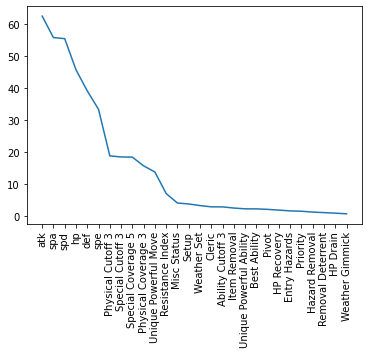

In [324]:
plt.plot(bestscores.sort_values(ascending=False))
plt.xticks(rotation = 90)
plt.show()

I notice a few things here: Unique Powerful Move is rather higher than usual, and basically all features than stats, moves, resistance index and unique powerful move are very low. This does confirm what we thought about the most useful features, but it doesn't tell us much about the least useful features since most of the features have pretty low values in common.

<a id="tsne"></a>
### T-distributed Stochastic Neighbor Embedding (TSNE)

Let's do T-SNE next, because it's a great way to visualize high dimensional data. We can try it with the general X, but I suspect it won't find too much there. I'm more hopeful of it finding something in stats though, and maybe that could give us a clue as to a useful number of clusters.

A seemingly good idea would be coloring the plot based on clusters! So I can reload my clustering from before, starting with the kmeans clustering for X.

In [325]:
kmeans = KMeans(n_clusters=20, random_state=42)
clusts = kmeans.fit_predict(X)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

2     68
4     62
6     51
18    48
17    45
0     45
16    42
8     39
15    38
3     37
19    36
1     36
10    35
14    33
11    32
9     24
5     23
12    18
7     15
13    11
Name: labels, dtype: int64

Perplexity is an important hyperparamter of this algorithm.  I think we'll try 2, 5, 30, 50 and 100 like they do in this distill article: https://distill.pub/2016/misread-tsne/, using a for loop (I may have to go a bit higher for the amount of points I have, so I might throw 250 and 500 in there)

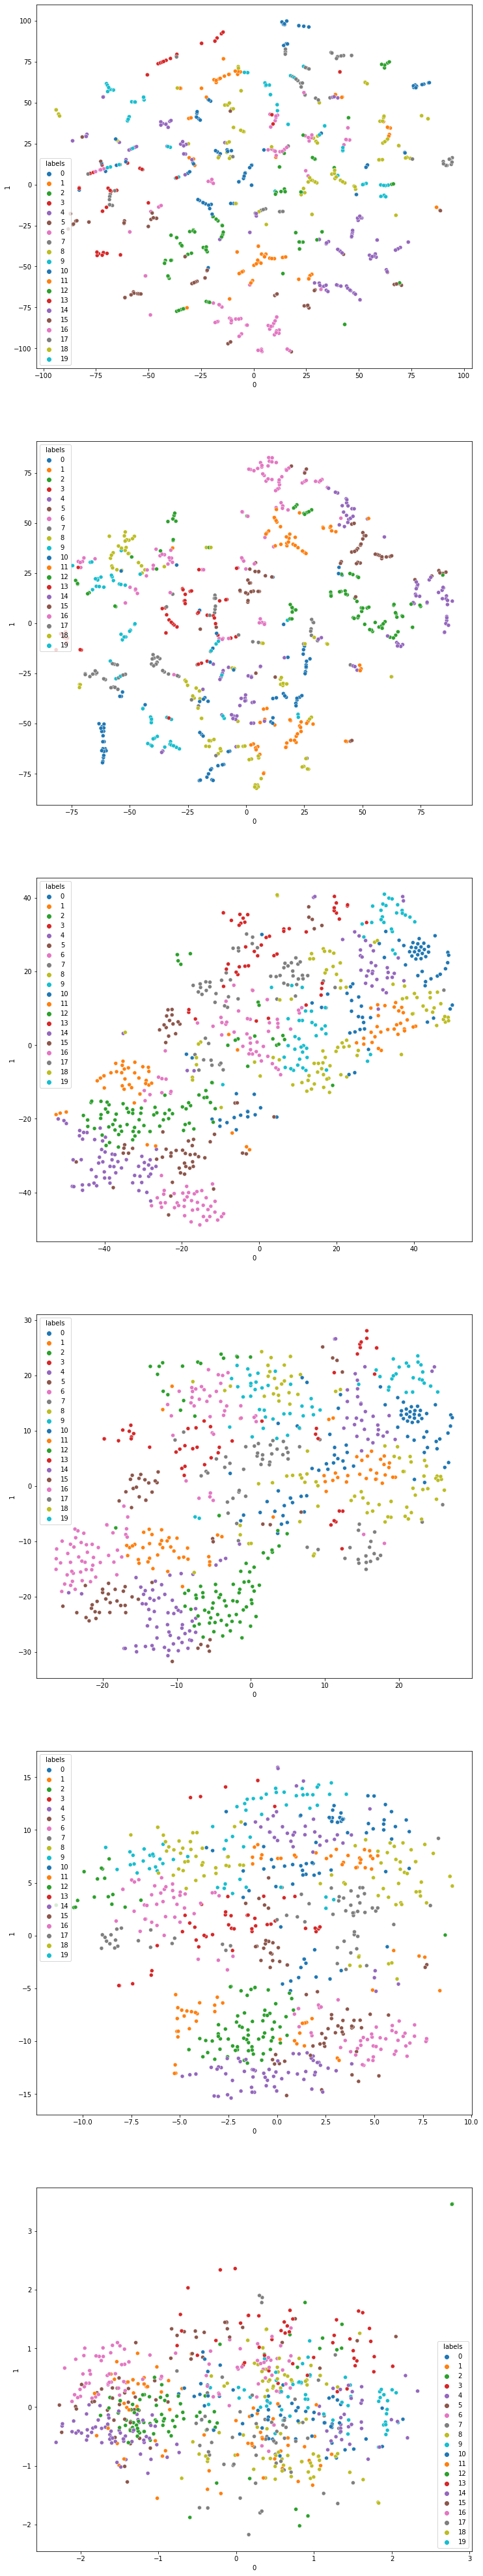

In [326]:
perplexity = [2, 5, 30, 50, 100, 500]

fig, axes = plt.subplots(6, figsize=(12, 12*6))

for p, axis in zip(perplexity, axes):
    tsne = TSNE(n_components=2, perplexity=p, n_iter=1000, random_state=42, method='exact')
    embedded = pd.DataFrame(tsne.fit_transform(X), index=pokemon_data.index)
    embedded['labels'] = pairs['labels'].astype('category')
    sns.scatterplot(ax=axis, x=embedded[0], y=embedded[1], data=embedded, hue=embedded['labels'], palette=sns.color_palette(n_colors=20))

plt.show()

We can see the TSNE plots capturing the 20 KMeans clusters very well, especially in the first 4, so that is a very good sign about the validity and usefulness of our clusters. It also seems possible that a different number of clusters could be more ideal though, so it still makes sense to take the number of clusters as a hyperparameter.

Let's try the same thing with stats:

In [327]:
kmeans = KMeans(n_clusters=20, random_state=42)
clusts = kmeans.fit_predict(pokemon_df.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

16    74
8     64
15    54
0     53
10    49
7     48
3     45
14    44
12    44
13    39
6     36
9     34
2     33
4     31
5     29
1     24
19    14
17    11
11    10
18     2
Name: labels, dtype: int64

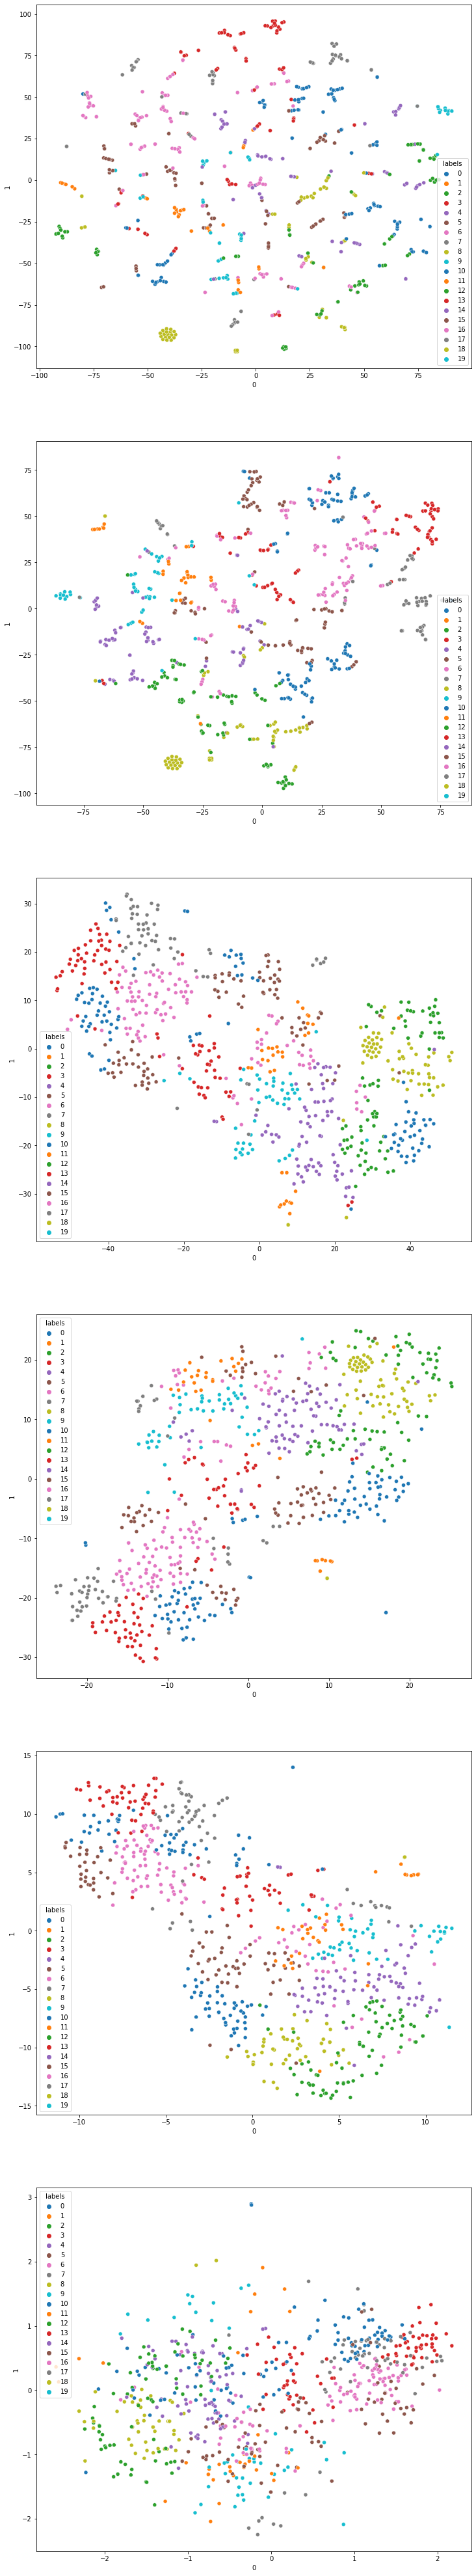

In [328]:
perplexity = [2, 5, 30, 50, 100, 500]

fig, axes = plt.subplots(6, figsize=(12, 12*6))

for p, axis in zip(perplexity, axes):
    tsne = TSNE(n_components=2, perplexity=p, n_iter=1000, random_state=42, method='exact')
    embedded = pd.DataFrame(tsne.fit_transform(pokemon_df.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']]), index=pokemon_data.index)
    embedded['labels'] = pairs['labels'].astype('category')
    sns.scatterplot(ax=axis, x=embedded[0], y=embedded[1], data=embedded, hue=embedded['labels'], palette=sns.color_palette(n_colors=20))

plt.show()

It's very similar results to X, which is good. The last plot is pretty chaotic but they all seem to capture a basic structure similar to the clusters.  Now let's do abilities and learnsets:

In [329]:
kmeans = KMeans(n_clusters=20, random_state=42)
clusts = kmeans.fit_predict(pokemon_abilities_df)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

0     379
14     45
5      30
19     26
12     26
10     23
7      23
17     20
6      18
16     18
1      18
3      17
4      17
15     16
13     15
18     12
2      10
8      10
11      8
9       7
Name: labels, dtype: int64

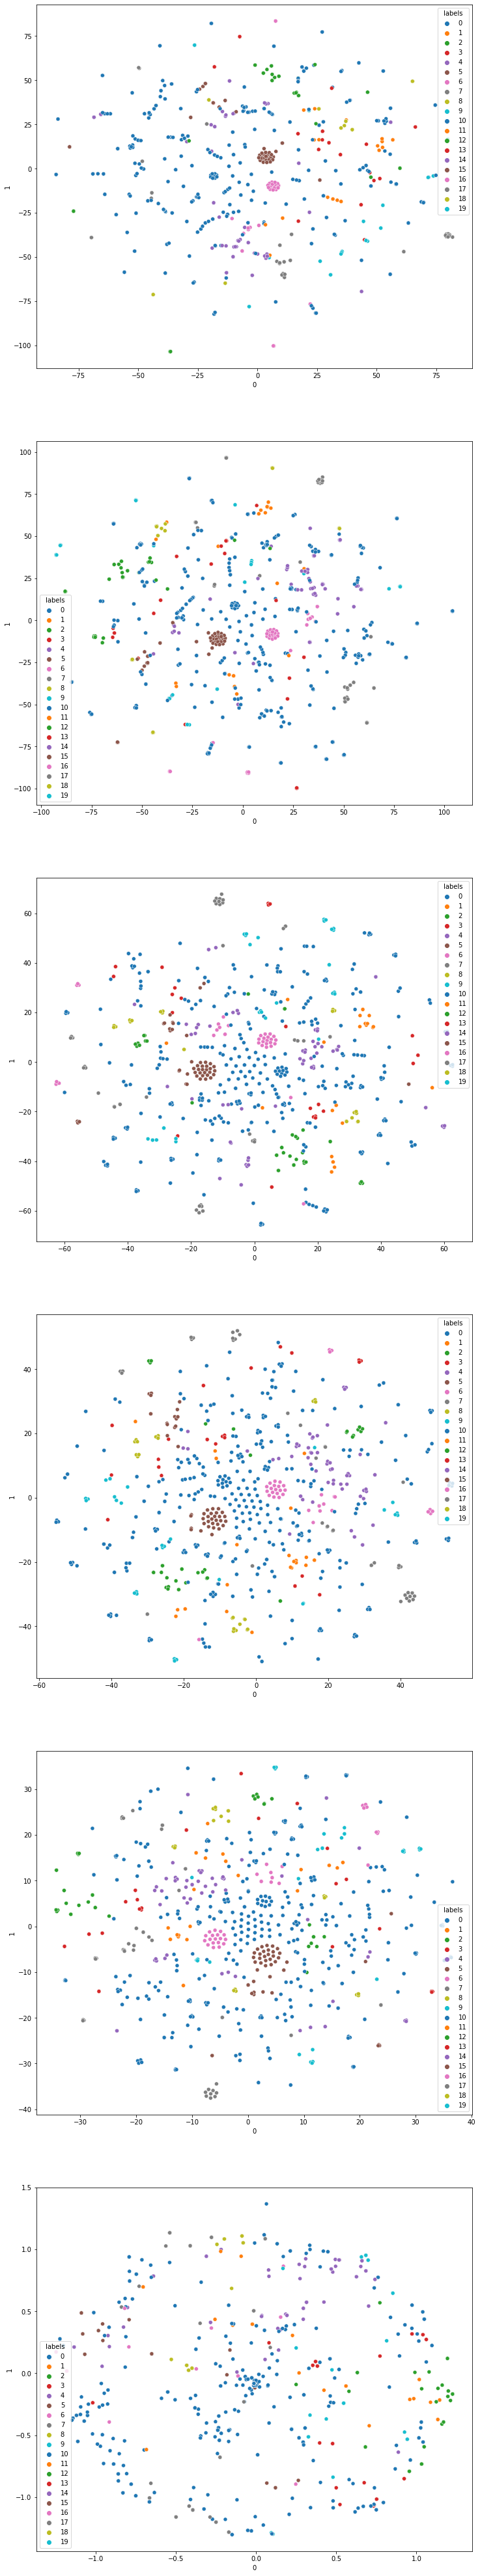

In [330]:
perplexity = [2, 5, 30, 50, 100, 500]

fig, axes = plt.subplots(6, figsize=(12, 12*6))

for p, axis in zip(perplexity, axes):
    tsne = TSNE(n_components=2, perplexity=p, n_iter=1000, random_state=42, method='exact')
    embedded = pd.DataFrame(tsne.fit_transform(pokemon_abilities_df), index=pokemon_data.index)
    embedded['labels'] = pairs['labels'].astype('category')
    sns.scatterplot(ax=axis, x=embedded[0], y=embedded[1], data=embedded, hue=embedded['labels'], palette=sns.color_palette(n_colors=20))

plt.show()

The abilities clusters might even be the most interesting so far, since there is a lot of blue scattered about from the very large and indistinct clusters, but there are these tightly clustered balls of various clusters within that representing smaller clusters, especially in the first 4 or 5 plots. I definitely think something like this could be useful information for the model.

Let's try learnsets:

In [331]:
kmeans = KMeans(n_clusters=20, random_state=42)
clusts = kmeans.fit_predict(pokemon_learnsets_df)
pairs = pd.DataFrame({'labels': clusts, 'pokemon': pokemon_df.index, 'formats': pokemon_data['formats']})
pairs['labels'].value_counts()

7     79
2     63
19    62
8     59
13    55
14    54
15    45
11    45
12    40
5     36
4     29
18    27
10    23
9     22
16    21
0     20
3     19
1     17
6     16
17     6
Name: labels, dtype: int64

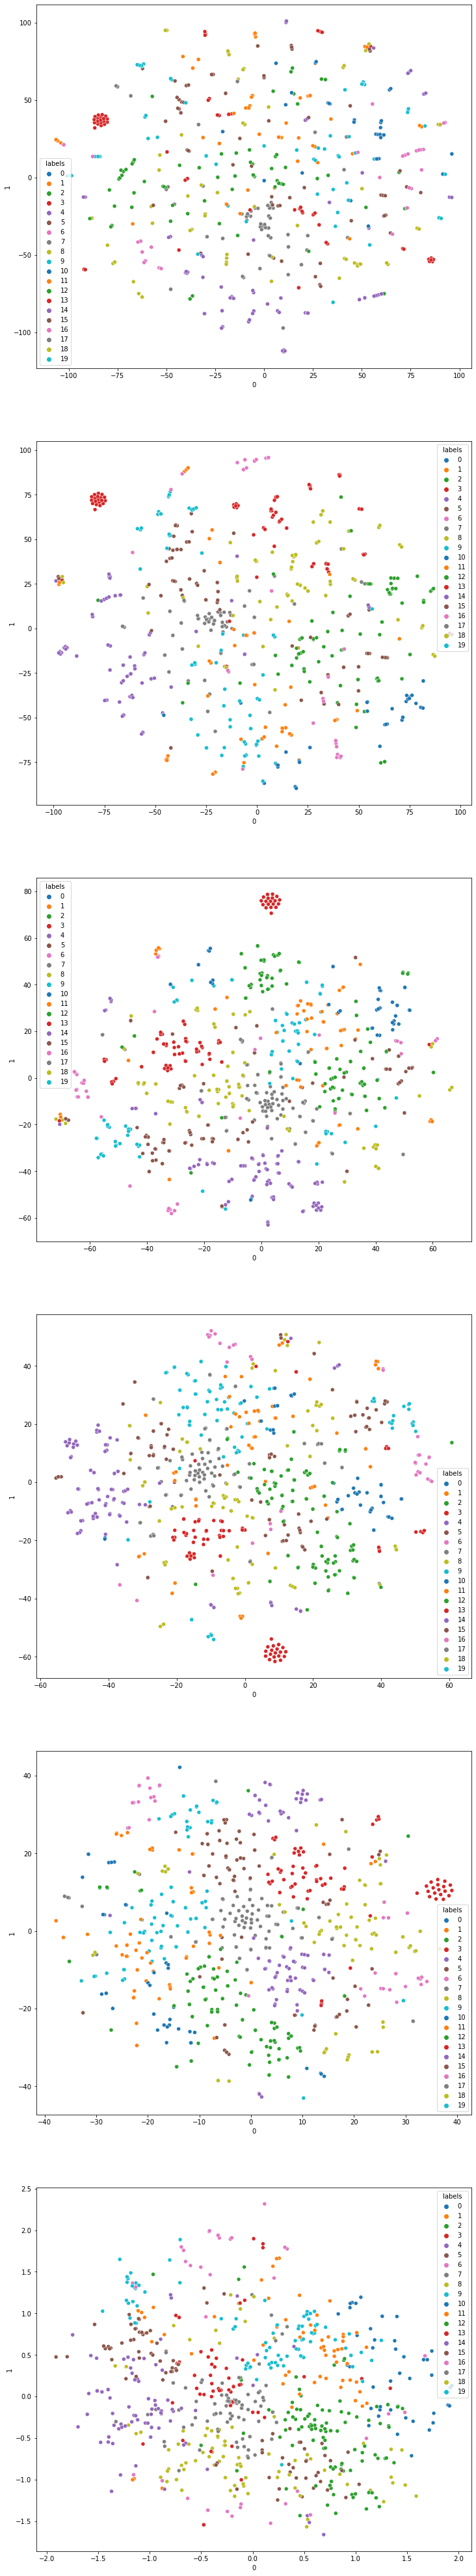

In [332]:
perplexity = [2, 5, 30, 50, 100, 500]

fig, axes = plt.subplots(6, figsize=(12, 12*6))

for p, axis in zip(perplexity, axes):
    tsne = TSNE(n_components=2, perplexity=p, n_iter=1000, random_state=42, method='exact')
    embedded = pd.DataFrame(tsne.fit_transform(pokemon_learnsets_df), index=pokemon_data.index)
    embedded['labels'] = pairs['labels'].astype('category')
    sns.scatterplot(ax=axis, x=embedded[0], y=embedded[1], data=embedded, hue=embedded['labels'], palette=sns.color_palette(n_colors=20))

plt.show()

The structure of this one is probably the strangest, because in the lower perplexity plots, you get two things: some very widely distributed clusters (which isn't a good sign) even though there aren't any particularly large clusters like there were for abilities, and also some tightly clustered balls that contain three or more clusters, which makes little sense.

However, the very high 500 perplexity plot seems to separate clusters best and most consistently, even though there aren't tightly clustered balls anymore (which may make sense since the learnsets are a lot more complex, and thus perhaps at far greater distance, than the stats and abilities and overall features going into my model). Probably the learnsets have the lowest quality so far though, but not low enough to convince me not to try clustering with them to see how it affects model performance.

<a id="heatmap"></a>
### Heatmap of Feature Correlations

Now we want to look at a heatmap of our features to see what mutual correlations they have (at least looking for those that are notable since most obviously won't be). This can potentially tell us whether any of our features might be redundant for the model (so that we can either not use them or fold them into more useful features).

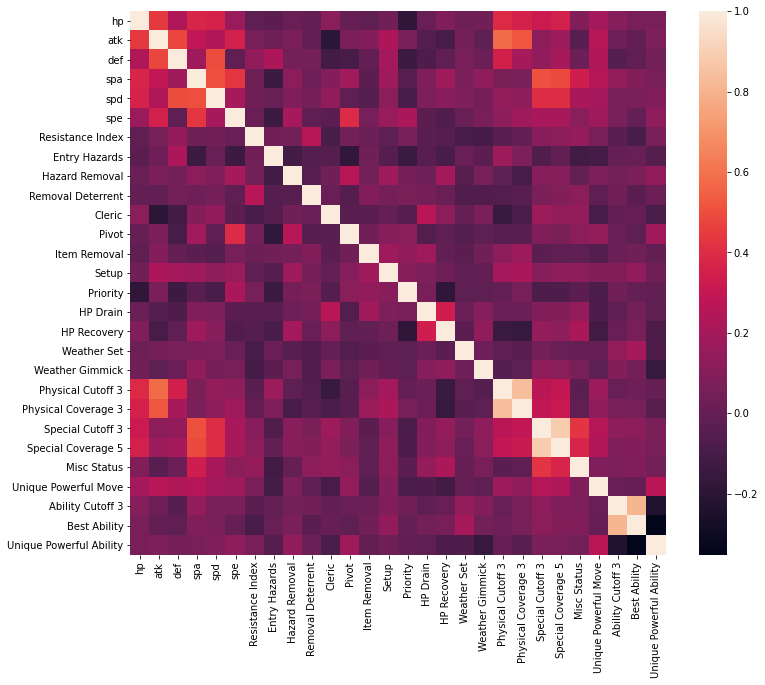

In [333]:
plt.subplots(figsize=(12,10))
sns.heatmap(X.corr());

What stands out as being of most interest here?
- All of the stats have decently high mutual correlation. But we certainly need all the stats, since they consistently perform the best out of all of our features, so we won't be getting rid of anything there
- Speed has a decent correlation with being a pivot (having pivot moves), but those two things don't seem similar enough that I could get rid of one or the other over it, especially since one of them is a stat which is one of our basic building blocks
- Attack has high correlation with physical cutoff and coverage, and likewise special attack has high correlation with special cutoff and coverage, but I can't get rid of one or the other since those are our best features (stats and move cutoffs). This correlation just seems very natural
- HP Drain and HP recovery have a somewhat decent correlation, so it might be worth considering folding them into the same feature since they have a similar role of restoring the hp of a pokemon (it's just that some do damage whereas some restore directly, but we still have cindex as a standardized means of comparing the separate hierarchies of those features to combine them into a single hierarchy)
- Misc status also has a decent correlation with special cutoff and coverage, but those are so different that it's hard to imagine combining them and since they are different but important kinds of moves, removing both of them doesn't seem realistic. Misc status might also become more predictive if I fold some of the other less useful features into it
- Probably the most important insight: physical cutoff has very high correlation with physical coverage, just as special cutoff has with special coverage, just as ability cutoff has with best ability. Those are probably the strongest candidate for features to remove; I may not all the features for physical and special attack, and especially not for abilities. For abilities we will very likely use Best Ability over Ability Cutoff 3 (simply removing the latter), and for the physical and special moves, I may just treat using one or both of them as a hyperparameter and check model performance

<a id="target_plots"></a>
### Plotting Features against the Target

Now we can try doing scatterplots of each feature against the target feature to see if anything noteworthy pops out that indicates something we might want to pay attention to:

In [334]:
X_withformats = X.copy()
X_withformats['format codes'] = y_df['format codes']

In [335]:
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'format codes', data=X_withformats, alpha=0.5)
        ax.set(xlabel=col, ylabel='competitiveness')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

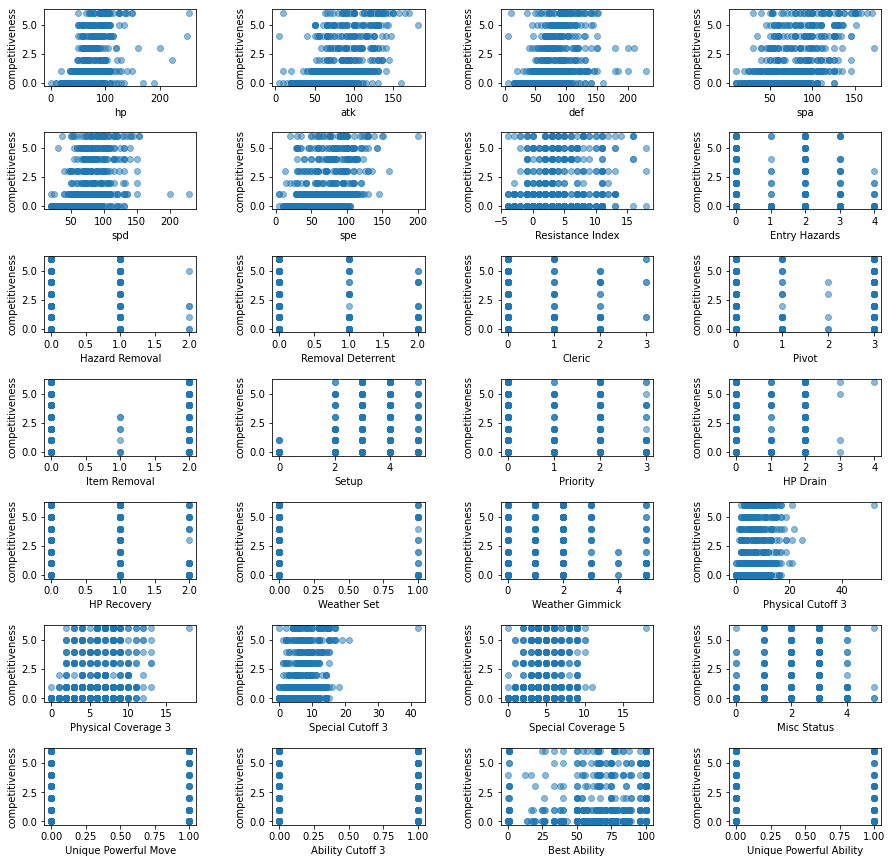

In [336]:
scatterplots(X.columns, ncol=4, figsize=(15, 15))

It's good that we looked at this, since some of these features don't seem to be doing what we'd like them to. For our best features, like stats, you can see their average largely increasing with their competitiveness.

- We have things like Entry Hazards and Hazard Removal.  These may be important aspects of the game, but increases in their values don't seem to correlate that well with competitiveness, with the highest value having the worst target variable results in some cases! Even removal deterrent isn't doing great at its best value
- Pivot has high correlation with speed and the 2 value isn't very good, so maybe it's best to throw into the better move cutoffs like physical, special and misc status in some cases
- Setup actually seems like a good stand alone feature because you can see higher values correlating to competitiveness whereas low values of this are never competitive
- Priority is not doing so well, with very little differentiation between tiers and the highest value of it seeming the lightest when it comes to high competitive rankings
- HP Drain and Recovery really don't seem very good either, and I was already considering folding them into a combined feature together so I may do exactly that
- Weather Set is really unique, but maybe I should just consider it a good ability?  As a standalone it doesn't seem super predictive.  Weather Gimmick seems even worse in this regard, with higher values being rather uncompetitive in some cases. It's possible that combining them together could also help
- Misc status isn't even great, but it's not terrible and if we fold more into it, maybe that highest value will populated more. Also, we need to aggregate information about status moves somewhere so I don't think I can justify getting rid of it

<a id="what_test"></a>
### What To Test During Pre-Processing and Modeling

- two-stage model or one-stage model
- 4 class vs 7 class model
- how to split a 4 class model: like we did in tierchange_df formats, in oldformats (which was ZU/PU+NU+RU/UU+OU/Ubers), or even using a new split for tierchange_df formats to maximize both class sizes and distinctiveness of Ubers (ZU/PU/NU+RU+UU+OU/Ubers)
- gridsearchcv for some hyperparameters for each model
- whether to use clustering or not
- how many kmeans clusters (we're just going to do it using the overall features for now, and stats/abilities/learnsets separately, we aren't going to do combinations)

to do with features:
- remove: ability cutoff, unique powerful ability
- fold weather set into weather gimmick
- fold hp drain and hp recovery together into a recovery feature
- considering: removal deterrent (could arguably just remove since its abilities), hazard removal, cleric, entry hazards (all 3 of those might go into misc status)

In [337]:
pokemon_data.to_csv('./data/pokemon_data.csv')